# Projet 4 : Segmentez des clients d'un site e-commerce

### Brazilian E-Commerce Public Dataset by Olist

Le jeu de données comporte 100k commandes de 2016 à 2018 chez plusieurs enseignes au Brésil.
Les données renseignent les informations suivantes : prix, évaluation, nombre d'articles, poids, description, géolocalisation... 


#### Objectifs :

- Comprendre les différents types d'utilisateurs grâce à leur comportement et à leurs données personnelles

- Fournir à Olist, une segmentation de ses clients avec une description actionable de cette segmantation et sa logique sous-jacente

- Fournir à Olist, une proposition de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temps



Pour plus d'informations sur les données : https://www.kaggle.com/olistbr/brazilian-ecommerce

#### Segmentation RFM :

RFM est un acronyme pour Recence, Fréquence et Montant. 

- Récence indique la date du dernier achat. Il s'agit du nombre de jours depuis la dernière commande d'un client. 


- Fréquence est le nombre d'achat sur une période déterminé. Cela peut être 3 mois, 6 mois ou un 1 an. Elle indique la fidélité d'un client, plus sa valeur est élevé et plus le client est engagé.


- Montant est la somme totale qu'un client dépense sur une période donnée


<img src="rfm.png">

#### Methodologie 1 :

- 1. Calcul des variables R, F et M
- 2. Quantiliser chaque variable R, F et M puis attribuer la note associé de 1 à 5 pour chaque client et pour chaque variable
- 3. Segmenter des groupes d'individus en fonction de leurs notes pour chaque variable R, F et M
- 4. Etiquetter chaque segment


#### Méthodologie 2 :

- 1. Calcul des variables R, F et M 
- 2. Les variables R, F et M sont normalisés 
- 3. Utiliser un algorithme de clusterisation sur les données normalisés
- 4. Etiquetter chaque cluster obtenu





#### Stabilité de la segmentation

Pour chaque méthodologie étudié, une période est séléctionné pour la segmentation/clusterisation, puis une autre période sera testé pour évaluer la stabilité de la segmentation obtenue par la méthodologie étudié.

#### Chargement des librairies

In [274]:
# Librairies graphiques, mathématiques et de manipulation de données
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from datetime import timedelta
from mpl_toolkits.mplot3d import Axes3D
from math import pi
import plotly.graph_objects as go
import time
import pickle

# Création de Pipeline
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.compose import ColumnTransformer

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Transformateurs de variables
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder

# Méthodes de clustering
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import DBSCAN

# Metrics de Clustering
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import adjusted_rand_score


#%load_ext pycodestyle_magic

#### Lecture des données

In [2]:
# Chemin d'accès aux données
path = "data/"

# Infos sur la géolocalisation
geo = pd.read_csv(os.path.join(path, "olist_geolocation_dataset.csv"))
# Infos sur les payments
payments = pd.read_csv(os.path.join(path, "olist_order_payments_dataset.csv"))
# Infos sur les achats
orders = pd.read_csv(os.path.join(path, "olist_orders_dataset.csv"))
# Infos sur les produits
products = pd.read_csv(os.path.join(path, "olist_products_dataset.csv"))
# Infos sur les vendeurs
sellers = pd.read_csv(os.path.join(path, "olist_sellers_dataset.csv"))
# Infos sur les clients
customers = pd.read_csv(os.path.join(path, "olist_customers_dataset.csv"))
# Infos sur l'évaluation des produits
reviews = pd.read_csv(os.path.join(path, "olist_order_reviews_dataset.csv"))
# Infos sur les items
items = pd.read_csv(os.path.join(path, "olist_order_items_dataset.csv"))
# Infos sur les catégories des produits
category = pd.read_csv(os.path.join(path, "product_category_name_translation.csv"))

## 1. Description et visualisation des données

### 1.1 Données géographiques

#### 1.1.1 Apperçu des données

In [3]:
# Apperçu des 5 premières lignes
geo.head()

geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  \
0                         1037       -23.545621       -46.639292   
1                         1046       -23.546081       -46.644820   
2                         1046       -23.546129       -46.642951   
3                         1041       -23.544392       -46.639499   
4                         1035       -23.541578       -46.641607   

  geolocation_city geolocation_state  
0        sao paulo                SP  
1        sao paulo                SP  
2        sao paulo                SP  
3        sao paulo                SP  
4        sao paulo                SP

#### 1.1.1 Structure des données

In [4]:
# Structure des données
geo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB


#### 1.1.2 Visualisation géographique

In [5]:
# Removing some outliers
# Brazils most Northern spot is at 5 deg 16′ 27.8″ N latitude
geo = geo[geo.geolocation_lat <= 5.27438888]
# it’s most Western spot is at 73 deg, 58′ 58.19″W Long
geo = geo[geo.geolocation_lng >= -73.98283055]
# It’s most southern spot is at 33 deg, 45′ 04.21″ S Latitude
geo = geo[geo.geolocation_lat >= -33.75116944]
# It’s most Eastern spot is 34 deg, 47′ 35.33″ W Long.
geo = geo[geo.geolocation_lng <= -34.79314722]

In [6]:
# Apperçu des 5 premières lignes
geo.head()

geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  \
0                         1037       -23.545621       -46.639292   
1                         1046       -23.546081       -46.644820   
2                         1046       -23.546129       -46.642951   
3                         1041       -23.544392       -46.639499   
4                         1035       -23.541578       -46.641607   

  geolocation_city geolocation_state  
0        sao paulo                SP  
1        sao paulo                SP  
2        sao paulo                SP  
3        sao paulo                SP  
4        sao paulo                SP

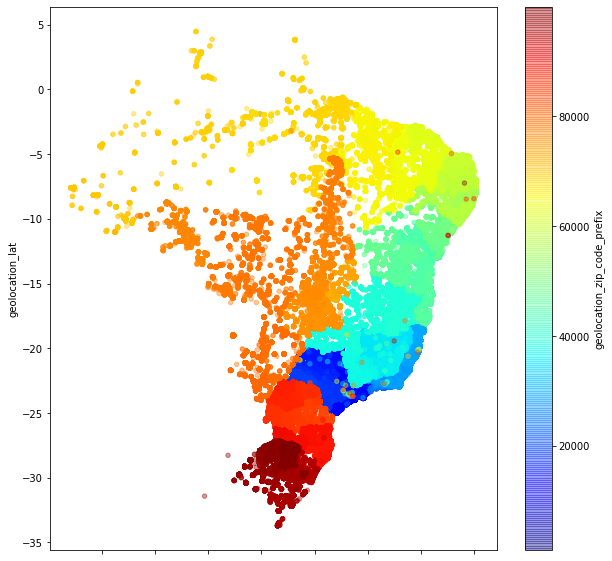

In [7]:
# Affichage graphique des zip_code_prefix,
# des latitudes et longitudes associées
geo.plot(kind="scatter", x="geolocation_lng", y="geolocation_lat",
         alpha=0.4, c="geolocation_zip_code_prefix",
         cmap=plt.get_cmap("jet"), colorbar=True, figsize=(10, 10))
plt.show()

### 1.2 Données sur les payments

#### 1.2.1 Apperçu des données

In [8]:
# Apperçu des 5 premières lignes
payments.head()

order_id  payment_sequential payment_type  \
0  b81ef226f3fe1789b1e8b2acac839d17                   1  credit_card   
1  a9810da82917af2d9aefd1278f1dcfa0                   1  credit_card   
2  25e8ea4e93396b6fa0d3dd708e76c1bd                   1  credit_card   
3  ba78997921bbcdc1373bb41e913ab953                   1  credit_card   
4  42fdf880ba16b47b59251dd489d4441a                   1  credit_card   

   payment_installments  payment_value  
0                     8          99.33  
1                     1          24.39  
2                     1          65.71  
3                     8         107.78  
4                     2         128.45

#### 1.2.2 Structure et description des données

In [9]:
# Structure des données
payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [10]:
# Description des données
payments.describe()

payment_sequential  payment_installments  payment_value
count       103886.000000         103886.000000  103886.000000
mean             1.092679              2.853349     154.100380
std              0.706584              2.687051     217.494064
min              1.000000              0.000000       0.000000
25%              1.000000              1.000000      56.790000
50%              1.000000              1.000000     100.000000
75%              1.000000              4.000000     171.837500
max             29.000000             24.000000   13664.080000

#### 1.2.3 Analyse graphique des données

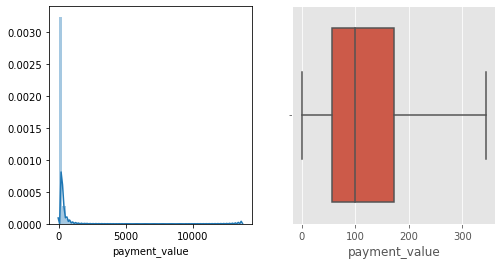

In [11]:
fig = plt.figure(1, figsize=(8, 4))
# Histogramme de "payment_value"
plt.subplot(1, 2, 1)
sns.distplot(payments["payment_value"])
plt.style.use('ggplot')

# Boxplot de "payment_value"
plt.subplot(1, 2, 2)
sns.boxplot(payments["payment_value"], showfliers=False)
plt.show()

- Le payement median est de 100 R$

In [12]:
# Nombre de valeurs par type de paiements
payments["payment_type"].value_counts()

credit_card    76795
boleto         19784
voucher         5775
debit_card      1529
not_defined        3
Name: payment_type, dtype: int64

Suppresion des payments "not_defined"

In [13]:
# On supprime les paiements de type "not_defined"
payment_type = ["credit_card", "boleto", "voucher", "debit_card"]
payments = payments[payments["payment_type"].isin(payment_type)]

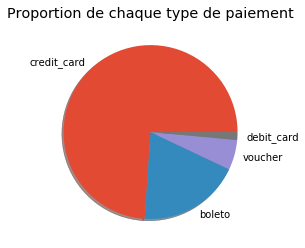

In [14]:
# Pieplot des différents moyens de paiements
plt.title("Proportion de chaque type de paiement")
fig = plt.figure(1, figsize=(8, 8))
plt.pie(payments["payment_type"].value_counts(),
        labels=payments["payment_type"].unique(), shadow=True)
plt.show()

Boxplot des montant des payements en fonction du type de payement

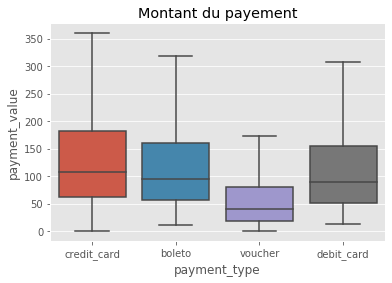

In [15]:
# Boxplot pour chaque type de paiement
plt.title("Montant du payement")
sns.boxplot(data=payments, y="payment_value",
            x="payment_type", showfliers=False)
plt.show()

- Voucher signifie bon d'achats, le payement moyen par ce type de payment est plus faible que les autres

- Boleto est un moyen de payment en espèce

In [16]:
# Nombre moyen de paiements par type de paiement
payments.groupby("payment_type").mean()["payment_installments"]

payment_type
boleto         1.000000
credit_card    3.507155
debit_card     1.000000
voucher        1.000000
Name: payment_installments, dtype: float64

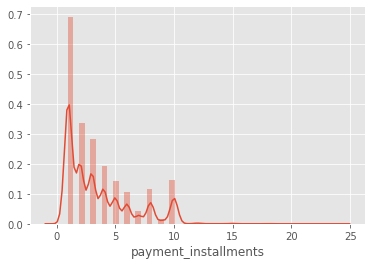

In [17]:
# Densité du nombre de paiements pour
# tous les paiements effectués par carte de crédit
credit_card = payments[payments["payment_type"] == "credit_card"]
sns.distplot(credit_card["payment_installments"])
plt.show()

- Le nombre moyen de payments est majoritairement égale à 1

### 1.3 Données sur les "items"

#### 1.3.1 Apperçu des données

In [18]:
# Affichage des 5 premières lignes
items.head()

order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   
3  00024acbcdf0a6daa1e931b038114c75              1   
4  00042b26cf59d7ce69dfabb4e55b4fd9              1   

                         product_id                         seller_id  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1  e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2  c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   
3  7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   
4  ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87   

   shipping_limit_date   price  freight_value  
0  2017-09-19 09:45:35   58.90          13.29  
1  2017-05-03 11:05:13  239.90          19.93  
2  2018-01-18 14:48:30  199.00          17.87  
3  2018-08-15 10:10:18   12.99          12.79  
4  2017-02-13 13:57:51  199.90          18.14

#### 1.3.2 Structure et description des données

In [19]:
# Structure des données
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [20]:
# Description des données
items.describe()

order_item_id          price  freight_value
count  112650.000000  112650.000000  112650.000000
mean        1.197834     120.653739      19.990320
std         0.705124     183.633928      15.806405
min         1.000000       0.850000       0.000000
25%         1.000000      39.900000      13.080000
50%         1.000000      74.990000      16.260000
75%         1.000000     134.900000      21.150000
max        21.000000    6735.000000     409.680000

- order_item_id est le nombre d'objets dans une même commande

- freight_value est le coût de livraison

- shipping_limit_date correspond à la date d'expédition auprès du transporteur

#### 1.3.3 Analyse graphique des données

#### Nombre d'articles dans une même commande

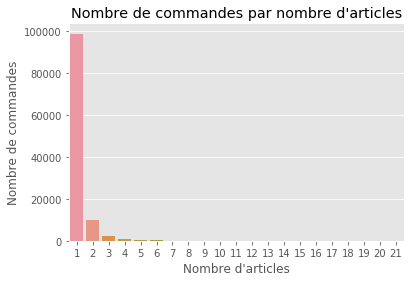

In [21]:
# Nombre d'articles dans une même commande
x = list(items["order_item_id"].value_counts().index)
y = items["order_item_id"].value_counts().values

plt.title("Nombre de commandes par nombre d'articles")
plt.xlabel("Nombre d'articles")
plt.ylabel("Nombre de commandes")
sns.barplot(x, y)
plt.show()

- La plus grande majorité des commande comporte un seul article

#### Prix et coûts de transport des marchandises

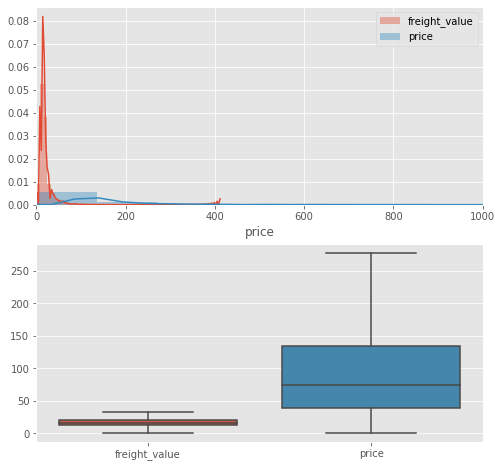

In [22]:
fig = plt.figure(1, figsize=(8, 8))

# Histogramme freight value et prix
plt.subplot(211)
sns.distplot(items["freight_value"], label="freight_value")
sns.distplot(items["price"], label="price")
plt.legend()
# x-axis limits
plt.xlim([0, 1000])

# Boxplot freight value et prix
plt.subplot(212)
sns.boxplot(data=items, order=["freight_value", "price"], showfliers=False)
plt.show()

### 1.4 Données sur les vendeurs

#### 1.4.1 Apperçu des données

In [23]:
# Affichage des 5 premières lignes
sellers.head()

seller_id  seller_zip_code_prefix  \
0  3442f8959a84dea7ee197c632cb2df15                   13023   
1  d1b65fc7debc3361ea86b5f14c68d2e2                   13844   
2  ce3ad9de960102d0677a81f5d0bb7b2d                   20031   
3  c0f3eea2e14555b6faeea3dd58c1b1c3                    4195   
4  51a04a8a6bdcb23deccc82b0b80742cf                   12914   

         seller_city seller_state  
0           campinas           SP  
1         mogi guacu           SP  
2     rio de janeiro           RJ  
3          sao paulo           SP  
4  braganca paulista           SP

#### 1.4.2 Nombre de villes et d'Etats

In [24]:
# Nombre de villes
number_of_cities = sellers["seller_city"].nunique()
# Nombre d'Etats
number_of_states = sellers["seller_state"].nunique()
print("Le nombre de villes est : {}".format(number_of_cities))
print("Le nombre d'états est : {}".format(number_of_states))

Le nombre de villes est : 611
Le nombre d'états est : 23


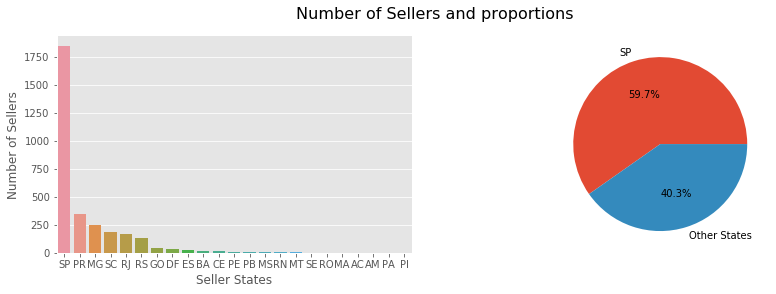

In [25]:
# Affichage graphique du nomnbre de vendeurs dans les différents états
fig = plt.figure(1, figsize=(14, 4))
fig.suptitle("Number of Sellers and proportions", fontsize=16)
plt.subplot(121)
sns.barplot(y=sellers["seller_state"].value_counts(), x=sellers["seller_state"].value_counts().index)
plt.xlabel('Seller States')
plt.ylabel('Number of Sellers')

plt.subplot(122)
prop = sellers["seller_state"].value_counts()["SP"]/len(sellers)
y = [prop, 1 - prop]
plt.pie(y, labels=["SP", "Other States"], autopct='%1.1f%%')
plt.show()

Il y a une prédominance de vendeurs dans l'état de São Paulo

### 1.5 Données sur les acheteurs

#### 1.5.1 Apperçu des données

In [26]:
# Affichage des 5 premières lignes
customers.head()

customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix          customer_city customer_state  
0                     14409                 franca             SP  
1                      9790  sao bernardo do campo             SP  
2                      1151              sao paulo             SP  
3                      8775        mogi das cruzes             SP  
4                     13056               campinas             SP

In [27]:
# Structure des données
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


#### 1.5.2 Nombre de villes et d'Etats

In [28]:
# Nombre de villes
number_of_cities = customers["customer_city"].nunique()
# Nombre d'Etats
number_of_states = customers["customer_state"].nunique()
# Nombre de consommateurs
number_of_customers = customers["customer_unique_id"].nunique()

print("Le nombre de villes est : {}".format(number_of_cities))
print("Le nombre d'états est : {}".format(number_of_states))
print("Le nombre de clients est : {}".format(number_of_customers))

Le nombre de villes est : 4119
Le nombre d'états est : 27
Le nombre de clients est : 96096


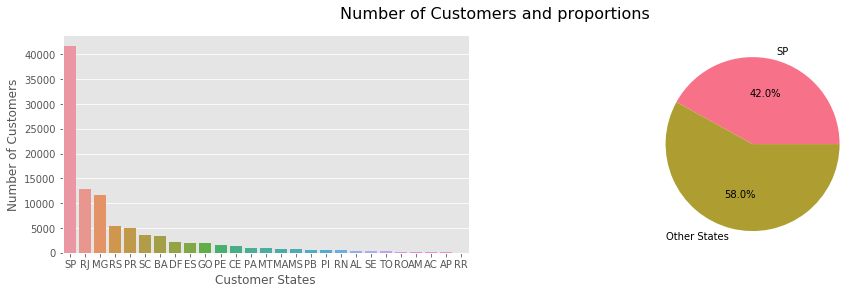

In [183]:
fig = plt.figure(1, figsize=(16, 4))
fig.suptitle("Number of Customers and proportions", fontsize=16)
plt.subplot(121)
sns.barplot(y=customers["customer_state"].value_counts(),
            x=customers["customer_state"].value_counts().index)
plt.xlabel('Customer States')
plt.ylabel('Number of Customers')

plt.subplot(122)
prop = customers["customer_state"].value_counts()["SP"]/len(customers)
y = [prop, 1 - prop]
plt.pie(y, labels=["SP", "Other States"], autopct='%1.1f%%')
plt.show()

Il y a une prédominance d'acheteurs dans l'état de São Paulo

### 1.6 Données sur les catégories des produits

In [30]:
# Affichage des 5 premières lignes
category.head()

product_category_name product_category_name_english
0            beleza_saude                 health_beauty
1  informatica_acessorios         computers_accessories
2              automotivo                          auto
3         cama_mesa_banho                bed_bath_table
4        moveis_decoracao               furniture_decor

In [31]:
# Structure des données
category.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   product_category_name          71 non-null     object
 1   product_category_name_english  71 non-null     object
dtypes: object(2)
memory usage: 1.2+ KB


In [32]:
print("Le nombre de catégories est de : {}"
      .format(category["product_category_name_english"].nunique()))

Le nombre de catégories est de : 71


### 1.7 Données sur l'évaluation des produits par les clients

In [33]:
# Affichage des 5 premières lignes
reviews.head()

review_id                          order_id  \
0  7bc2406110b926393aa56f80a40eba40  73fc7af87114b39712e6da79b0a377eb   
1  80e641a11e56f04c1ad469d5645fdfde  a548910a1c6147796b98fdf73dbeba33   
2  228ce5500dc1d8e020d8d1322874b6f0  f9e4b658b201a9f2ecdecbb34bed034b   
3  e64fb393e7b32834bb789ff8bb30750e  658677c97b385a9be170737859d3511b   
4  f7c4243c7fe1938f181bec41a392bdeb  8e6bfb81e283fa7e4f11123a3fb894f1   

   review_score review_comment_title  \
0             4                  NaN   
1             5                  NaN   
2             5                  NaN   
3             5                  NaN   
4             5                  NaN   

                              review_comment_message review_creation_date  \
0                                                NaN  2018-01-18 00:00:00   
1                                                NaN  2018-03-10 00:00:00   
2                                                NaN  2018-02-17 00:00:00   
3              Recebi bem antes do prazo estipulado.  2017-04-21 00:00:00   
4  Parabéns lojas lannister adorei comprar pela I...  2018-03-01 00:00:00   

  review_answer_timestamp  
0     2018-01-18 21:46:59  
1     2018-03-11 03:05:13  
2     2018-02-18 14:36:24  
3     2017-04-21 22:02:06  
4     2018-03-02 10:26:53

In [34]:
# Structure des données
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   review_id                100000 non-null  object
 1   order_id                 100000 non-null  object
 2   review_score             100000 non-null  int64 
 3   review_comment_title     11715 non-null   object
 4   review_comment_message   41753 non-null   object
 5   review_creation_date     100000 non-null  object
 6   review_answer_timestamp  100000 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


#### Visualisation du délai d'évaluation des produits

In [35]:
# Conversion des données dates en datetime
review_answer_timestamp = pd.to_datetime(reviews["review_answer_timestamp"])
review_creation_date = pd.to_datetime(reviews["review_creation_date"])
# Délai d'évaluation des produits
review_answer = review_answer_timestamp - review_creation_date
# Converti en secondes
review_answer = review_answer.dt.total_seconds()/(3600*24)
reviews["Delay_to_answer"] = review_answer

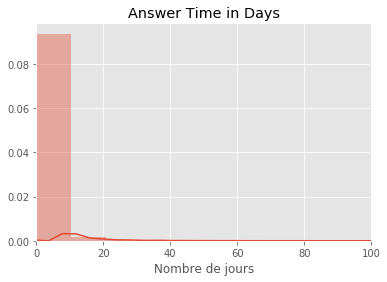

In [36]:
# Histogramme du délai d'évaluation des produits
sns.distplot(review_answer, label="Answer Time")
plt.xlim([0, 100])
plt.xlabel("Nombre de jours")
plt.title("Answer Time in Days")
plt.show()

### 1.8 Données sur les produits

#### 1.8.1 Apperçu des données

In [37]:
# Affichage des 5 premières lignes
products.head()

product_id  product_category_name  \
0  1e9e8ef04dbcff4541ed26657ea517e5             perfumaria   
1  3aa071139cb16b67ca9e5dea641aaa2f                  artes   
2  96bd76ec8810374ed1b65e291975717f          esporte_lazer   
3  cef67bcfe19066a932b7673e239eb23d                  bebes   
4  9dc1a7de274444849c219cff195d0b71  utilidades_domesticas   

   product_name_lenght  product_description_lenght  product_photos_qty  \
0                 40.0                       287.0                 1.0   
1                 44.0                       276.0                 1.0   
2                 46.0                       250.0                 1.0   
3                 27.0                       261.0                 1.0   
4                 37.0                       402.0                 4.0   

   product_weight_g  product_length_cm  product_height_cm  product_width_cm  
0             225.0               16.0               10.0              14.0  
1            1000.0               30.0               18.0              20.0  
2             154.0               18.0                9.0              15.0  
3             371.0               26.0                4.0              26.0  
4             625.0               20.0               17.0              13.0

In [38]:
# Structure des données
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


#### 1.8.2 Description des variables numériques

In [39]:
# Description des données
products.describe()

product_name_lenght  product_description_lenght  product_photos_qty  \
count         32341.000000                32341.000000        32341.000000   
mean             48.476949                  771.495285            2.188986   
std              10.245741                  635.115225            1.736766   
min               5.000000                    4.000000            1.000000   
25%              42.000000                  339.000000            1.000000   
50%              51.000000                  595.000000            1.000000   
75%              57.000000                  972.000000            3.000000   
max              76.000000                 3992.000000           20.000000   

       product_weight_g  product_length_cm  product_height_cm  \
count      32949.000000       32949.000000       32949.000000   
mean        2276.472488          30.815078          16.937661   
std         4282.038731          16.914458          13.637554   
min            0.000000           7.000000           2.000000   
25%          300.000000          18.000000           8.000000   
50%          700.000000          25.000000          13.000000   
75%         1900.000000          38.000000          21.000000   
max        40425.000000         105.000000         105.000000   

       product_width_cm  
count      32949.000000  
mean          23.196728  
std           12.079047  
min            6.000000  
25%           15.000000  
50%           20.000000  
75%           30.000000  
max          118.000000

#### 1.8.3 Création de la variable volume

In [40]:
# volume = height*lenght*width
products["product_volume_cm3"] = products["product_length_cm"] \
                               * products["product_height_cm"] \
                               * products["product_width_cm"]

#### 1.8.4 Affiche de la matrice de corrélation

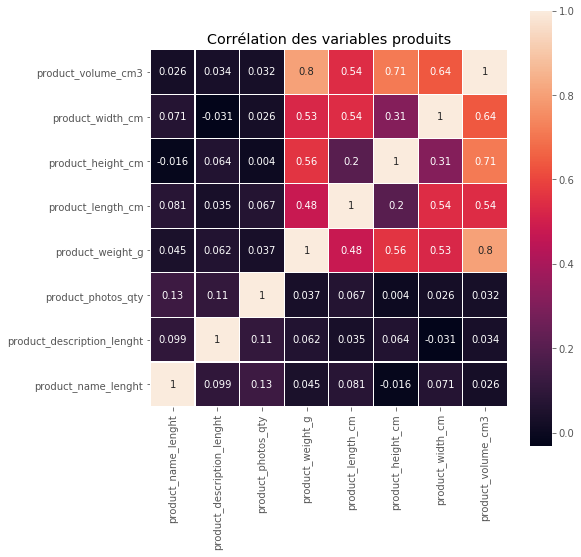

In [41]:
# Matrice de corrélation
matrix_corr = products.corr()
fig = plt.figure(1, figsize=(8, 8))
# Heatmap de la matrice de corrélation
sns.heatmap(matrix_corr, square=True, linewidths=0.1, annot=True)
plt.ylim(0, matrix_corr.shape[0])
plt.title("Corrélation des variables produits")
plt.show()

- Le poids est évidemment corrélé aux dimensions du produit et donc du volume

In [42]:
# Nombre de catégories
print("Le nombre de catégories est : {}"
      .format(products["product_category_name"].nunique()))

Le nombre de catégories est : 73


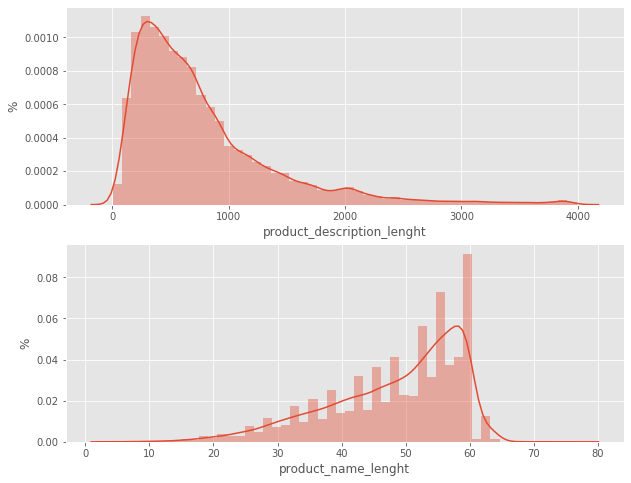

In [43]:
# Longueur de la description des produits
descr_nnull = products[~products["product_description_lenght"].isna()]
fig = plt.figure(1, figsize=(10, 8))
ax1 = fig.add_subplot(211)
sns.distplot(descr_nnull["product_description_lenght"], ax=ax1)
plt.ylabel("%")
# Longueur du nom du produit
ax2 = fig.add_subplot(212)
plt.ylabel("%")
sns.distplot(descr_nnull["product_name_lenght"], ax=ax2)

plt.show()

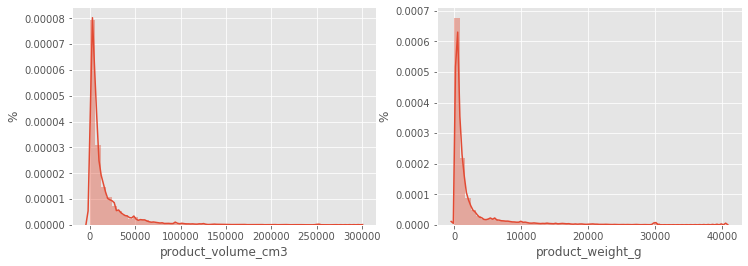

In [44]:
# Grapique histogramme volume et poids des produits
fig = plt.figure(1, figsize=(12, 4))
plt.subplot(121)
plt.ylabel("%")
sns.distplot(products["product_volume_cm3"])
plt.subplot(122)
plt.ylabel("%")
sns.distplot(products["product_weight_g"])
plt.show()

### 1.9 Données sur les achats

#### 1.9.1 Apperçu des données

In [45]:
# Affichage des 5 premières lignes
orders.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   
3          2017-11-22 13:39:59           2017-12-02 00:28:42   
4          2018-02-14 19:46:34           2018-02-16 18:17:02   

  order_estimated_delivery_date  
0           2017-10-18 00:00:00  
1           2018-08-13 00:00:00  
2           2018-09-04 00:00:00  
3           2017-12-15 00:00:00  
4           2018-02-26 00:00:00

In [46]:
# Affiche la structure du df
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


- order_delivered_carrier_date correspond à la date à laquelle la commande a été remise au transporteur


#### 1.9.2 Status d'achat

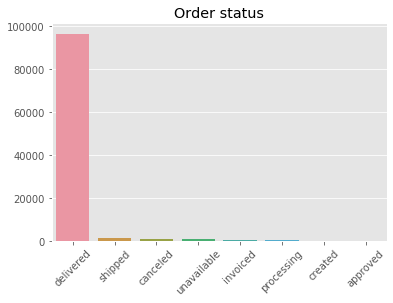

In [47]:
# Nombre de commandes par statuts d'achats
order_status = orders["order_status"].value_counts()
sns.barplot(x=order_status.index, y=order_status.values)
plt.title("Order status")
plt.xticks(rotation=45)
plt.show()

Suppression des commandes annulés

In [48]:
# Suppression des commandes 'canceled'
orders = orders[orders["order_status"] != "canceled"]

#### 1.9.3 Délai de livraison

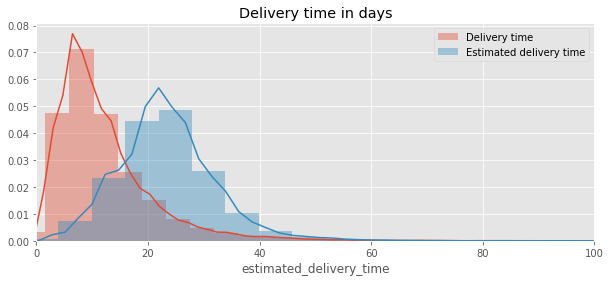

In [49]:
# Conversion des données dates en datetime
orders['order_approved_at'] = pd.to_datetime(
    orders['order_approved_at'])
orders['order_estimated_delivery_date'] = pd.to_datetime(
    orders['order_estimated_delivery_date'])
orders['order_delivered_customer_date'] = pd.to_datetime(
    orders['order_delivered_customer_date'])

# Calculate differences in hours
orders['delivery_time'] = orders['order_delivered_customer_date'] \
                          - orders['order_approved_at']
orders['delivery_time'] = orders['delivery_time'] \
                          .dt.total_seconds() / 86400

orders['estimated_delivery_time'] = orders['order_estimated_delivery_date'] \
                                    - orders['order_approved_at']
orders['estimated_delivery_time'] = orders['estimated_delivery_time'] \
                                    .dt.total_seconds() / 86400

# Delivery estimated time and actual delivery time
plt.figure(figsize=(10, 4))
plt.title("Delivery time in days")
sns.distplot(orders['delivery_time'].dropna(), label='Delivery time')
sns.distplot(orders['estimated_delivery_time']
             .dropna(), label='Estimated delivery time')
plt.legend()
plt.xlim([0, 100])
plt.show()
# Calcul la différence de temps entre
# le délai réel de livraison et le délai estimé
orders['diff_time_delivery'] = orders['delivery_time'] \
                               - orders['estimated_delivery_time']

- Le temps estimé est toujours supérieur au temps de livraison réel

#### 1.9.4 Heure, jour de la semaine, mois, et jours du moi, week end

In [50]:
# On s'interesse uniquement à l''heure, le jour, et le mois de l'achat
orders.rename(columns={"order_purchase_timestamp": "purchase_time"},
              inplace=True)
orders["purchase_time"] = orders["purchase_time"].astype('datetime64[ns]')
orders["purchase_hour"] = orders["purchase_time"].map(lambda d: d.hour)
orders["purchase_weekday"] = orders["purchase_time"].map(lambda d: d.dayofweek)
orders["purchase_month"] = orders["purchase_time"].map(lambda d: d.month)
orders["purchase_day"] = orders["purchase_time"].map(lambda d: d.day)
WE = [5, 6]
orders["purchase_week"] = orders["purchase_day"].isin(WE).astype(np.int)

### 1.10 Données sur les catégories

In [51]:
# Affichage des 5 premières ligènes
category.head()

product_category_name product_category_name_english
0            beleza_saude                 health_beauty
1  informatica_acessorios         computers_accessories
2              automotivo                          auto
3         cama_mesa_banho                bed_bath_table
4        moveis_decoracao               furniture_decor

In [52]:
# Structure des données
category.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   product_category_name          71 non-null     object
 1   product_category_name_english  71 non-null     object
dtypes: object(2)
memory usage: 1.2+ KB


In [53]:
print("Le nombre de catégories est de : {}"
      .format(category["product_category_name_english"].nunique()))

Le nombre de catégories est de : 71


## 2. Concaténation des données et analyse multivariée

Tous les fichiers de données présentés précédemment sont liés les uns aux autres par des colonnes communes qui permettent de faire des jointures

Les liens entre chaque fichier de données sont présentés ci-dessous :

<img src="HRhd2Y0.png">

### 2.1 Concaténation des données et nettoyage

#### 2.1.1 Concaténation des données

In [54]:
# Renommage d'une colonne de sellers
sellers["geolocation_zip_code_prefix"] = sellers["seller_zip_code_prefix"]
# Fusion des dataframes sellers et geo
# par la colonne "geolocation_zip_code_prefix"
sellers = pd.merge(sellers, geo, how="left",
                   on=["geolocation_zip_code_prefix",
                       "geolocation_zip_code_prefix"])
# Suppression de la colonne 'geolocation_zip_code_prefix'
sellers.drop(columns=["geolocation_zip_code_prefix",
                      "geolocation_city",
                      "geolocation_state",
                      "geolocation_lat",
                      "geolocation_lng"],
             inplace=True)

In [55]:
# Fusion des dataframes orders et reviews par la colonne commune 'order_id'
orders = pd.merge(orders, reviews, how='left', on=['order_id', 'order_id'])
orders = pd.merge(orders, payments, how='left', on=['order_id', 'order_id'])

In [56]:
geo.drop_duplicates(subset=["geolocation_zip_code_prefix"],
                    keep="first", inplace=True)
geo["customer_zip_code_prefix"] = geo["geolocation_zip_code_prefix"]
# Fusion des données clients avec les données géographiques
customers = pd.merge(customers, geo, how='left',
                     on=["customer_zip_code_prefix",
                         "customer_zip_code_prefix"])
customers.drop(columns=["geolocation_zip_code_prefix",
                        "geolocation_lat",
                        "geolocation_lng",
                        "geolocation_city",
                        "geolocation_state"],
               inplace=True)


In [57]:
# Fusion des dataframes orders et customers
# par la colonne commune 'customer_id'
orders = pd.merge(orders, customers, how="left",
                  on=["customer_id", "customer_id"])
# Fusion des dataframes items et produits par la colonne commune 'product_id'
products = pd.merge(items, products, how='left',
                    on=["product_id", "product_id"])

In [58]:
# Fusion des orders et des produts par la colonne 'order_id'
df_ = pd.merge(orders, products, how='left', on=["order_id", 'order_id'])

In [59]:
# Ajout des catégories à l'ensemble des achats
df = pd.merge(df_, category, how='left', on=["product_category_name",
                                             "product_category_name"])
# Suppresion de la colonne 'product_category_name'
df.drop(columns='product_category_name', inplace=True)

#### Renommage de certaines variables

In [60]:
# Renommage de certaines variables
df.rename(columns={"geolocation_lat": "customer_lat",
                   "geolocation_lng": "customer_lng",
                   "product_category_name_english": "product_category_name"},
          inplace=True)

#### 2.1.2 Nettoyage des données

#### Proportions de données manquantes

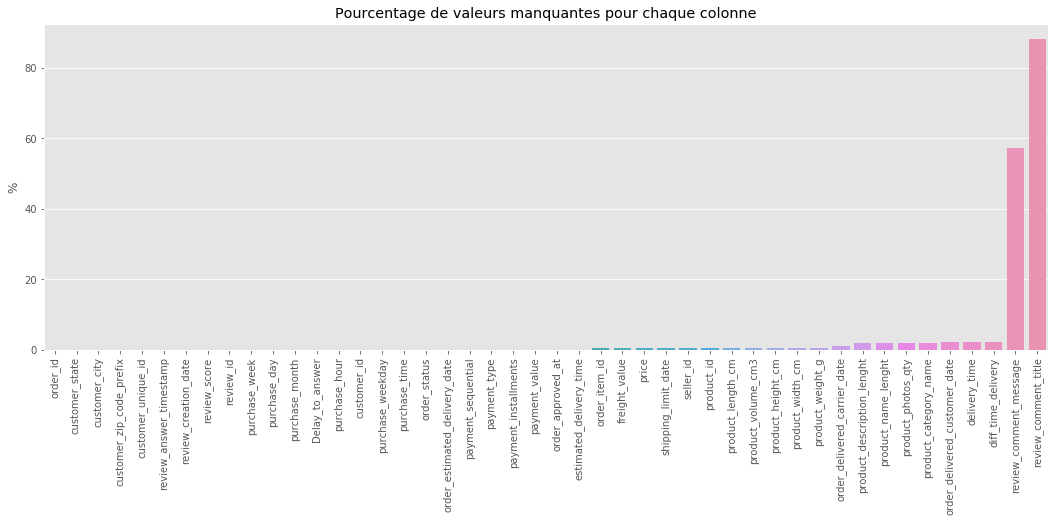

In [61]:
# Calcul des valeurs manquantes
null_prop = df.isna().sum(axis=0).sort_values()/len(df)*100

# Affiche la proportion de données manquants par colonne
fig = plt.figure(figsize=(18, 6))
sns.barplot(x=null_prop.index, y=null_prop.values)
plt.ylabel("%")
plt.title("Pourcentage de valeurs manquantes pour chaque colonne")
plt.style.use('ggplot')
plt.xticks(rotation=90)
plt.show()

#### Suppression des colonnes dont les données sont trop fortement manquantes

In [62]:
# Suppression des données dont les proportions renseignés sont <90%
cond = null_prop < 10
cond = cond[cond]
df = df.loc[:, cond.index]

#### Remplacement des valeurs datetime

In [63]:
date_columns = ['review_answer_timestamp',
                'review_creation_date',
                'order_delivered_carrier_date',
                'estimated_delivery_time',
                'shipping_limit_date']

In [64]:
df[date_columns] = df[date_columns].astype('datetime64[ns]')

In [65]:
date_columns = list(df.select_dtypes(include='datetime64[ns]').columns)

#### Remplacement des valeurs manquantes numériques

In [66]:
# Liste des colonnes numériques
num_columns = list(df.select_dtypes(include='float64').columns)
# Les valeurs manquantes pour chaque colonnes numérique
# sont remplacés par les moyennes des colonnes
df[num_columns] = SimpleImputer(strategy='mean').fit_transform(df[num_columns])

#### Remplacement des valeurs manquantes catégorielles

In [67]:
obj_columns = list(df.select_dtypes(include='object').columns)
cat_columns = []
for col in obj_columns:
    if '_id' not in col:
        cat_columns.append(col)
# Retypage des catégories en 'category'
df[cat_columns] = df[cat_columns].astype('category')

In [68]:
inputer_cat = SimpleImputer(strategy='most_frequent')
df[cat_columns] = inputer_cat.fit_transform(df[cat_columns])

### 2.2 Analyse multivariée

In [69]:
# Affichage des 5 premières lignes
df.head()

order_id customer_state customer_city  \
0  e481f51cbdc54678b7cc49136f2d6af7             SP     sao paulo   
1  e481f51cbdc54678b7cc49136f2d6af7             SP     sao paulo   
2  e481f51cbdc54678b7cc49136f2d6af7             SP     sao paulo   
3  53cdb2fc8bc7dce0b6741e2150273451             BA     barreiras   
4  47770eb9100c2d0c44946d9cf07ec65d             GO    vianopolis   

   customer_zip_code_prefix                customer_unique_id  \
0                      3149  7c396fd4830fd04220f754e42b4e5bff   
1                      3149  7c396fd4830fd04220f754e42b4e5bff   
2                      3149  7c396fd4830fd04220f754e42b4e5bff   
3                     47813  af07308b275d755c9edb36a90c618231   
4                     75265  3a653a41f6f9fc3d2a113cf8398680e8   

  review_answer_timestamp review_creation_date  review_score  \
0     2017-10-12 03:43:48           2017-10-11             4   
1     2017-10-12 03:43:48           2017-10-11             4   
2     2017-10-12 03:43:48           2017-10-11             4   
3     2018-08-08 18:37:50           2018-08-08             4   
4     2018-08-22 19:07:58           2018-08-18             5   

                          review_id  purchase_week  ...  product_width_cm  \
0  a54f0611adc9ed256b57ede6b6eb5114              0  ...              13.0   
1  a54f0611adc9ed256b57ede6b6eb5114              0  ...              13.0   
2  a54f0611adc9ed256b57ede6b6eb5114              0  ...              13.0   
3  8d5266042046a06655c8db133d120ba5              0  ...              19.0   
4  e73b67b67587f7644d5bd1a52deb1b01              0  ...              21.0   

   product_weight_g  order_delivered_carrier_date  product_description_lenght  \
0             500.0           2017-10-04 19:55:00                       268.0   
1             500.0           2017-10-04 19:55:00                       268.0   
2             500.0           2017-10-04 19:55:00                       268.0   
3             400.0           2018-07-26 14:31:00                       178.0   
4             420.0           2018-08-08 13:50:00                       232.0   

  product_name_lenght  product_photos_qty product_category_name  \
0                40.0                 4.0            housewares   
1                40.0                 4.0            housewares   
2                40.0                 4.0            housewares   
3                29.0                 1.0             perfumery   
4                46.0                 1.0                  auto   

  order_delivered_customer_date delivery_time  diff_time_delivery  
0           2017-10-10 21:25:13      8.429144           -7.107488  
1           2017-10-10 21:25:13      8.429144           -7.107488  
2           2017-10-10 21:25:13      8.429144           -7.107488  
3           2018-08-07 15:27:45     12.502292           -5.355729  
4           2018-08-17 18:06:29      9.382708          -17.245498  

[5 rows x 44 columns]

#### 2.2.1 Montant moyen et nombre de transactions

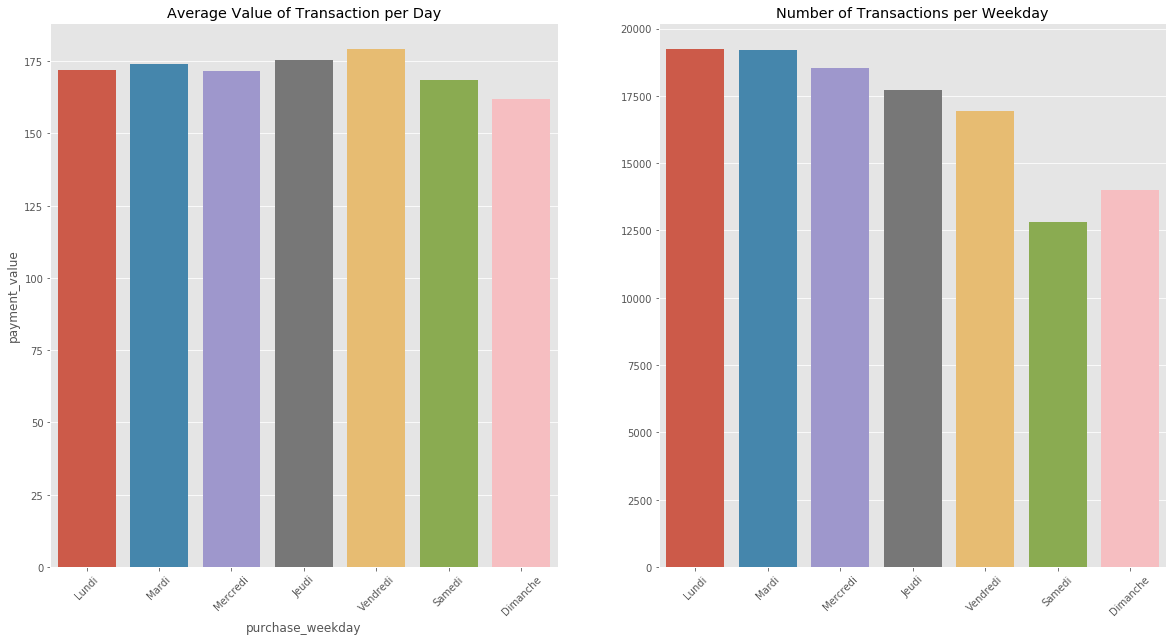

In [70]:
# Les données sont groupés par la variable 'purchase_weekday' et moyennés
payment_value_weekday = df.groupby("purchase_weekday")["payment_value"] \
                .mean().sort_values(ascending=False).reset_index()
order_weekday = df["purchase_weekday"].value_counts().sort_index()

# Jours de la semaine
WEEK = ["Lundi", "Mardi", "Mercredi",
        "Jeudi", "Vendredi", "Samedi", "Dimanche"]

fig = plt.figure(1, figsize=(20, 10))

# Bar plot du montant moyen dépensé pour chaque jour de la semaine
plt.subplot(121)
sns.barplot(data=payment_value_weekday, x="purchase_weekday",
            y="payment_value")
plt.title("Average Value of Transaction per Day")
plt.xticks(np.arange(7), WEEK, rotation=45)

# Bar plot du nombre de transactions pour chaque jour de la semaine
plt.subplot(122)
sns.barplot(x=order_weekday.index, y=order_weekday.values)
plt.xticks(np.arange(7), WEEK, rotation=45)
plt.title("Number of Transactions per Weekday")

plt.show()

- Le week-end il y'a  moins d'achats effectués que la semaine

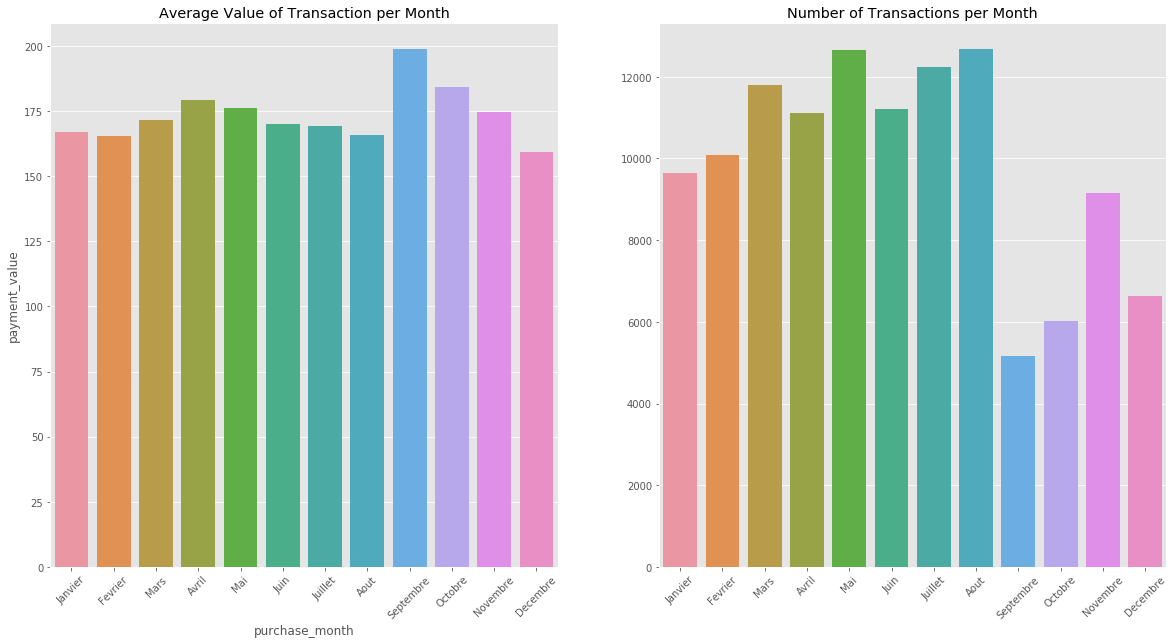

In [71]:
# Mois de l'année
MONTHS = ["Janvier", "Fevrier", "Mars", "Avril",
          "Mai", "Juin", "Juillet", "Aout",
          "Septembre", "Octobre", "Novembre", "Decembre"]

payment_value_month = df.groupby("purchase_month")["payment_value"] \
                    .mean().sort_values(ascending=False).reset_index()
order_month = df["purchase_month"].value_counts().sort_index()

fig = plt.figure(1, figsize=(20, 10))

# Bar plot de montant moyen dépensé pour chaque mois de l'année
plt.subplot(121)
sns.barplot(data=payment_value_month, x="purchase_month",
            y="payment_value")
plt.title("Average Value of Transaction per Month")
plt.xticks(np.arange(12), MONTHS, rotation=45)

# Bar plot du nombre de transactions pour chaque mois de l'année
plt.subplot(122)
sns.barplot(x=order_month.index, y=order_month.values)
plt.xticks(np.arange(12), MONTHS, rotation=45)
plt.title("Number of Transactions per Month")

plt.show()

- Septembre et Octobre sont des périodes creuses

- A partir de Novembre, les achats de fin d'année reviennent avec les fêtes

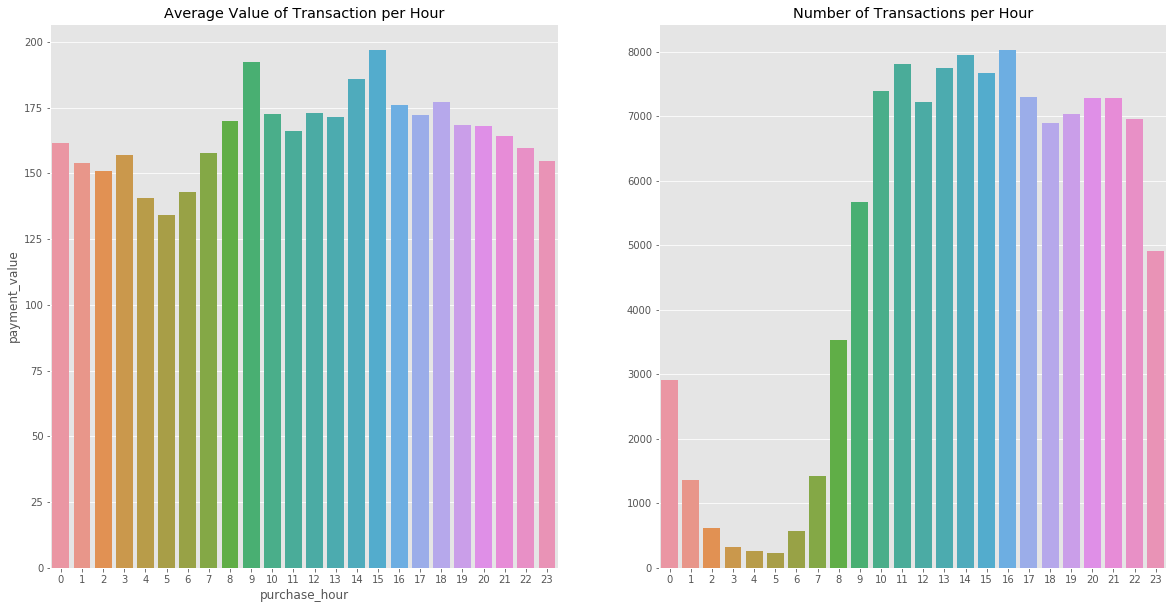

In [72]:
payment_value_hours = df.groupby("purchase_hour")["payment_value"] \
                    .mean().sort_values(ascending=False).reset_index()

order_hours = df["purchase_hour"].value_counts().sort_index()

fig = plt.figure(1, figsize=(20, 10))

# Bar plot du montant moyen dépensé pour chaque heure de la journée
plt.subplot(121)
sns.barplot(data=payment_value_hours, x="purchase_hour",
            y="payment_value")
plt.title("Average Value of Transaction per Hour")

# Bar plot du nombre de transactions pour chaque heure de la journée
plt.subplot(122)
sns.barplot(x=order_hours.index, y=order_hours.values)
plt.title("Number of Transactions per Hour")

plt.show()

- Il y a évidemment moins de payements la nuit que le jour

#### 2.2.2 Evaluation des produits

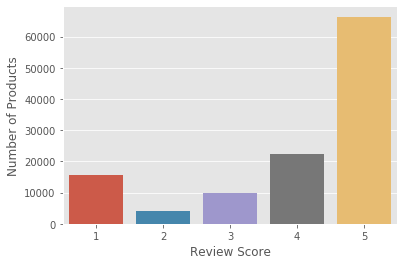

In [73]:
# Nombre de produits pour chaque note
review_score = df["review_score"].value_counts()
# bar plot du nombre de produits pour chaque note de 1 à 5
sns.barplot(review_score.index, review_score.values)
plt.ylabel("Number of Products")
plt.xlabel("Review Score")
plt.show()

- La majorité des produits sont notés 5 sur une échelle de 5

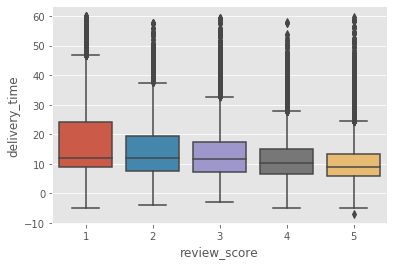

In [74]:
# Boxplot du temps de livraison pour chaque note
sns.boxplot(x="review_score", y="delivery_time",
            data=df[df["delivery_time"] < 60])
plt.show()

- Plus le temps d'attente est faible et plus l'évaluation du produit est bonne

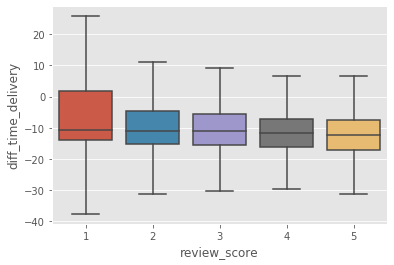

In [75]:
# Boxplot de la différence entre le temps de livraison réelle
# et estimé, pour chaque note du review score
sns.boxplot(x="review_score", y="diff_time_delivery",
            data=df[df["delivery_time"] < 60], showfliers=False)
plt.show()

- Plus un produit est livré plus tôt que son temps de livraison estimé et plus sa note est élevé

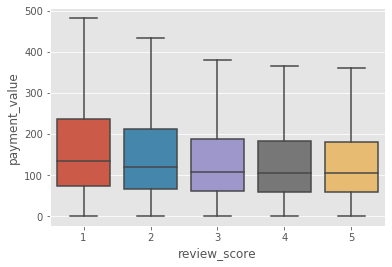

In [76]:
# Boxplot du payement effectué pour chaque note
sns.boxplot(x="review_score", y="payment_value", data=df, showfliers=False)
plt.show()

- Plus le prix de la transaction est faible et plus son évaluation est bonne

#### 2.2.3 Catégories des produits

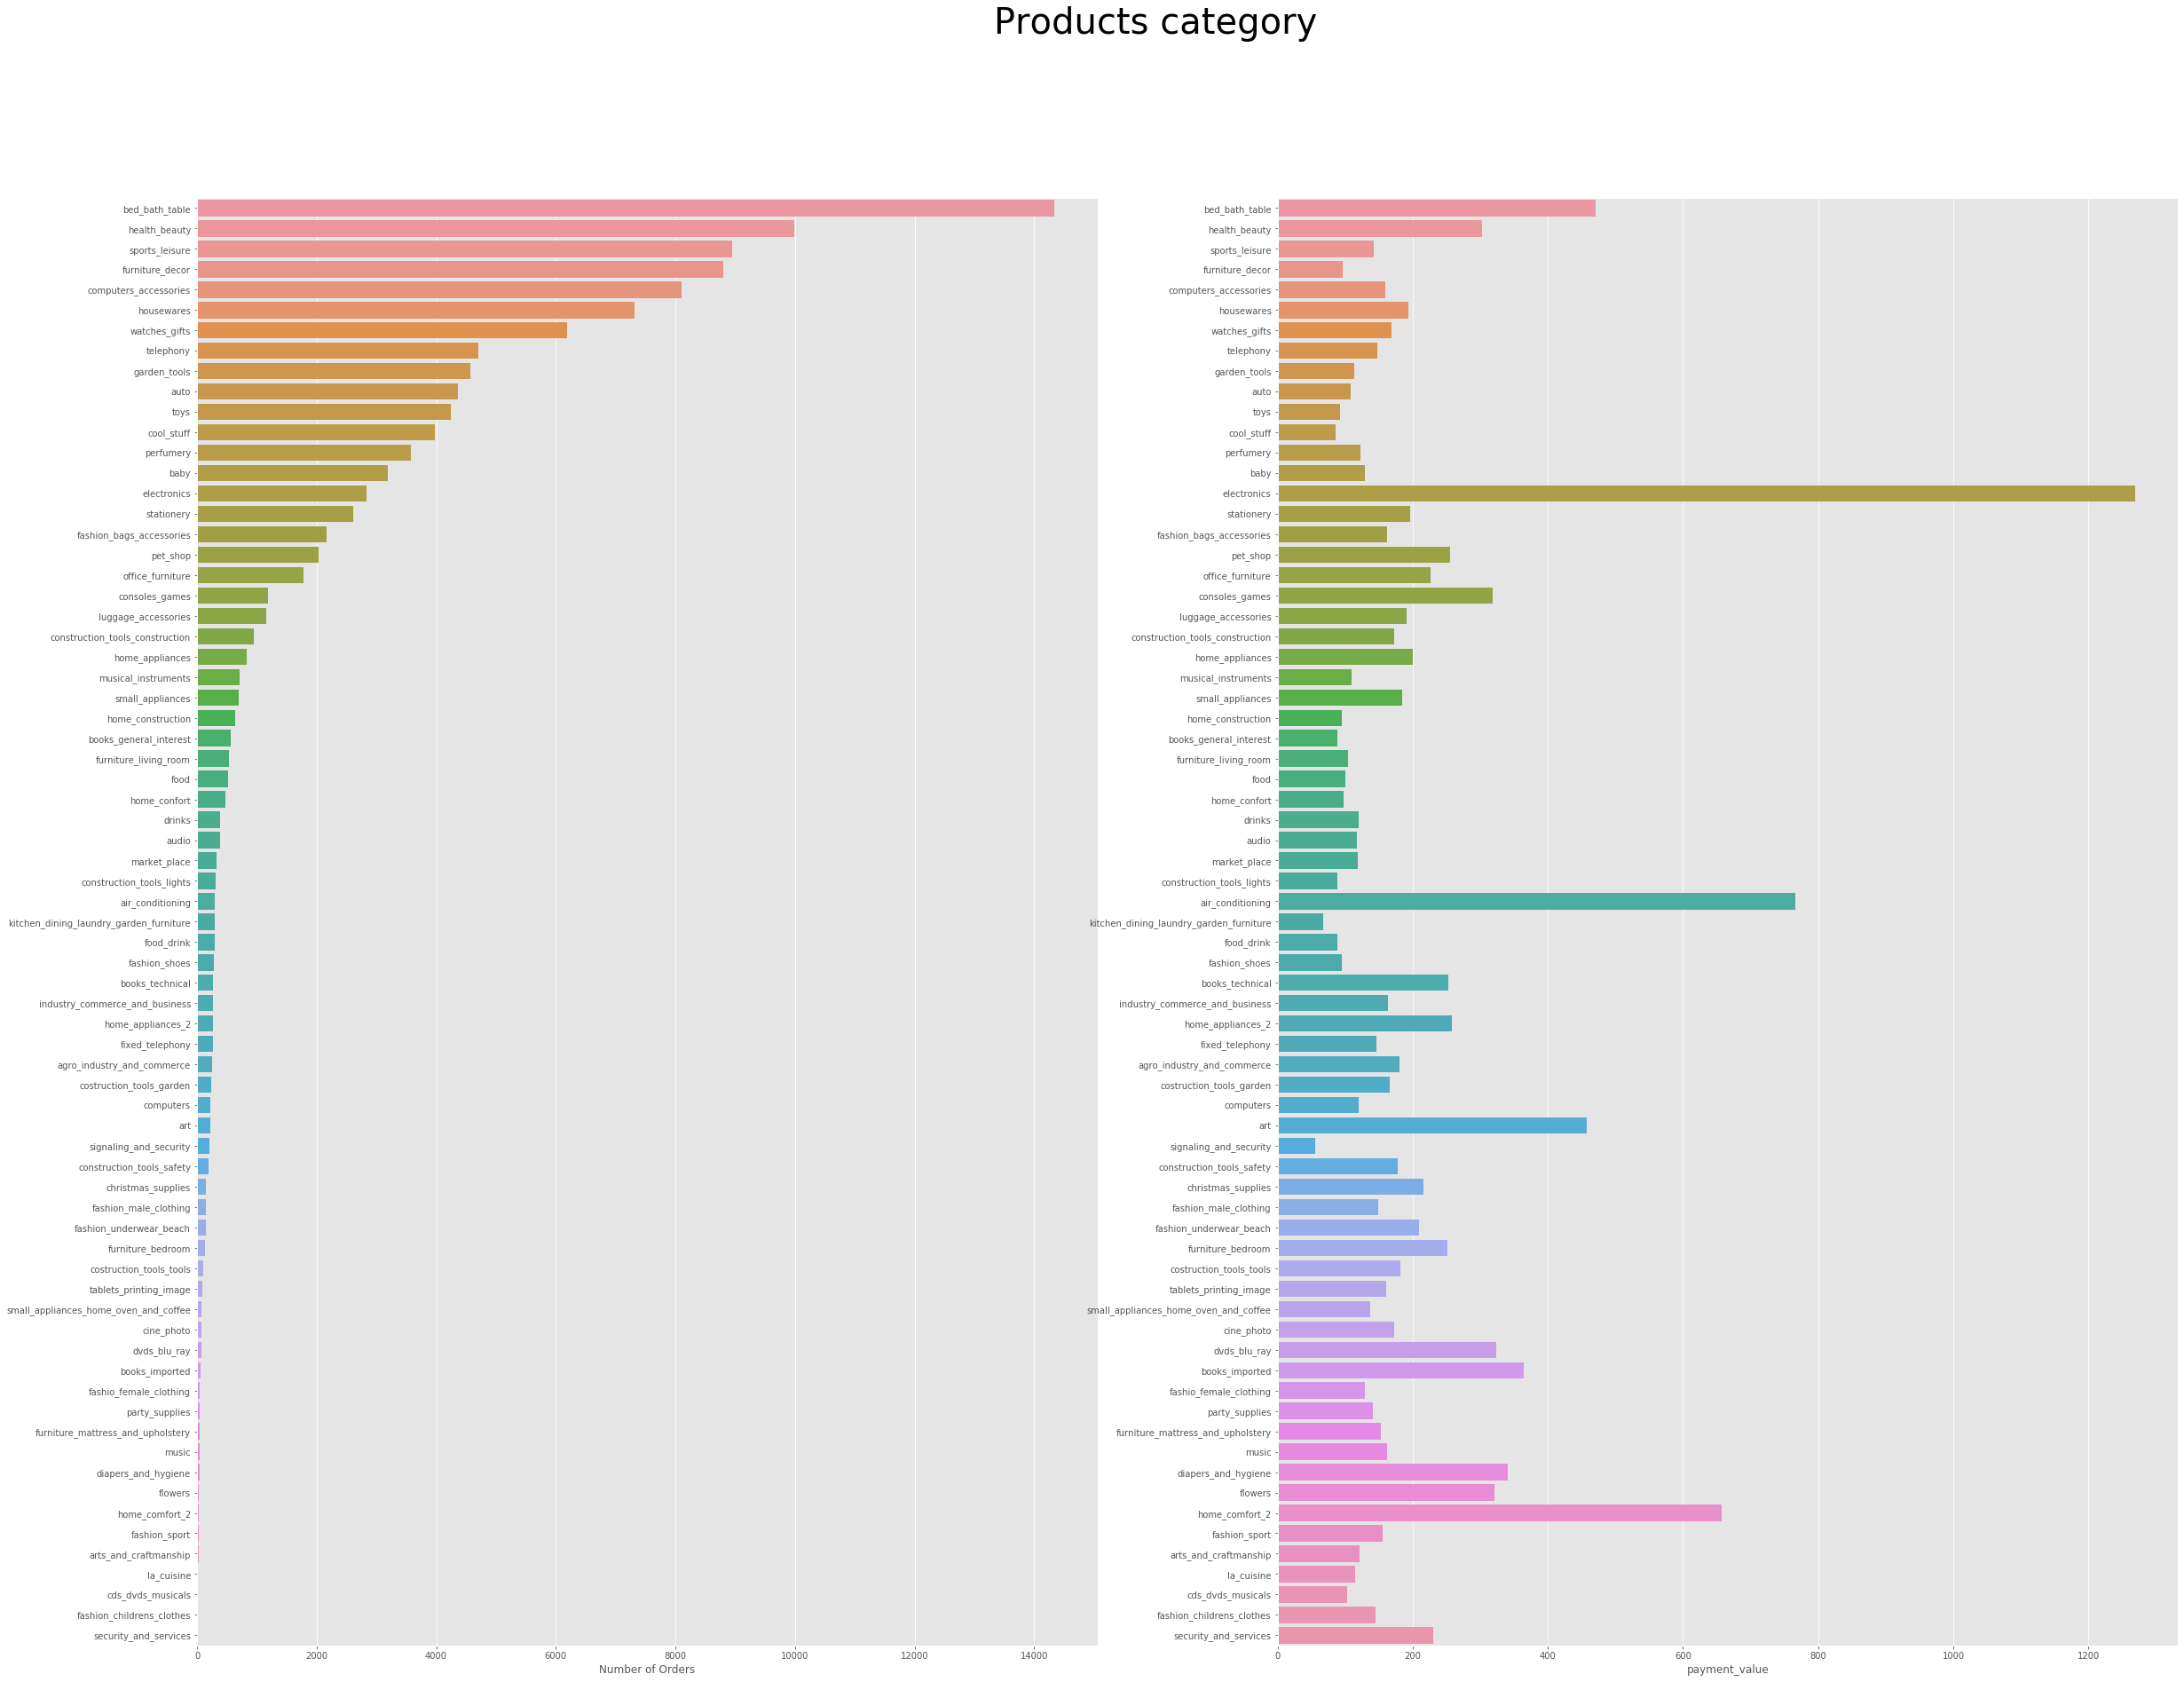

In [77]:
# Nombre de produits par catégorie de produits
products_count = df['product_category_name'].value_counts()

# Payement moyen pour chaque catégorie de produits
products_value = df.groupby("product_category_name")["payment_value"].mean()

# Liste des catégories
y = list(products_count.index)

fig = plt.figure(1, figsize=(40, 30))
# Nombre de produits achetés par catégorie
plt.subplot(121)
sns.barplot(products_count.values, y)
plt.xlabel("Number of Orders")

# Payement moyen par catégorie de produits
plt.subplot(122)
sns.barplot(products_value, y)
fig.suptitle("Products category", fontsize=40)
plt.show()

## 3. Segmentation RFM

Le principe de la segmentation RFM est mentionné au début du notebook

### 3.1 Calcul des variables R, F et M

On s'intèresse à une période d'une année entière, soit 365 jours

In [78]:
# On s'intèresse à une période d'une année entière, soit 365 jours
period = 365
# Séléction des variables permettant le calcul RFM
data = df[["customer_id", "purchase_time", "payment_value"]]
# Jour actuel : date de la dernière commande
today = data["purchase_time"].max() + timedelta(days=1)

Calcul des variables R, F et M

In [79]:
def calculate_rfm(data, period, today):
    """
    Calcul des valeurs R, F et M.

    ParamÃ¨tres:
    data(pd.DataFrame): doit contenir les colonnes 'payment_value',
    'purchase_time' et 'customer_id'
    period(int): Nombre de jours
    today(dt.datetime): date de fin de pÃ©riode

    Return:
    rfm(pd.DataFrame): retourne un pd.DataFrame avec les variables Recency,
    Frequency et Monetary
    """

    data = data.loc[data["purchase_time"] >= today - timedelta(days=period)]
    # Nombre de jours passés entre aujourd'hui
    # et la dernière commande de chaque utilisateur
    data.loc[:, "DaysSinceOrder"] = data.loc[:, "purchase_time"] \
                                        .map(lambda d: (today - d).days)

    aggr = {
            'DaysSinceOrder': lambda x: x.min(),
            # Nombre de jours depuis la dernière commande (Recency)
            'purchase_time': lambda x:
            len([d for d in x if d >= today - timedelta(days=period)]),
            # le nombre total de transactions sur la période passée (Frequency)
    }

    rfm = data.groupby('customer_id').agg(aggr).reset_index()
    rfm.rename(columns={'DaysSinceOrder': 'Recency',
                        'purchase_time': 'Frequency'},
               inplace=True)

    # Montant total de toutes les transactions sur la période définie
    rfm['Monetary'] = rfm.loc[:, 'customer_id'].apply(lambda x:
                              data.loc[data['customer_id'] ==
                                       x, 'payment_value'].sum())

    # Affichage des 5 premières lignes
    rfm.head()

    return rfm

In [80]:
# Calcul RFM, entre la date de la dernière commande
# et il y a 365 jours
rfm_1 = calculate_rfm(data, period, today)

C:\Users\maleg\Anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\maleg\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [81]:
# Affichage des 5 premières lignes
rfm_1.head()

customer_id  Recency  Frequency  Monetary
0  00012a2ce6f8dcda20d059ce98491703      293          1    114.74
1  000379cdec625522490c315e70c7a9fb      154          1    107.01
2  000419c5494106c306a97b5635748086      185          1     49.40
3  00046a560d407e99b969756e0b10f282      259          1    166.59
4  00050bf6e01e69d5c0fd612f1bcfb69c      351          1     85.23

##### Interprétation : 

- customer_id 00012a2ce6f8dcda20d059ce98491703 a fait son premier et dernier achat il y a 293 jours, pour un montant total de 114.74 R$
    
    
- customer_id 00050bf6e01e69d5c0fd612f1bcfb69c a fait son premier et dernier achat il y a 351 jours, pour un montant total de 85.23 R$

#### Description des données

In [82]:
# Description arithmétique des données
rfm_1.describe()

Recency     Frequency       Monetary
count  75324.000000  75324.000000   75324.000000
mean     177.921114      1.193763     208.199345
std       98.706620      0.703809     658.390769
min        1.000000      1.000000       9.590000
25%       95.000000      1.000000      63.227500
50%      178.000000      1.000000     111.320000
75%      265.000000      1.000000     196.990000
max      364.000000     38.000000  109312.640000

In [83]:
print("Le nombre de clients ayant commandé plus d'une fois est de : {:.2f} %"
      .format(100*sum(rfm_1["Frequency"] > 1)/len(rfm_1)))

Le nombre de clients ayant commandé plus d'une fois est de : 12.83 %


### 3.2 Analyse graphique des variables R, F et M

#### 3.2.1 Distribution en histogramme

In [84]:
def plot_hist(rfm, figsize=(20, 10)):

    plt.figure(1, figsize=figsize)

    for i, col in enumerate(rfm):
        plt.subplot(len(rfm.columns), 1, i + 1)
        plt.hist(rfm[col],
                 bins=int(1 + np.log2(len(rfm))),
                 label='skweness : ' + str(round(rfm[col].skew(), 2)),
                 density=True)
        plt.ylabel("Nombre de clients (%)")
        plt.xlabel(col)
        plt.legend()
    plt.show()

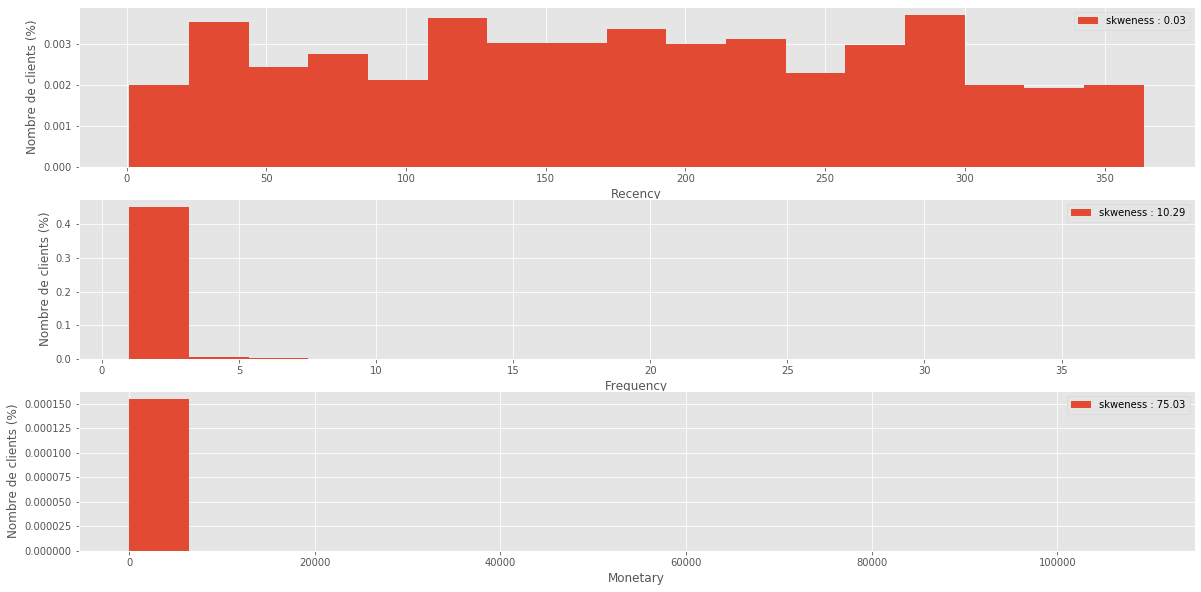

In [85]:
# Histogramme des variables 'Recency', 'Frequency' et 'Monetary'
plot_hist(rfm_1.drop(columns='customer_id'))

Les variables 'Frequency' et 'Monetary' présentent une forte asymétrie dont il est nécessaire de corriger. Une règle habituelle consiste à appliquer un logarithme aux variables dont le skewness est supérieur à 1 en valeur absolue. De ce fait, nous allons logarithmer les variables 'Frequency' et 'Monetary'.

In [86]:
# On applique le logarithme aux variables dont abs(skew)> 1
rfm_log_1 = rfm_1.copy()
rfm_log_1[["Frequency",
           "Monetary"]] = rfm_log_1[["Frequency",
                                     "Monetary"]].apply(lambda x:
                                                        np.log(1 + x))

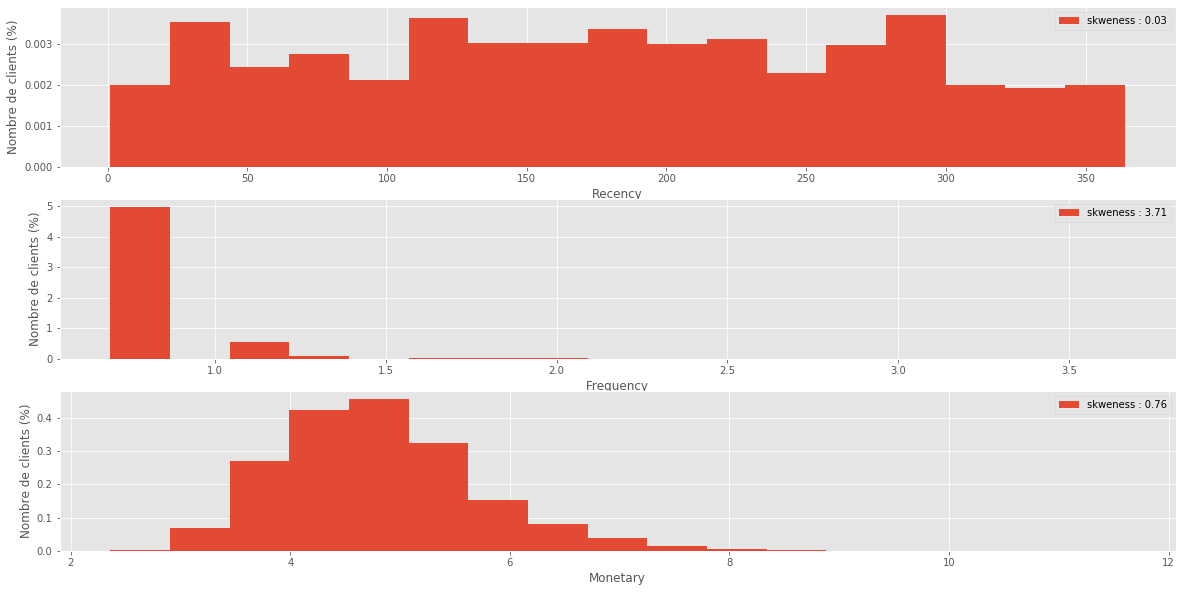

In [87]:
# Nouvelle distribution des variables logarithmés
plot_hist(rfm_log_1.drop(columns='customer_id'))

Les skewness des variables étudiés sont soit passés en dessous de 1 soit beaucoup plus proches de 1, ce qui montre l'efficacité de l'application du logarithme sur nos variables

#### 3.2.2 Boites à moustaches

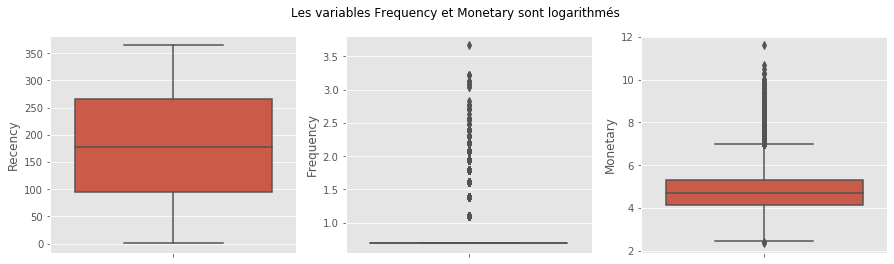

In [88]:
fig = plt.figure(1, figsize=(15, 4))

plt.suptitle("Les variables Frequency et Monetary sont logarithmés")

# Boxplot de la variable Recency
plt.subplot(131)
sns.boxplot(rfm_log_1["Recency"], orient="vertical")

# Boxplot de la variable Frequency
plt.subplot(132)
sns.boxplot(rfm_log_1["Frequency"], orient="vertical")

# Boxplot de la variable Monetary
plt.subplot(133)
sns.boxplot(rfm_log_1["Monetary"], orient="vertical")
plt.show()

In [89]:
print("L'essentiel des montants se situe autour de la médiane qui est de {}. \n"
      "Pour la fréquence la très grande majorité des clients ont commandé soit 0 ou 1 fois."
      .format(rfm_1["Monetary"].median(), rfm_1["Frequency"].median()))

L'essentiel des montants se situe autour de la médiane qui est de 111.32. 
Pour la fréquence la très grande majorité des clients ont commandé soit 0 ou 1 fois.


### 3.3 Méthode 1 : RFM Score

La méthode 1 consiste à quantiliser chaque segment RFM de manière à obtenir un score entre 1 et 5 pour chaque variable R, F et M.

En fonction de chaque score obtenu, le client sera attribué dans une catégorie.

#### Calcul des quantiles

In [90]:
def r_score(x, quintiles):
    """
    Attribut une note entre 1 et 5 suivant l'emplacement de x par
    rapport aux quintiles. Plus la 'Recency' est faible, plus la note
    est élevé
    x(float): valeur
    quintiles(dict): voir fonction calculQuantile
    """

    if x <= quintiles['Recency'][.2]:
        return 5
    elif x <= quintiles['Recency'][.4]:
        return 4
    elif x <= quintiles['Recency'][.6]:
        return 3
    elif x <= quintiles['Recency'][.8]:
        return 2
    else:
        return 1


def fm_score(x, quintiles, c):
    """
    Attribut une note entre 1 et 5 suivant l'emplacement de x par
    rapport aux quintiles. Plus x est grand, plus la note est grande
    x(float): valeur
    quintiles(dict): voir fonction calculQuantile
    """

    if x <= quintiles[c][.2]:
        return 1
    elif x <= quintiles[c][.4]:
        return 2
    elif x <= quintiles[c][.6]:
        return 3
    elif x <= quintiles[c][.8]:
        return 4
    else:
        return 5


def calculate_quantile(rfm):
    """
    Calcul des quantiles pour chaque variable Recency, Frequency et Monetary
    puis attribut un score (fm_score et r_score) suivant la valeur
    des variables de chaque individu
    rfm(pd.DataFrame): présente les colonnes 'Recency', 'Frequency' et Monetary
    """
    quintiles = rfm[['Recency',
                     'Frequency',
                     'Monetary']].quantile([.2, .4, .6, .8]).to_dict()

    rfm['R'] = rfm['Recency'].apply(lambda x:
                                    r_score(x, quintiles))
    rfm['F'] = rfm['Frequency'].apply(lambda x:
                                      fm_score(x, quintiles, 'Frequency'))
    rfm['M'] = rfm['Monetary'].apply(lambda x:
                                     fm_score(x, quintiles, 'Monetary'))
    return rfm

In [91]:
# Calcul des quantiles
rfm_table_1 = calculate_quantile(rfm_1)

#### Calcul des segments et des scores


Chaque client est caractérisé en fonction de la note pour chaque variable R, F M qui le caractérise

9 segments sont définis : 
 - Champions : achats récents, achète souvent et dépense beaucoup
 - Loyal Customers : achètent régulièrement, sensibles aux promotions
 - Potential Loyalist : nouveaux clients avec fréquence d'achat moyenne
 - Recent Customers : achats récents, mais peu fréquents
 - Promising : nouveaux acheteurs, mais peu dépensiers
 - Need Attention : dépenses moyennes, moyennement fréquemment, achat moyennement récent
 - About to Sleep : client qui tendent à disparaitre
 - Can't Lose Them : achètaient régulièrement, besoin de les faire revenir
 - At Risk : dépensaient beaucoup, achetaient souvent mais il y a lomgtemps
 - Lost : peu dépensiers, peu fréquements, a acheté il y a un moment
 - Others : pas catégorisable

In [92]:
# Etiquette des catégories pour la méthodologie 1
categories_1 = ["Champions",
                "Loyal Customers",
                "Potential Loyalist",
                "Recent Customers",
                "Promising",
                "Need Attention",
                "About to Sleep",
                "Can't Lose Them",
                "At Risk",
                "Lost",
                "Others"]

In [93]:
def calculate_segments(rfm):
    """
    Retourne le segment associé au client en fonction de son score pour les
    variables R, F et M

    Paramètres:
    rfm(pd.DataFrame): doit contenir les colonnes R, F et M

    Return:
    str: Nom du segment
    """

    if 4 <= rfm["R"] <= 5 and 4 <= rfm["F"] <= 5 and 4 <= rfm["M"] <= 5:
        return "Champions"

    elif 3 <= rfm["R"] <= 5 and 3 <= rfm["F"] <= 5 and 2 <= rfm["M"] <= 5:
        return "Loyal Customers"

    elif 3 <= rfm["R"] <= 5 and 1 <= rfm["F"] <= 3 and 1 <= rfm["M"] <= 3:
        return "Potential Loyalist"

    elif rfm["R"] >= 4 and rfm["F"] <= 2:
        return "Recent Customers"

    elif 3 <= rfm["R"] <= 4 and rfm["F"] <= 1 and rfm["M"] <= 1:
        return "Promising"

    elif 2 <= rfm["R"] <= 3 and 2 <= rfm["F"] <= 3 and 2 <= rfm["M"] <= 3:
        return "Need Attention"

    elif 2 <= rfm["R"] <= 3 and rfm["F"] <= 2 and rfm["M"] <= 2:
        return "About to Sleep"

    elif rfm["R"] <= 1 and 4 <= rfm["F"] <= 5 and 4 <= rfm["M"] <= 5:
        return "Can't Lose Them"

    elif rfm["R"] <= 2 and 2 <= rfm["F"] <= 5 and 2 <= rfm["M"] <= 5:
        return "At Risk"

    elif rfm["R"] <= 2 and rfm["F"] <= 2 and rfm["M"] <= 2:
        return "Lost"

    else:
        return "Others"

#### Attribution des catégories

In [94]:
# RFM Score
rfm_table_1["RFM Score"] = rfm_table_1.apply(calculate_segments, axis=1)

#### Apperçu des résultats

In [95]:
# Affiche les 5 premières lignes
rfm_table_1.head()

customer_id  Recency  Frequency  Monetary  R  F  M  \
0  00012a2ce6f8dcda20d059ce98491703      293          1    114.74  1  1  3   
1  000379cdec625522490c315e70c7a9fb      154          1    107.01  3  1  3   
2  000419c5494106c306a97b5635748086      185          1     49.40  3  1  1   
3  00046a560d407e99b969756e0b10f282      259          1    166.59  2  1  4   
4  00050bf6e01e69d5c0fd612f1bcfb69c      351          1     85.23  1  1  2   

            RFM Score  
0              Others  
1  Potential Loyalist  
2  Potential Loyalist  
3              Others  
4                Lost

#### Résumé des résultats de la segmentation

In [96]:
# Liste des fonctions d'aggrégation
func = ['count', 'min', 'mean', 'median', 'max', 'std']
# Regroupement des données
qtd_preco = rfm_table_1.groupby(['RFM Score'])
# Aggrégation des données par différentes fonctions
summery_table = qtd_preco[['Recency', 'Frequency', 'Monetary']].agg(func)
# Affichage de la table de résumé
summery_table

Recency                                         Frequency  \
                     count  min        mean median  max        std     count   
RFM Score                                                                      
About to Sleep        5821  210  244.152723    240  279  21.474428      5821   
At Risk               2112  210  255.061553    247  364  35.004243      2112   
Can't Lose Them       1668  280  313.146283    309  364  26.066344      1668   
Champions             3030    5   79.731683     82  145  40.604214      3030   
Lost                  5937  280  315.135927    313  364  26.691444      5937   
Loyal Customers       2404    6  155.537854    168  209  48.406087      2404   
Others               19199    7  253.752383    259  364  60.309724     19199   
Potential Loyalist   25906    5  109.937505    114  209  59.775741     25906   
Recent Customers      9247    1   77.128150     77  145  40.742247      9247   

                                                      Monetary          \
                   min      mean median max       std    count     min   
RFM Score                                                                
About to Sleep       1  1.000000      1   1  0.000000     5821   13.78   
At Risk              2  2.446970      2  21  1.243469     2112   55.54   
Can't Lose Them      2  2.619305      2  38  1.655599     1668  138.65   
Champions            2  2.552475      2  24  1.348141     3030  138.10   
Lost                 1  1.000000      1   1  0.000000     5937   10.07   
Loyal Customers      2  2.459235      2  24  1.279663     2404   55.34   
Others               1  1.032606      1  22  0.291168    19199    9.59   
Potential Loyalist   1  1.000000      1   1  0.000000    25906   10.89   
Recent Customers     1  1.000000      1   1  0.000000     9247  138.03   

                                                                 
                          mean   median        max          std  
RFM Score                                                        
About to Sleep       54.931355   55.090      88.81    18.486725  
At Risk             487.475952  262.300   21874.05  1002.593765  
Can't Lose Them     825.821193  380.985  109312.64  3133.865577  
Champions           726.712281  399.580   30186.00  1378.327979  
Lost                 56.399936   57.000      88.89    18.106276  
Loyal Customers     489.854463  233.100   44048.00  1256.297786  
Others              235.521345  168.200    4175.26   234.736844  
Potential Loyalist   73.745089   69.410     137.99    31.700067  
Recent Customers    303.776762  204.410    6922.21   307.670764

#### Radar Chart des différentes catégories

In [97]:
def radar_plot(rfm_table,
               label_score,
               colors,
               sub_plot=[3, 3],
               figsize=(36, 18)):

    """
    Pour chaque cluster/segments, trace un radar chart représentant
    la moyenne des individus pour les variables Recency, Monetary
    et Frequency, ainsi que le nombre d'individus dans le cluster/segment
    en question.
    rfmTable(pd.DataFrame): Table de résultats, doit contenir
    les 3 variables Recency, Frequency et Monetary
    ainsi que la colonne avec les segments de chaque individu
    label_score: nom de la segmentation
    colors(list): code couleur
    """

    # Aggrégation par moyenne des valeurs par segment
    df_plot = rfm_table.groupby([label_score]).agg("mean")

    # Transformation MinMax -> [0, 1]
    df_plot_std = pd.DataFrame(MinMaxScaler().fit_transform(df_plot),
                           columns=list(df_plot.columns),
                           index=df_plot.index)

    # Noms des variables
    categories = list(df_plot.columns)
    # Nombre de variables
    N = len(categories)

    # Quel sera l'angle de chaque axe ?
    # On divise un tour complet par le nombre de variables
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    fig = plt.figure(1, figsize=figsize)

    # Trace un radar chart pour chaque segment
    for i, segment in enumerate(rfm_table[label_score].unique()):

        ax = fig.add_subplot(sub_plot[0], sub_plot[1], i + 1, polar=True)

        ax.set_theta_offset(pi / 2)
        ax.set_theta_direction(-1)
        ax.set_rlabel_position(0)

        # Draw one axe per variable + add labels labels yet
        plt.yticks(color="grey", size=2)
        values = list(df_plot_std.loc[segment].values)
        values += values[:1]
        ax.plot(angles, values, colors[segment],
                'o-', linewidth=2, linestyle='solid')
        ax.fill(angles, values, colors[segment], alpha=0.25)
        ax.set_xticks(angles)
        ax.set_xticklabels(categories, size=15)
        plt.yticks([-1, -0.5, 0, 0.5, 1],
                   ["-1", "-0.5", "0", "0.5", "1"],
                   color="black",
                   size=12)
        ax.set_title(segment, size=15, color=colors[segment])
        ax.grid(True)
        plt.ylim(-1, 1)

    plt.show()

In [98]:
# Liste des couleurs pour chaque segment
palette_1 = sns.color_palette("husl", len(categories_1))
colors_1 = {label: color for label, color in zip(categories_1,
                                                 palette_1.as_hex())}

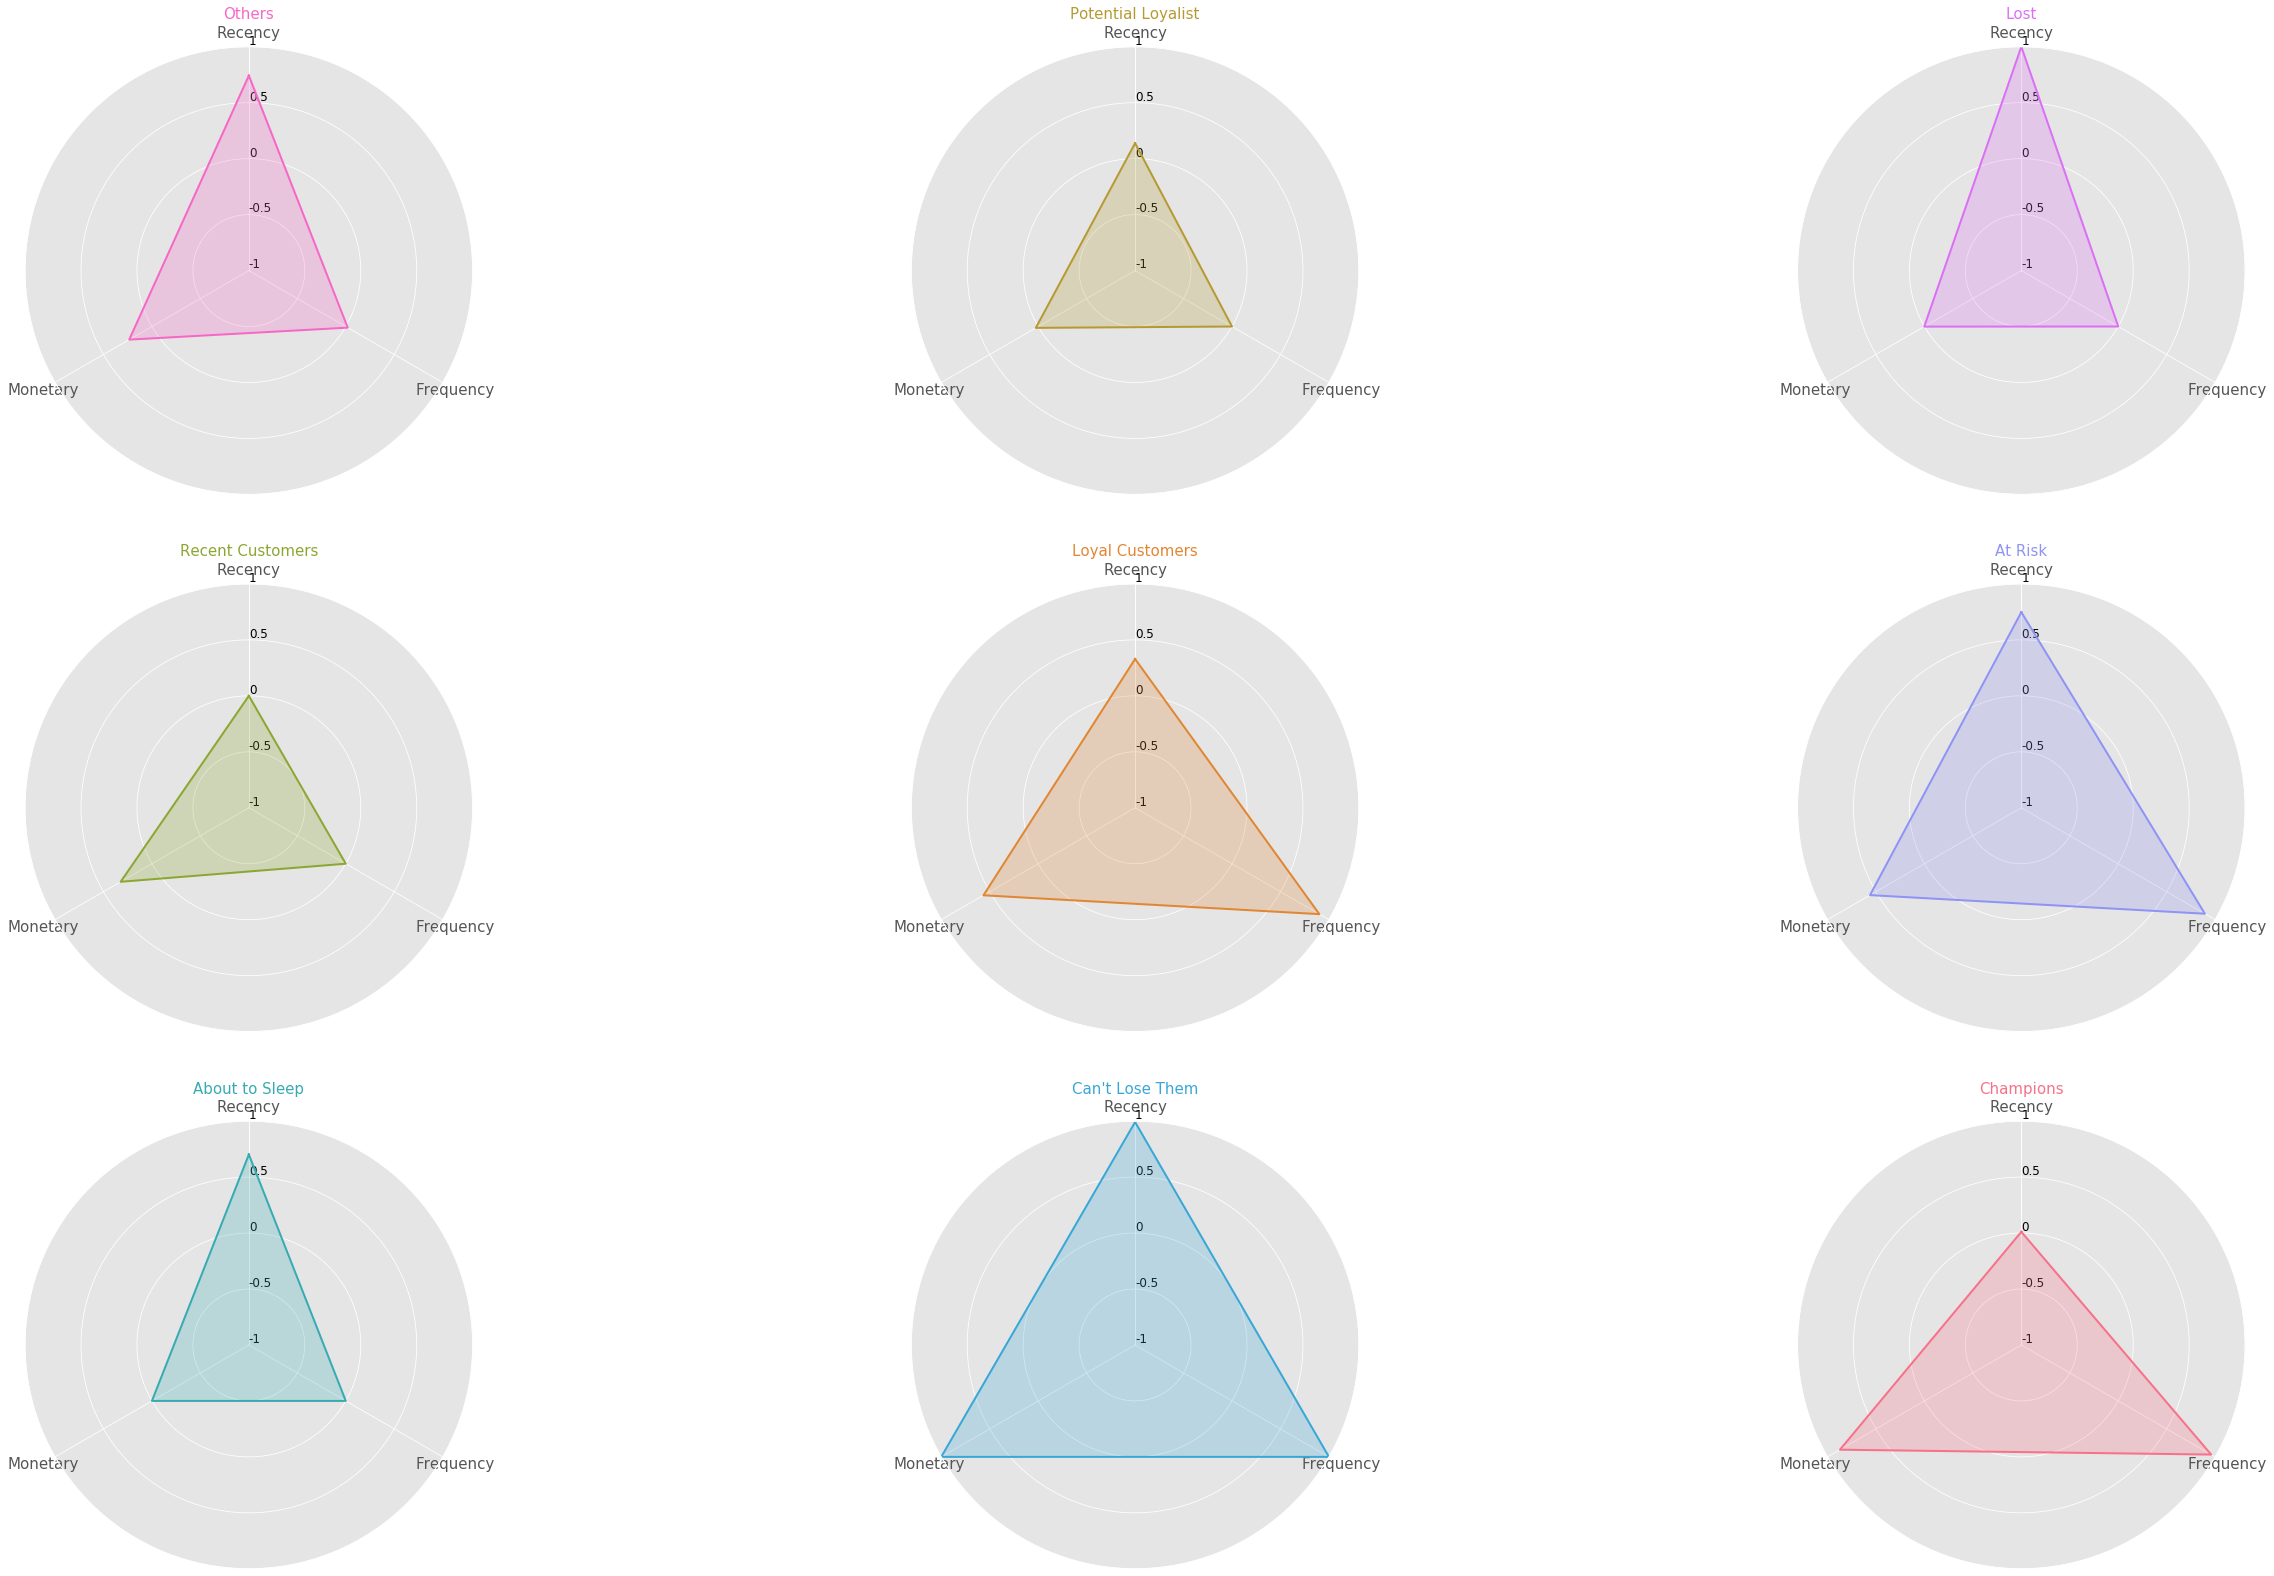

In [99]:
# Radar plot pour la segmentation
radar_plot(rfm_table_1.drop(columns=["R", "F", "M", 'customer_id']),
           'RFM Score',
           colors_1,
           sub_plot=[3, 3],
           figsize=(45, 28))

c.f la partie Calcul des segments et des scores pour lier le radar chart au descriptif de chaque segment

#### Visualisation graphique 3d des différents clients associés à leur catégorie

In [100]:
def projection_3d_segments(rfm_table, label_score, colors) :
    """
    Graphique montrant les différents clients associés à leur segment/cluster respectif
    rfmTable(pd.DataFrame): Table de résultats
    label_score(str): nom de la segmentation
    colors(list): liste de couleurs

    """
    fig = plt.figure(1, figsize=(18, 8))

    dx = fig.add_subplot(111, projection='3d')
    # Pour chaque segment, scatter plot des individus avec code couleur
    for i, segment in enumerate(rfm_table[label_score].unique()):
        dx.scatter(rfm_table[rfm_table[label_score] == segment].Recency,
                   rfm_table[rfm_table[label_score] == segment].Frequency,
                   rfm_table[rfm_table[label_score] == segment].Monetary,
                   label=segment,
                   s=50,
                   c=colors[segment])
    # Titre des axes et titre graphique
    dx.set_xlabel("Recency")
    dx.set_ylabel("Frequency")
    dx.set_zlabel("Monetary")
    plt.title("Représentation 3D des différents individus dans chaque segment")

    plt.legend()
    plt.show()

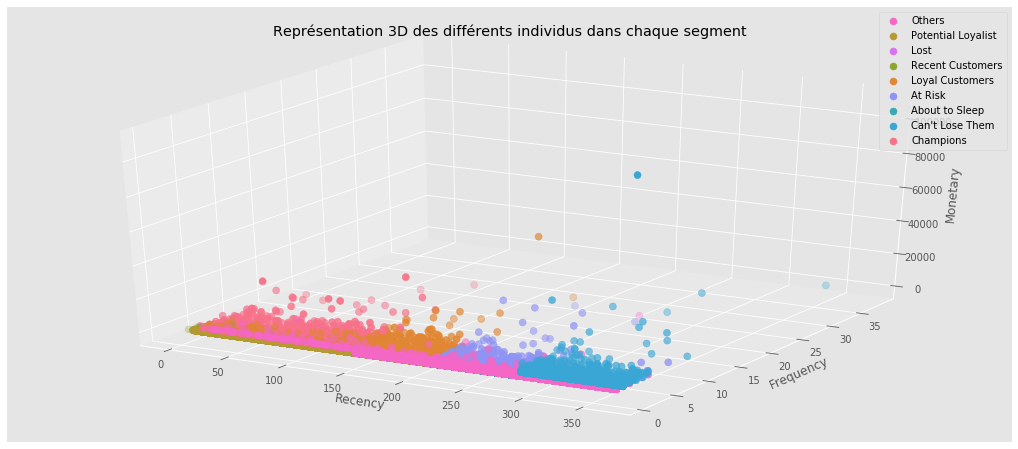

In [101]:
# Graphique 3D (x, y, z) = (Recency, Frequency, Monetary)
projection_3d_segments(rfm_table_1, 'RFM Score', colors_1)

On visualise graphiquement ici la nature très rectiligne de la segmentation

In [102]:
def projection_2d_segments(rfm_table, xlabel, ylabel, label_score, colors) :
    """
    2D scatter plot
    data(pd.DataFrame): contient les 3 colonnes xlabel, ylabel et label_score
    xlabel(str): nom colonne data pour l'axe des x
    ylabel(str): nom colonnne data pour l'axe des y
    label_score: nom méthodologie de la segmentation
    """
    # Pour chaque segment, scatter plot
    for i, segment in enumerate(rfm_table[label_score].unique()):
        plt.scatter(rfm_table[rfm_table[label_score] == segment][xlabel],
                    rfm_table[rfm_table[label_score] == segment][ylabel],
                    label=segment,
                    c=colors[segment]
                   )
    # Titre des axes
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

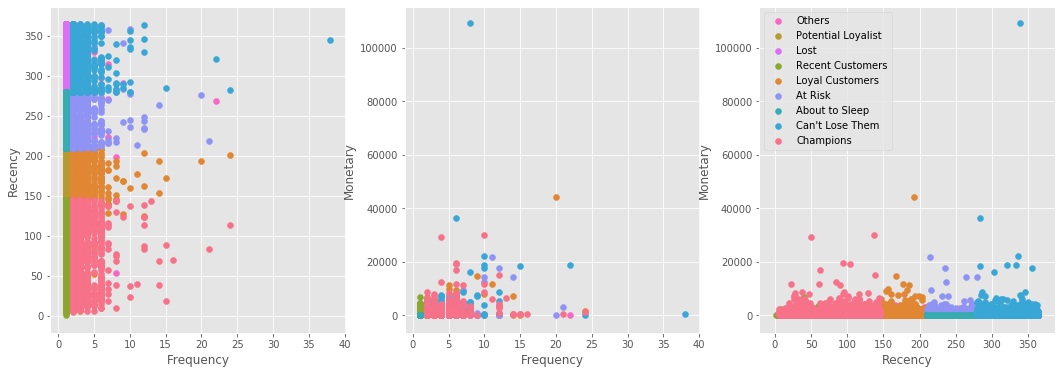

In [103]:
plt.figure(1, figsize=(18, 6))

# 2D plot, Frequency vs Recency
plt.subplot(1, 3, 1)
projection_2d_segments(rfm_table_1,
                       "Frequency",
                       "Recency",
                       "RFM Score",
                       colors=colors_1)

# 2D plot, Frequency vs Monetary
plt.subplot(1, 3, 2)
projection_2d_segments(rfm_table_1,
                       "Frequency",
                       "Monetary",
                       "RFM Score",
                       colors=colors_1)

# 2D plot, Frequency vs Monetary
plt.subplot(1, 3, 3)
projection_2d_segments(rfm_table_1,
                       "Recency",
                       "Monetary",
                       "RFM Score",
                       colors=colors_1)

plt.legend()
plt.show()

### 3.4 Méthode 2 : Segmentation par clusterisation

#### Méthodologie :
   - 1. Normalisation des données
   - 2. Clusterisation des données par k-means
   - 3. Choisir le nombre de clusters
   - 4. Etiquetter les clusters

####  Méthodes pour définir le nombre de clusters

- Méthode visuelle :  Critère d'Elbow

- Méthode mathématique : Coefficient de Silhouette

- Expérimentation et interprétation


##### Critère d'Elbow :

- Afficher le nombre de clusters vs la somme des distances quadratiques de tous les points au centre de leurs clusters

- Identifier un "elbow" (coude) dans le graphique

- Elbow - un point représentant le nombre optimal de clusters

<img src="wcss.png">

##### Coefficient de silhouette

En partitionnement de données (clustering), le coefficient de silhouette est une mesure de qualité d'une partition d'un ensemble de données en classification automatique. 

Pour chaque point, son coefficient de silhouette est la différence entre la distance moyenne avec les points du même groupe que lui (cohésion) et la distance moyenne avec le points des autres groupes voisins (séparation). Si cette différence est négative, le point est en moyenne plus proche du groupe voisin que du sien : il est donc mal classé. A l'inverse, si cette différence est positive, le point est en moyenne plus proche de son groupe que du groupe voisin : il est donc bien classé.

Le coefficient de silhouette proprement dit est la moyenne du coefficient de silhouette pour tous les points. Il varie de -1 (pire classification) à 1 (meilleur classification)


<img src="silhouette.png">

#### 3.4.1 Normalisation des données 

In [216]:
# Encodeur par normalisation
encoder = StandardScaler()

# Normalisation des données
x_transformed_1 = encoder.fit_transform(
    rfm_log_1[["Recency", "Frequency", "Monetary"]])

# Convertis les données en DataFrame
rfm_std_1 = pd.DataFrame(x_transformed_1,
                         index=rfm_1.index,
                         columns=["Recency", "Frequency", "Monetary"])

#### 3.4.2 Clusterisation avec k-means

Dans cette partie, nous allons déterminer quel est le nombre de clusters qui nous permet d'avoir les meilleurs résultats.

In [115]:
def gini(Y, X=None):
    """
    Computes the
    `Gini coefficients <https://en.wikipedia.org/wiki/Gini_coefficient>`_.

    :param Y: Y values (or revenues)
    :param X: None for a uniform population or not None for already order value
    :return: a curve ``(x, Gini(x))``


    :githublink:`%|py|16`
    """
    n = len(Y)
    couples = np.empty((n, 2))
    if X is None:
        couples[:, 0] = 1
    else:
        couples[:, 0] = X
    couples[:, 1] = Y
    couples = np.cumsum(couples, axis=0)
    couples[:, 0] /= max(couples[n - 1, 0], 1e-7)
    couples[:, 1] /= max(couples[n - 1, 1], 1e-7)

    g = 0.
    n = couples.shape[0]

    for i in range(0, n):
        dx = couples[i, 0] - couples[i - 1, 0]
        y = couples[i - 1, 1] + couples[i, 1]
        g += dx * y

    return (1. - g) / 2

In [217]:
%%flake8
def clustering_rfm(rfm, range_n_clusters):
    """
    Cette fonction teste pour différents nombre de clusters,
    un clustering des données par la méthode k-means.
    La fonction affiche le score de silhouette pour chacun des clusters,
    ainsi que la répartition des données dans l'espace RFM
    et leurs codes couleurs associés en fonction de leur appartenance
    aux différents clusters déterminés.

    Parametres:
    rfm (pd.DataFrame): DataFrame avec 3 colonnes nommés :
    Recency, Frequency and Monetary

    Return :
    list: Liste des valeurs d'intertie pour différents nombre de clusters
    """

    # Liste des valeurs d'inertie
    wcss = []
    # Temps d'entrainement
    fit_predict_time = []
    # Score de silhouette
    silhouette_score_avg = []
    # Score de gini
    ginis = []

    palette = sns.color_palette("husl", max(range_n_clusters))
    colors = palette.as_hex()

    rfm_ = rfm.copy()

    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig = plt.figure(1, figsize=(18, 7))
        ax1 = fig.add_subplot(121)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example
        # all lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(rfm) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, init='k-means++',
                           random_state=10)
        start_time = time.time()
        cluster_labels = clusterer.fit_predict(rfm)
        time.time() - start_time

        fit_predict_time.append(time.time() - start_time)
        wcss.append(clusterer.inertia_)
        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation
        # of the formed clusters
        silhouette_score_avg.append(silhouette_score(rfm, cluster_labels))

        # Nombre d'invididus dans chaque cluster
        counts = [list(cluster_labels).count(i) for i in range(6)]
        ginis.append(gini(counts))

        # Compute the silhouette scores for each sample
        sample_silh_values = silhouette_samples(rfm, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silh_values = sample_silh_values[cluster_labels == i]

            ith_cluster_silh_values.sort()

            size_cluster_i = ith_cluster_silh_values.shape[0]
            y_upper = y_lower + size_cluster_i

            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0,
                              ith_cluster_silh_values,
                              facecolor=colors[i],
                              edgecolor=colors[i],
                              alpha=0.7)

            # Label the silhouette plots with
            # their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_score_avg[-1], color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        dx = fig.add_subplot(122, projection='3d')

        rfm_["clusters"] = cluster_labels
        for i in range(n_clusters):
            dx.scatter(rfm_[rfm_.clusters == i].Recency,
                       rfm_[rfm_.clusters == i].Frequency,
                       rfm_[rfm_.clusters == i].Monetary,
                       c=colors[i],
                       label='Cluster ' + str(i+1),
                       s=50)

            # Labeling the clusters
            centers = clusterer.cluster_centers_
            # Draw white circles at cluster centers
            dx.scatter(centers[:, 0],
                       centers[:, 1],
                       centers[:, 2],
                       marker='o',
                       c="white",
                       alpha=1,
                       s=200,
                       edgecolor='k')

            for i, c in enumerate(centers):
                dx.scatter(c[0],
                           c[1],
                           c[2],
                           marker='$%d$' % i,
                           alpha=1,
                           s=50,
                           edgecolor='k')
        # Titres des axes
        dx.set_xlabel("Recency")
        dx.set_ylabel("Frequency")
        dx.set_zlabel("Monetary")

        plt.suptitle(("Silhouette analysis for k-means clustering "
                      "on sample data with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

        plt.show()

        print("Pour n_clusters =", n_clusters, "\n",
              "Le silhouette score moyen est de :",
              round(silhouette_score_avg[-1], 2), "\n",
              "Le temps d'entrainement du modèle est de :",
              round(fit_predict_time[-1], 2), '(s) \n',
              "Le score de Gini est de :", round(ginis[-1], 2))

    return wcss, silhouette_score_avg, ginis, fit_predict_time  # Inertie

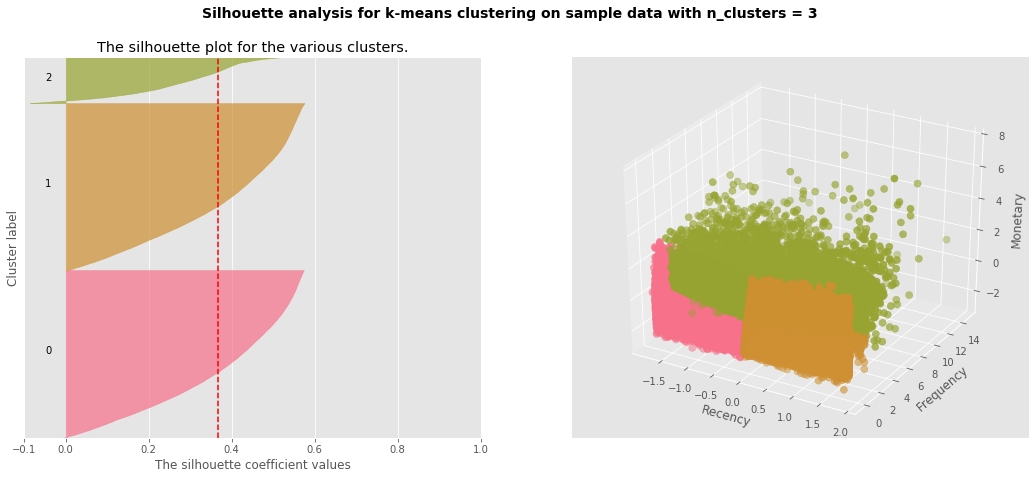

Pour n_clusters = 3 
 Le silhouette score moyen est de : 0.37 
 Le temps d'entrainement du modèle est de : 0.52 (s) 
 Le score de Gini est de : 0.33


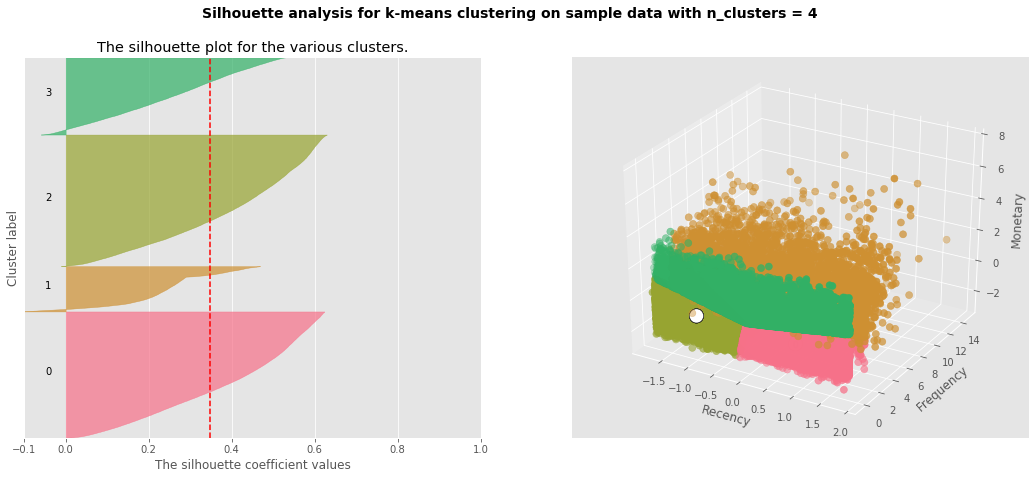

Pour n_clusters = 4 
 Le silhouette score moyen est de : 0.35 
 Le temps d'entrainement du modèle est de : 1.99 (s) 
 Le score de Gini est de : 0.4


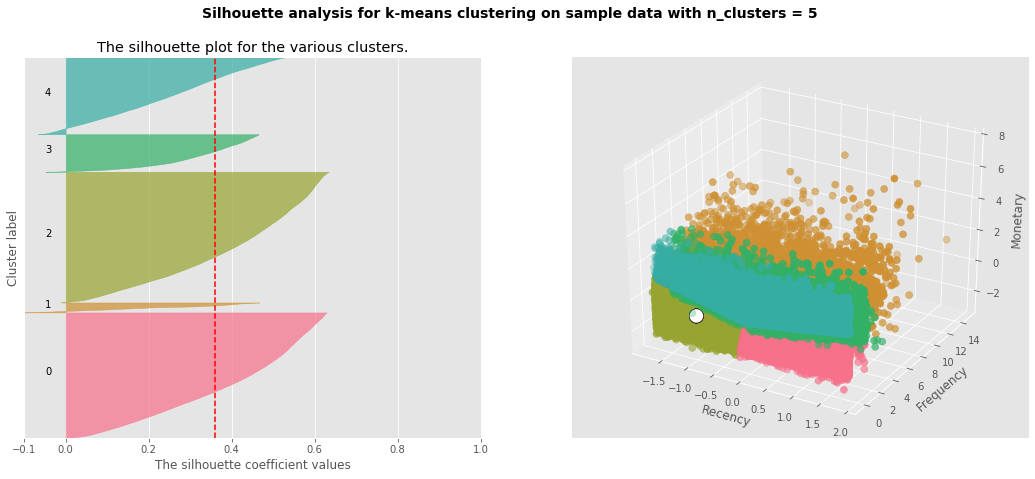

Pour n_clusters = 5 
 Le silhouette score moyen est de : 0.36 
 Le temps d'entrainement du modèle est de : 2.52 (s) 
 Le score de Gini est de : 0.47


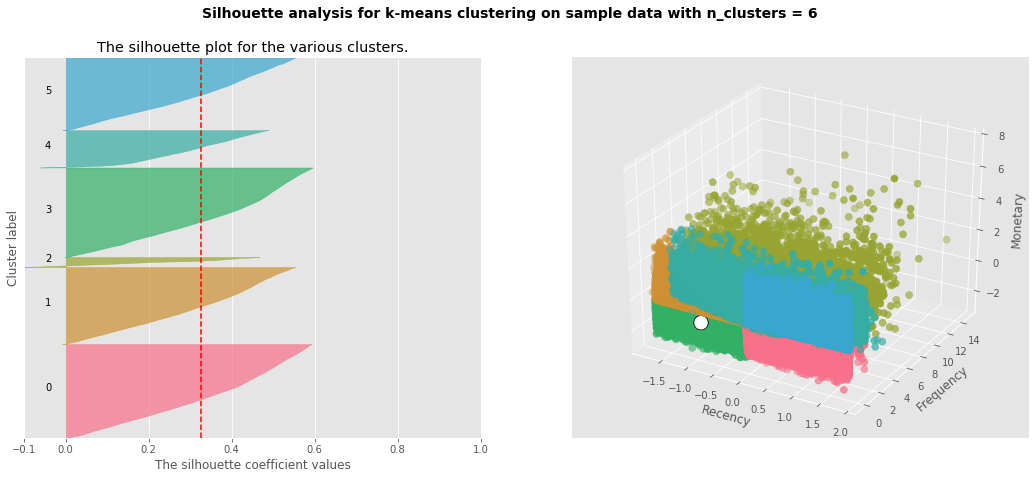

Pour n_clusters = 6 
 Le silhouette score moyen est de : 0.33 
 Le temps d'entrainement du modèle est de : 1.89 (s) 
 Le score de Gini est de : 0.51


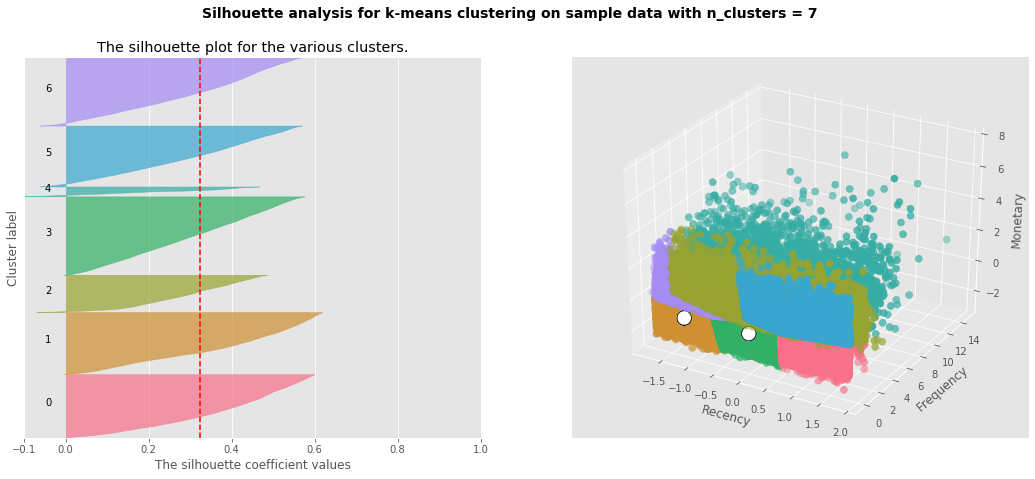

Pour n_clusters = 7 
 Le silhouette score moyen est de : 0.32 
 Le temps d'entrainement du modèle est de : 2.34 (s) 
 Le score de Gini est de : 0.48


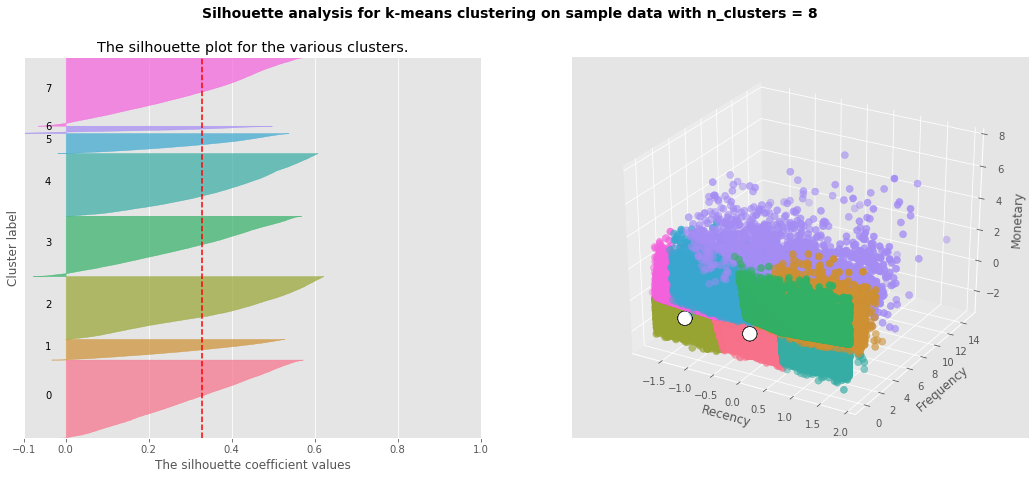

Pour n_clusters = 8 
 Le silhouette score moyen est de : 0.33 
 Le temps d'entrainement du modèle est de : 2.63 (s) 
 Le score de Gini est de : 0.5


In [218]:
# Résultats kmeans pour différents nombre de clusters
range_n_clusters = range(3, 9)
wcss,
silhouette_score_avg,
ginis,
fit_predict_time = clustering_rfm(rfm_std_1,
                                  range_n_clusters)

In [219]:
def stability_init(X, range_n_clusters, n_iters=10):
    """
    Calcul de la stabilité à l'initialisation avec
    la métrique ARI

    paramètres
    X: data à passer dans l'algo de clustering
    range_n_clusters: list du nombre de clusters
    n_iters: nombre de fois que le clustering est effectué
    """

    ARI = {}
    ARI_mean, ARI_std = {}, {}
    rfm_table = pd.DataFrame()
    for n_clusters in range_n_clusters:
        kmeans = KMeans(n_clusters=n_clusters,
                        init='k-means++',
                        random_state=1000)

        clusters = kmeans.fit_predict(X)
        rfm_table['n_clusters_' + str(n_clusters)] = clusters
        ARI[n_clusters] = []

        for n_it in range(n_iters):
            km = KMeans(n_clusters=n_clusters,
                        init='k-means++',
                        random_state=n_it)
            clusters = km.fit_predict(X)
            ARI[n_clusters].append(
                adjusted_rand_score(rfm_table['n_clusters_' + str(n_clusters)],
                                    clusters))
        ARI_std[n_clusters] = np.std(ARI[n_clusters])
        ARI_mean[n_clusters] = np.mean(ARI[n_clusters])
    return ARI_mean, ARI_std

In [220]:
def display_results_1(results, range_n_clusters):
    """
    Affichage 3 graphiques: Silhouette score, WCSS(inertie du clustering)
    et Gini Score en fonction du nombre de clusters

    paramètres:
    results: dictionnaire de résultats
    range_n_clusters: list du nombre de clusters étudiés
    """

    plt.figure(1, figsize=(20, 5))

    # Affichage du score de Gini en fonction du nombre de clusters
    plt.subplot(131)
    plt.bar(range_n_clusters, height=results["silhouette_score_avg"])
    plt.ylabel("Silhouette Score")
    plt.xlabel("Nombre de clusters")
    plt.title("Silhouette graph")

    # Affichage de l'intertie en fonction du nombre de clusters
    plt.subplot(132)
    plt.plot(range_n_clusters, results["wcss"])
    plt.title('Elbow graph')
    plt.xlabel('Cluster number')
    plt.ylabel('WCSS')

    # Affichage du score de Gini en fonction du nombre de clusters
    plt.subplot(133)
    plt.bar(range_n_clusters, height=results["ginis"])
    plt.title("Homogénéité des clusters")
    plt.xlabel('Cluster number')
    plt.ylabel('Gini Score')
    plt.show()

In [221]:
def display_results_2(results, range_n_clusters):
    """
    Affichage 2 graphiques: Temps d'entrainement et de prédiction et
    ARI score pour l'étude de la stabilité à l'initialisation

    paramètres:
    results: dictionnaire de résultats
    range_n_clusters: list du nombre de clusters étudiés
    """

    plt.figure(1, figsize=(15, 5))
    # Premier subplot : fit and predict time
    plt.subplot(121)
    plt.bar(range_n_clusters, height=results["fit_predict_time"])
    plt.title("Temps d'entrainement et prédiction")
    plt.ylabel("Time (s)")

    plt.subplot(122)
    # Premier subplot : ARI Score sur n_itérations
    plt.bar(range_n_clusters, height=results["ARI_mean"].values())
    plt.errorbar(range_n_clusters,
                 results["ARI_mean"].values(),
                 yerr=results["ARI_std"].values(),
                 fmt='none', ecolor='black')

    plt.title("Stabilité à l'initialisation")
    plt.xlabel('Cluster number')
    plt.ylabel('ARI Score')

    plt.show()

In [222]:
# Conservation des résultats sous forme de dictionnarie
results = {"silhouette_score_avg": silhouette_score_avg,
           "ginis": ginis,
           "wcss": wcss}

In [224]:
# Calcul de la stabilité à l'initialisation
ARI_mean, ARI_std = stability_init(rfm_std_1, range_n_clusters)

In [226]:
# Conservation des résultats dans le dictionnaire
results["ARI_mean"] = ARI_mean
results["ARI_std"] = ARI_std
results["fit_predict_time"] = fit_predict_time

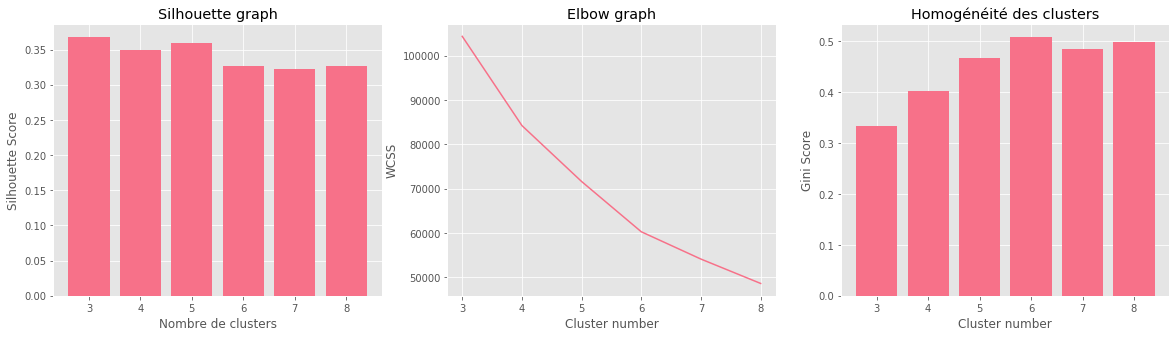

In [227]:
# Affichage graphique des résultats :
# - silhouette_score_avg
# - ginis
# - wcss
display_results_1(results, range_n_clusters)

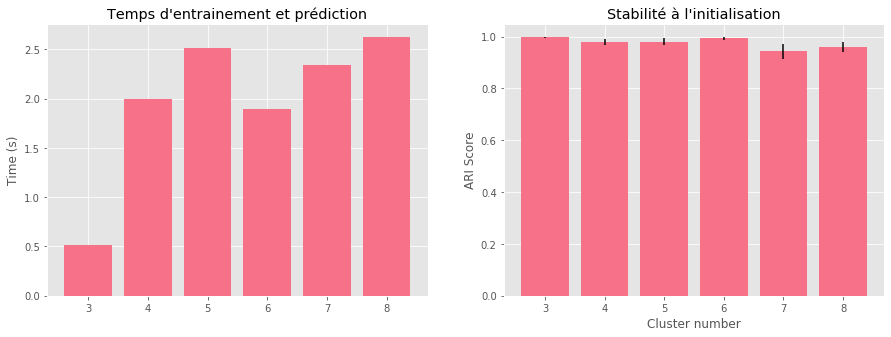

In [228]:
# Affichage graphique des résultats :
# - ARI Score
# - fit and predict time
display_results_2(results, range_n_clusters)

- La stabilité à l'initialisation est très forte quelque soit le nombre de clusters
- Le silhouette score est le deuxième plus élevé pour n_clusters=6
- Le graphique Elbow montre un léger coude pour n_clusters=6

C'est donc n_clusters=6 qui est choisi pour la suite de l'étude

In [229]:
# Initilisation d'un KMeans
kmeans = KMeans(n_clusters=6, init='k-means++', random_state=42)
# Clustering sur les données pour la période 1
clusters = kmeans.fit_predict(x_transformed_1)
rfm_table_1['clusters'] = clusters

In [275]:
# Sauvegarde des outils utilisés
pickle.dump(kmeans, open('kmeans.md', 'wb'))
pickle.dump(encoder, open('std_encoder.md', 'wb'))

#### Résumé des résultats

In [230]:
# Liste des fonctions d'aggrégation
func = ['count', 'min', 'mean', 'median', 'max', 'std']

# Les données sont groupés par clusters
qtd_preco = rfm_table_1.groupby(['clusters'])

# Aggrégation des données
summery_table = qtd_preco[['Recency', 'Frequency', 'Monetary']].agg(func)

# Affichage des résultats
summery_table

Recency                                         Frequency      \
           count  min        mean median  max        std     count min   
clusters                                                                 
0           7399    5  180.340451    181  364  96.313861      7399   2   
1          15250    1   93.612656     94  177  49.586151     15250   1   
2          18574  177  261.952137    264  364  52.253168     18574   1   
3          17727    5   91.736222     92  178  50.484321     17727   1   
4          14418  178  262.179428    265  364  52.092990     14418   1   
5           1956    6  188.132924    188  364  98.343179      1956   2   

                                        Monetary                       \
              mean median max       std    count     min         mean   
clusters                                                                
0         2.056089      2   4  0.238757     7399   17.38   364.539831   
1         1.000000      1   1  0.000000    15250  109.08   259.398782   
2         1.009314      1   2  0.096062    18574   10.07    63.743970   
3         1.007616      1   2  0.086936    17727    9.59    63.271796   
4         1.000000      1   1  0.000000    14418  110.77   251.706337   
5         4.309305      4  38  2.231588     1956   19.35  1582.128947   

                                           
           median        max          std  
clusters                                   
0         270.000    5277.28   372.241408  
1         176.090    6922.21   277.350542  
2          62.940     110.80    24.089077  
3          62.250     110.77    24.206756  
4         177.355    3826.80   232.340961  
5         837.985  109312.64  3572.630911

#### Etiquettage des clusters

In [239]:
# Etiquettage des différents clusters
categories_2 = [
                "Others",
                "Potential Loyalist",
                'Lost or About to Sleep',
                "Top Clients ++",
                "Recent Customers",
                "Good Clients",
]

In [240]:
# Renommage des différents clusters et regroupement
rfm_table_1.loc[rfm_table_1["clusters"] ==
                0, "clusters"] = 'Good Clients'

rfm_table_1.loc[rfm_table_1["clusters"] ==
                1, "clusters"] = 'Recent Customers'

rfm_table_1.loc[rfm_table_1["clusters"] ==
                2, "clusters"] = 'Lost or About to Sleep'

rfm_table_1.loc[rfm_table_1["clusters"] ==
                3, "clusters"] = 'Potential Loyalist'

rfm_table_1.loc[rfm_table_1["clusters"] ==
                4, "clusters"] = 'Others'

rfm_table_1.loc[rfm_table_1["clusters"] ==
                5, "clusters"] = 'Top Clients ++'

Descriptifs du clustering des consommateurs :

- Top Clients ++ : Il s'agit des grands comptes, les individus dépensent très régulièrement des grandes quantitées d'argent

- Good Clients : Ils arrivent après les grandes comptes, les sommes d'argents dépensés sont conséquentes et la fréquence élevé

- Potential Loyalist : nouveaux clients avec fréquence d'achat moyenne

- Recent Customers : achats récents, mais peu fréquents

- Lost or About to Sleep: clients qui n'ont pas effectués d'achat cette année ou qui tendent à disparaitre

- Others : pas catégorisable

In [241]:
# Nouvelle table de résumé du clustering
func = ['count', 'min', 'mean', 'median', 'max', 'std']
qtd_preco = rfm_table_1.groupby(['clusters'])
summery_table = qtd_preco[['Recency', 'Frequency', 'Monetary']].agg(func)

# Affichage des résultats
summery_table

Recency                                          \
                         count  min        mean median  max        std   
clusters                                                                 
Good Clients              7399    5  180.340451    181  364  96.313861   
Lost or About to Sleep   18574  177  261.952137    264  364  52.253168   
Others                   14418  178  262.179428    265  364  52.092990   
Potential Loyalist       17727    5   91.736222     92  178  50.484321   
Recent Customers         15250    1   93.612656     94  177  49.586151   
Top Clients ++            1956    6  188.132924    188  364  98.343179   

                       Frequency                                    Monetary  \
                           count min      mean median max       std    count   
clusters                                                                       
Good Clients                7399   2  2.056089      2   4  0.238757     7399   
Lost or About to Sleep     18574   1  1.009314      1   2  0.096062    18574   
Others                     14418   1  1.000000      1   1  0.000000    14418   
Potential Loyalist         17727   1  1.007616      1   2  0.086936    17727   
Recent Customers           15250   1  1.000000      1   1  0.000000    15250   
Top Clients ++              1956   2  4.309305      4  38  2.231588     1956   

                                                                              
                           min         mean   median        max          std  
clusters                                                                      
Good Clients             17.38   364.539831  270.000    5277.28   372.241408  
Lost or About to Sleep   10.07    63.743970   62.940     110.80    24.089077  
Others                  110.77   251.706337  177.355    3826.80   232.340961  
Potential Loyalist        9.59    63.271796   62.250     110.77    24.206756  
Recent Customers        109.08   259.398782  176.090    6922.21   277.350542  
Top Clients ++           19.35  1582.128947  837.985  109312.64  3572.630911

#### Radar plot et Projections 2D et 3D

In [242]:
# Liste des couleurs pour chaque segment
palette_2 = sns.color_palette("husl", len(categories_2))
colors_2 = {label: color for label, color in zip(categories_2,
                                                 palette_2.as_hex())}

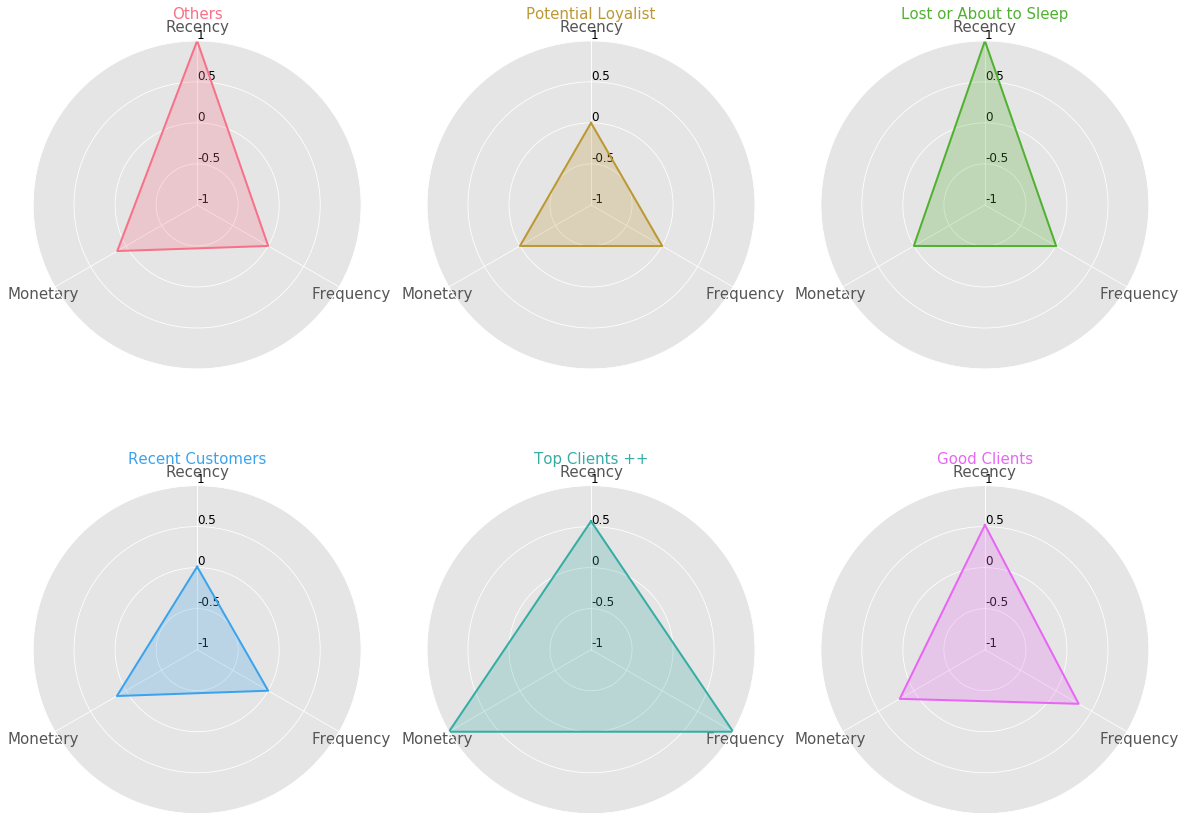

In [243]:
# Radar plot pour la segmentation
radar_plot(rfm_table_1[['Recency',
                        'Frequency',
                        'Monetary',
                        'clusters']],
           'clusters',
           colors_2,
           sub_plot=[2, 3],
           figsize=(20, 15))

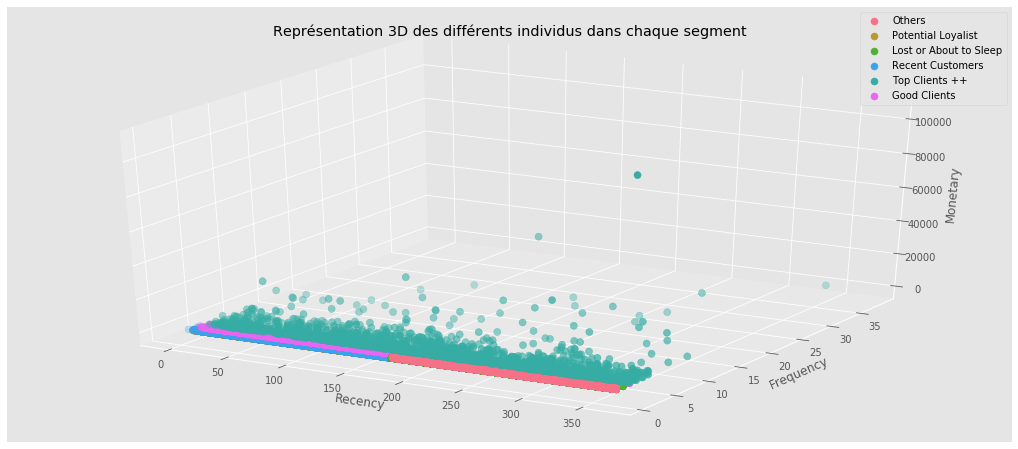

In [244]:
# Projection 3D : Rencency vs Frequency vs Monetary
projection_3d_segments(rfm_table_1, 'clusters', colors_2)

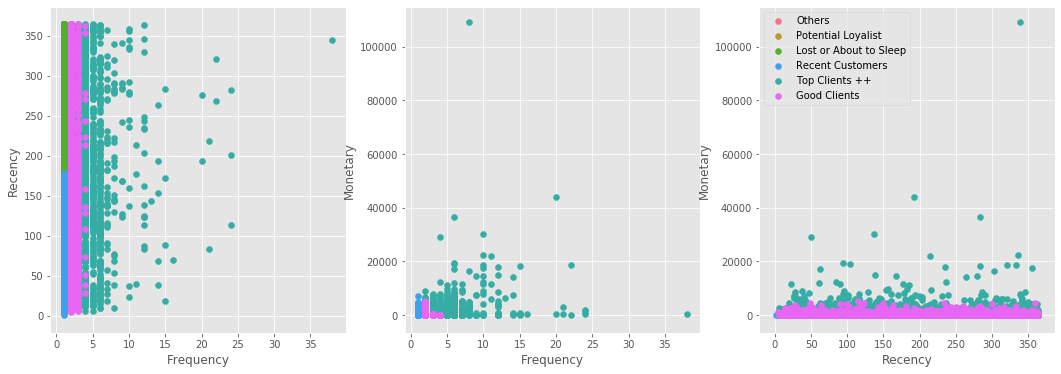

In [245]:
fig = plt.figure(1, figsize=(18, 6))

# 2D plot, Frequency vs Recency
plt.subplot(1, 3, 1)
projection_2d_segments(rfm_table_1,
                       "Frequency",
                       "Recency",
                       "clusters",
                       colors_2)

# 2D plot, Frequency vs Monetary
plt.subplot(1, 3, 2)
projection_2d_segments(rfm_table_1,
                       "Frequency",
                       "Monetary",
                       "clusters",
                       colors_2)

# 2D plot, Recency vs Monetary
plt.subplot(1, 3, 3)
projection_2d_segments(rfm_table_1,
                       "Recency",
                       "Monetary",
                       "clusters",
                       colors_2)

plt.legend()
plt.show()

#### Snake plot pour comprendre et comparer les segments et clusters

#### Snake plot 


In [246]:
rfm_std_1['clusters'] = rfm_table_1['clusters']
rfm_std_1['RFM Score'] = rfm_table_1["RFM Score"]
rfm_std_1['customer_id'] = rfm_table_1["customer_id"]

# Melt the data into a long format so RFM values
# and metric names are stored in 1 column each
rfm_melt = pd.melt(rfm_std_1,
                   id_vars=['customer_id', 'RFM Score', 'clusters'],
                   value_vars=['Recency', 'Frequency', 'Monetary'],
                   var_name='Metric', value_name='Value')

# Affichage des 5 premières lignes
rfm_melt.head()

customer_id           RFM Score  \
0  00012a2ce6f8dcda20d059ce98491703              Others   
1  000379cdec625522490c315e70c7a9fb  Potential Loyalist   
2  000419c5494106c306a97b5635748086  Potential Loyalist   
3  00046a560d407e99b969756e0b10f282              Others   
4  00050bf6e01e69d5c0fd612f1bcfb69c                Lost   

                 clusters   Metric     Value  
0                  Others  Recency  1.165876  
1      Potential Loyalist  Recency -0.242347  
2  Lost or About to Sleep  Recency  0.071717  
3                  Others  Recency  0.821418  
4  Lost or About to Sleep  Recency  1.753479

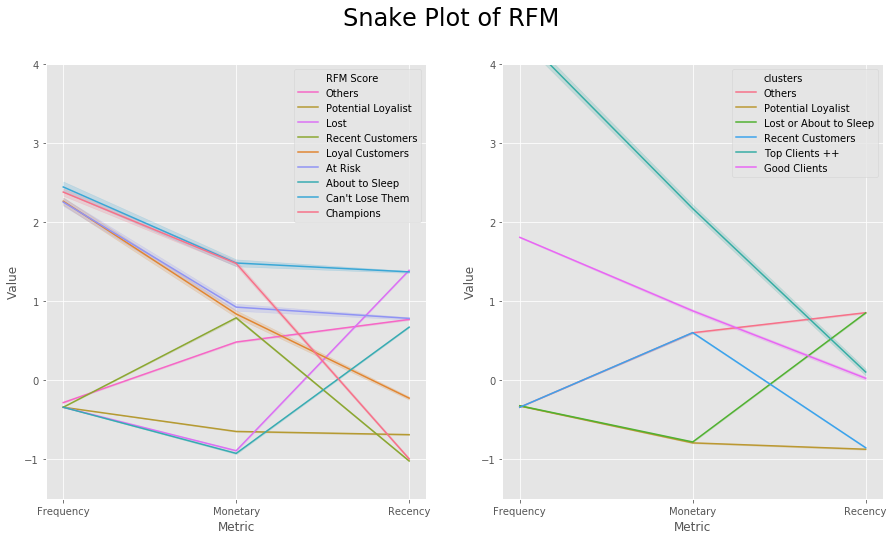

In [247]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
# Snake plot de la segmentation manuelle
sns.set_palette(sns.color_palette("husl", 9))
sns.lineplot(x='Metric',
             y='Value',
             hue='RFM Score',
             data=rfm_melt,
             ax=ax1,
             palette=colors_1)
ax1.set_ylim([-1.5, 4])


# Snake plot du clustering par K-Means
sns.set_palette(sns.color_palette("husl", 5))
sns.lineplot(x='Metric',
             y='Value',
             hue='clusters',
             data=rfm_melt,
             ax=ax2,
             palette=colors_2)
ax2.set_ylim([-1.5, 4])

plt.suptitle("Snake Plot of RFM", fontsize=24)  # make title fontsize subtitle
plt.show()

- Les catégories "Lost" et "About to Sleep" correspondent au cluster "Lost or About to Sleep"

- La catégorie "Champions" est assimilable à la catégorie "Good Clients", et les "Top Clients ++" correspondent aux grands comptes d'Olist

- Quant aux autres catégories, le clustering retrouve celles de la segmentation par quantiles

### 3.5 Méthodologie 3: Segmentation RFM ++

Dans cette partie nous allons pousser la segmentation RFM traditionnelle en incorporant des variables produits comme le poids moyen et le volume moyen des commandes. A ceci nous ajouterons 2 variables clients qui sont le pourcentage d'achats effectués en carte de crédit et le pourcentage d'achats effectués depuis l'état de São Paulo

In [137]:
# On récupère les variables qui paraissent les plus intéressantes
data_plus = df[["customer_id",
                "purchase_time",
                "payment_value",
                "product_volume_cm3",
                "product_weight_g",
                "payment_type",
                "customer_state"]].copy()

In [138]:
# Encodage binaire de l'état des acheteurs, Sao Paulo ou Non
data_plus.loc[data_plus["customer_state"] != "SP", "customer_state"] = 0
data_plus.loc[data_plus["customer_state"] == "SP", "customer_state"] = 1

# Encodage binaire du type de payment, Credit card ou Non
data_plus.loc[data_plus["payment_type"] != "credit_card", "payment_type"] = 0.0
data_plus.loc[data_plus["payment_type"] == "credit_card", "payment_type"] = 1.0

data_plus["payment_type"] = data_plus["payment_type"].astype('float64')
data_plus["customer_state"] = data_plus["customer_state"].astype('float64')

In [140]:
def calculate_rfm_plus(data, period, end_period):

    data = data.loc[data["purchase_time"] >= end_period
                    - timedelta(days=period)]
    # Nombre de jours passés entre aujourd'hui
    # et la dernière commande de chaque utilisateur
    data.loc[:, "DaysSinceOrder"] = data.loc[:, "purchase_time"] \
                                        .map(lambda d: (end_period - d).days)

    aggr = {
            'DaysSinceOrder': lambda x: x.min(),
            # Nombre de jours depuis la dernière commande (Recency)
            'purchase_time': lambda x:
            len([d for d in x if d >= end_period - timedelta(days=period)]),
            # le nombre total de transactions sur la période passée (Frequency)
            'payment_type': 'mean',
            # Pourcentage des transactions par carte bancaire
            'customer_state': 'mean',
            # Pourcentage des transactions effectués dans l'état de Sao Paulo
            'product_weight_g': 'mean',
            # Poids moyen des commmandes
            'product_volume_cm3': 'mean'
            # Volume moyen des commandes
    }

    rfm = data.groupby('customer_id').agg(aggr).reset_index()
    rfm.rename(columns={'DaysSinceOrder': 'Recency',
                        'purchase_time': 'Frequency',
                        'payment_type': 'Credit_card_percent',
                        'customer_state': 'SP_state_percent',
                        'product_weight_g': "Product_weight_mean",
                        'product_volume_cm3': "Product_volume_mean"},
               inplace=True)

    rfm['Monetary'] = rfm.loc[:, 'customer_id'] \
                      .apply(lambda x:
                             data.loc[data['customer_id'] == x,
                                      'payment_value'].sum())
    return rfm

In [141]:
# Calcul des différentes variables pour le clustering RFM ++
rfm_plus_1 = calculate_rfm_plus(data_plus, period, today)

C:\Users\maleg\Anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\maleg\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



##### Distribution des variables

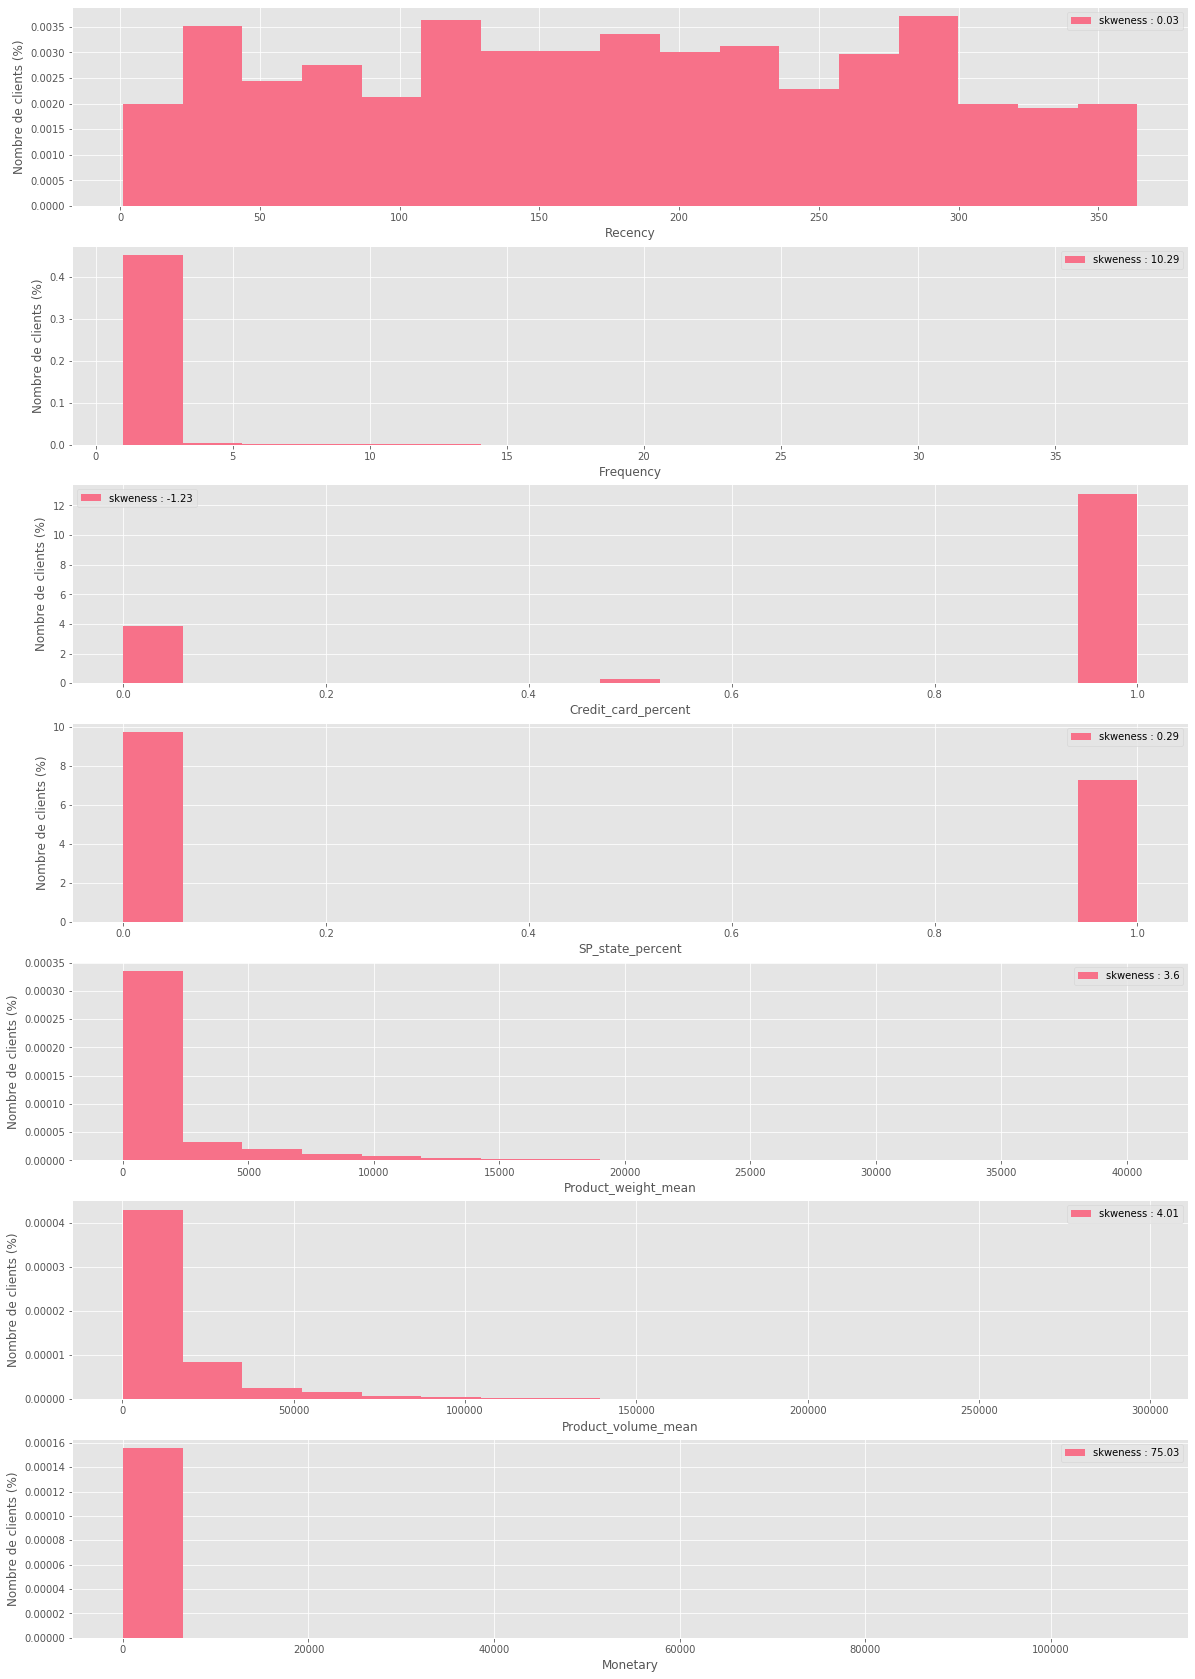

In [142]:
# Affichage de l'histogramme de chacune des variables
plot_hist(rfm_plus_1.drop(columns='customer_id'), figsize=(20, 30))

##### Variables logarithmés 

Dans cette partie, nous allons logarithmés les variables qui présentent un skewness supérieur à 1

In [143]:
# Applique du logarithme sur certaines variables
rfm_log_plus = rfm_plus_1.copy()
rfm_log_plus[["Frequency",
              "Monetary",
              "Product_volume_mean",
              "Product_weight_mean"]] = rfm_log_plus[["Frequency",
                                                      "Monetary",
                                                      "Product_volume_mean",
                                                      "Product_weight_mean"]] \
                                        .apply(lambda x: np.log(1 + x))

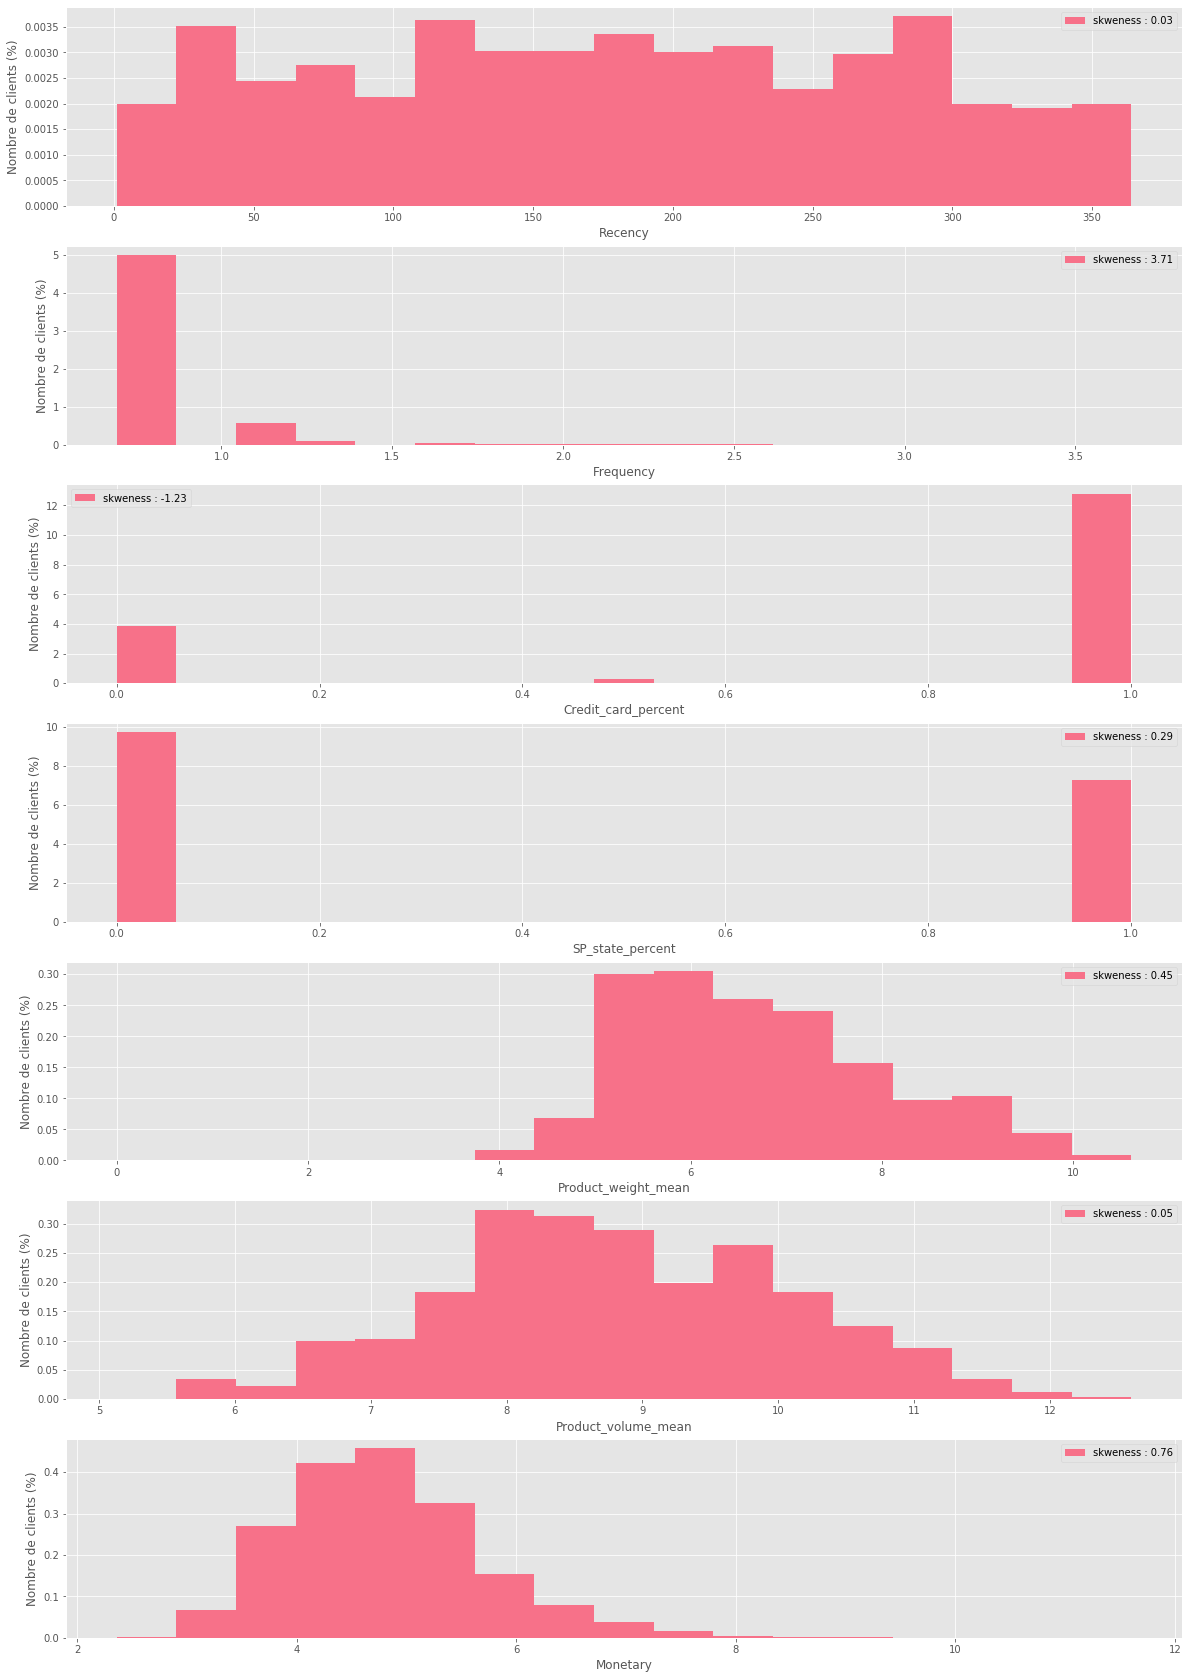

In [144]:
# Affichage de l'histogramme des variables après passage au logarithme
plot_hist(rfm_log_plus.drop(columns='customer_id'), figsize=(20, 30))

#### Normalisation des variables

In [145]:
# Normalisation des variables
encoder_plus = StandardScaler()

# Normalisation des données
x_transformed_plus = encoder_plus.fit_transform(
                        rfm_log_plus[['Recency',
                                      'Frequency',
                                      'Monetary',
                                      'Credit_card_percent',
                                      'SP_state_percent',
                                      'Product_volume_mean',
                                      'Product_weight_mean']])

#### Réduction dimmensionnelle avec PCA

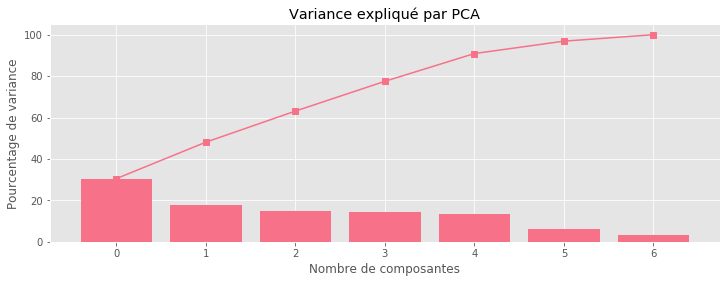

In [188]:
# Réduction dimmensionnelle avec 'Principal Component Analysis'
pca = PCA()
rfm_pca = pca.fit_transform(x_transformed_plus)

# Affichage graphique
fig = plt.figure(1, figsize=(12, 4))
plt.bar(range(len(pca.explained_variance_ratio_)),
        100*pca.explained_variance_ratio_)
plt.ylim(0, 1.05*100)
plt.plot(range(len(pca.explained_variance_ratio_)),
         100*np.cumsum(pca.explained_variance_ratio_), "s-")
plt.ylabel("Pourcentage de variance")
plt.xlabel("Nombre de composantes")
plt.title("Variance expliqué par PCA")
plt.show()

La réduction dimmensionnelle va se faire en choisisant 90% de la variance ce qui permet de réduire de 2 le nombre de dimmensions

In [248]:
# Réduction dimmensionnelle avec 'Principal Component Analysis'
pca = PCA(n_components=0.90)  # 90% de la variance
rfm_pca = pca.fit_transform(x_transformed_plus)

# Mise sous forme de DataFrame
rfm_pca = pd.DataFrame(rfm_pca,
                       columns=["Composante_" + str(i)
                                for i in range(rfm_pca.shape[1])])

#### Résultats du clustering pour différents nombre de clusters

In [249]:
def clustering_rfm_plus(rfm, range_n_clusters):
    """
    Cette fonction teste pour différents nombre de clusters,
    un clustering des données par la méthode k-means.
    La fonction affiche le score de silhouette pour chacun des clusters,
    ainsi que la répartition des données dans l'espace RFM
    et leurs codes couleurs associés en fonction de leur appartenance
    aux différents clusters déterminés.

    Parametres:
    rfm (pd.DataFrame): DataFrame avec 3 colonnes nommés :
    Recency, Frequency and Monetary

    Return :
    list: Liste des valeurs d'intertie pour différents nombre de clusters
    """

    # Liste des valeurs d'inertie
    wcss = []
    # Temps d'entrainement
    fit_predict_time = []
    # Score de silhouette
    silhouette_score_avg = []
    # Score de gini
    ginis = []
    # Liste du nombre de clusters à tester
    palette = sns.color_palette("husl", max(range_n_clusters))
    colors_2 = palette.as_hex()

    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig = plt.figure(1, figsize=(18, 7))
        ax1 = fig.add_subplot(121)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example
        # all lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(rfm) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters,
                           init='k-means++',
                           random_state=10)

        # Calcul du temps de prédiction
        start_time = time.time()
        cluster_labels = clusterer.fit_predict(rfm)
        time.time() - start_time

        fit_predict_time.append(time.time() - start_time)
        wcss.append(clusterer.inertia_)
        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation
        # of the formed clusters
        silhouette_score_avg.append(silhouette_score(rfm, cluster_labels))

        # Nombre d'invididus dans chaque cluster
        counts = [list(cluster_labels).count(i) for i in range(n_clusters)]
        ginis.append(gini(counts))

        # Compute the silhouette scores for each sample
        sample_silh_values = silhouette_samples(rfm, cluster_labels)

        tnse = TSNE()
        x_tsne = tnse.fit_transform(rfm)
        x_tsne_df = pd.DataFrame(x_tsne,  columns=["composante_1",
                                                   "composante_2"])
        x_tsne_df["clusters"] = cluster_labels

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silh_values = sample_silh_values[cluster_labels == i]

            ith_cluster_silh_values.sort()

            size_cluster_i = ith_cluster_silh_values.shape[0]
            y_upper = y_lower + size_cluster_i

            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0,
                              ith_cluster_silh_values,
                              facecolor=colors_2[i],
                              edgecolor=colors_2[i],
                              alpha=0.7)

            # Label the silhouette plots with
            # their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_score_avg[-1], color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        dx = fig.add_subplot(122)

        for i in range(n_clusters):
            dx.scatter(x_tsne_df[x_tsne_df.clusters == i]["composante_1"],
                       x_tsne_df[x_tsne_df.clusters == i]["composante_2"],
                       c=colors_2[i],
                       label='Cluster ' + str(i+1),
                       s=50)

        # Titres des axes
        dx.set_xlabel("Composante_1")
        dx.set_ylabel("Composante_2")
        dx.set_title("Projection 2D par TSNE")

        plt.suptitle(("Silhouette analysis for k-means clustering "
                      "on sample data with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

        plt.show()

        print("Pour n_clusters =", n_clusters, "\n",
              "Le silhouette score moyen est de :",
              round(silhouette_score_avg[-1], 2), "\n",
              "Le temps d'entrainement du modèle est de :",
              round(fit_predict_time[-1], 2), '(s) \n',
              "Le score de Gini est de :", round(ginis[-1], 2))

    # Inertie, Silhouette_score, ginis, time_fit_and_predict
    return wcss, silhouette_score_avg, ginis, fit_predict_time  # Inertie

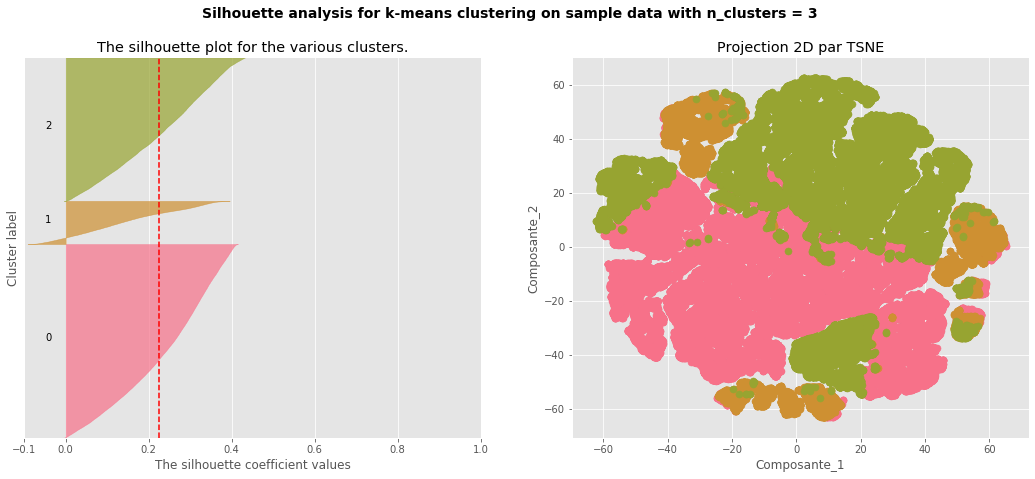

Pour n_clusters = 3 
 Le silhouette score moyen est de : 0.23 
 Le temps d'entrainement du modèle est de : 0.85 (s) 
 Le score de Gini est de : 0.54


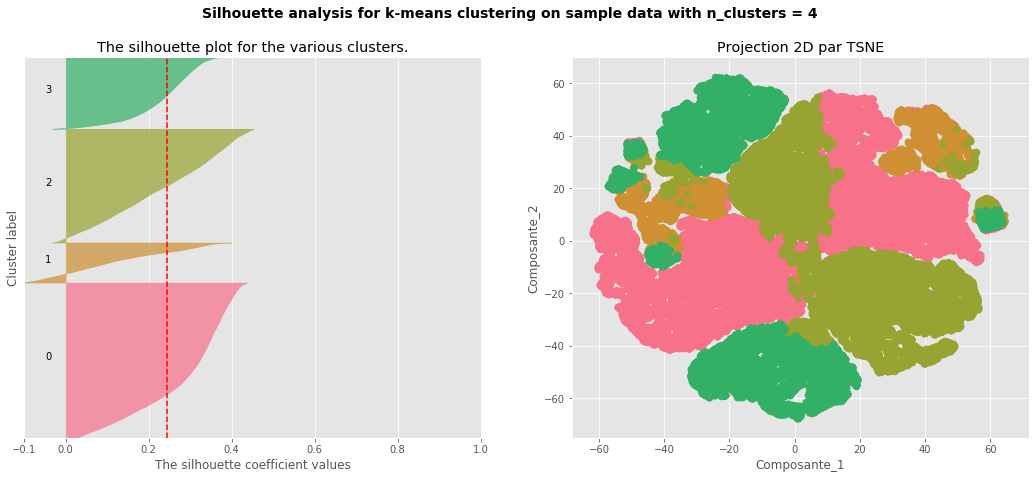

Pour n_clusters = 4 
 Le silhouette score moyen est de : 0.24 
 Le temps d'entrainement du modèle est de : 1.04 (s) 
 Le score de Gini est de : 0.52


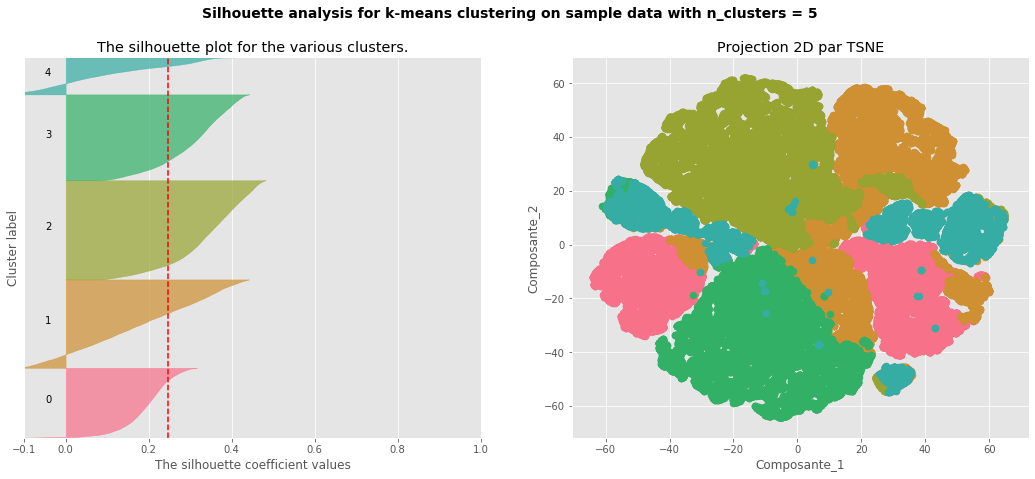

Pour n_clusters = 5 
 Le silhouette score moyen est de : 0.25 
 Le temps d'entrainement du modèle est de : 1.64 (s) 
 Le score de Gini est de : 0.46


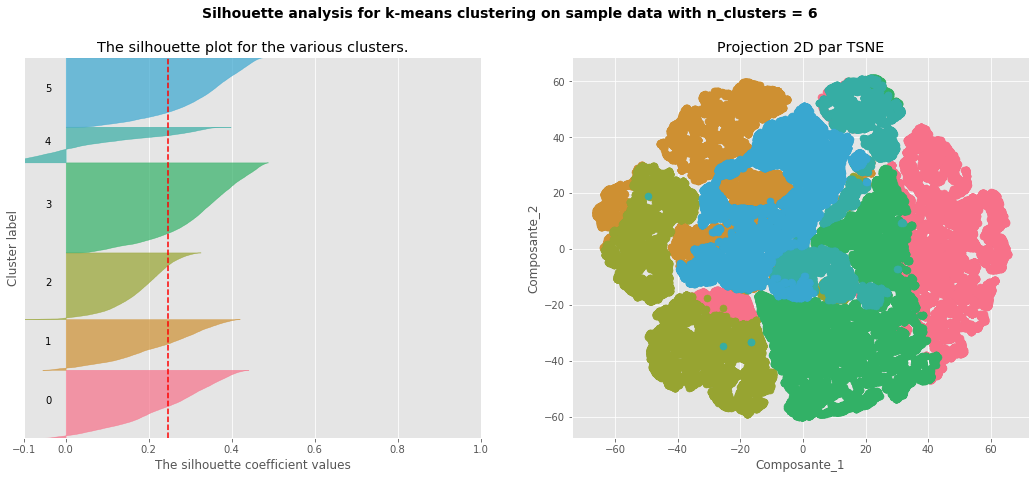

Pour n_clusters = 6 
 Le silhouette score moyen est de : 0.25 
 Le temps d'entrainement du modèle est de : 1.7 (s) 
 Le score de Gini est de : 0.5


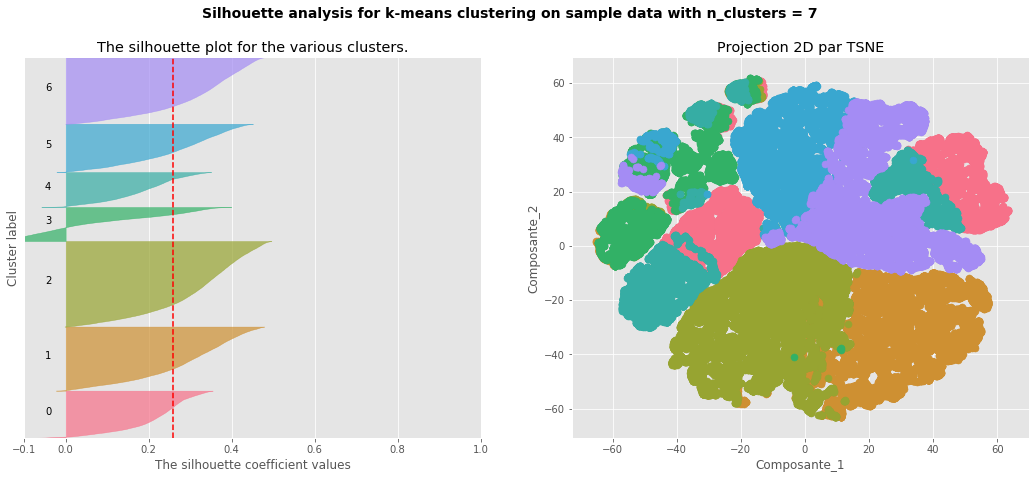

Pour n_clusters = 7 
 Le silhouette score moyen est de : 0.26 
 Le temps d'entrainement du modèle est de : 2.43 (s) 
 Le score de Gini est de : 0.48


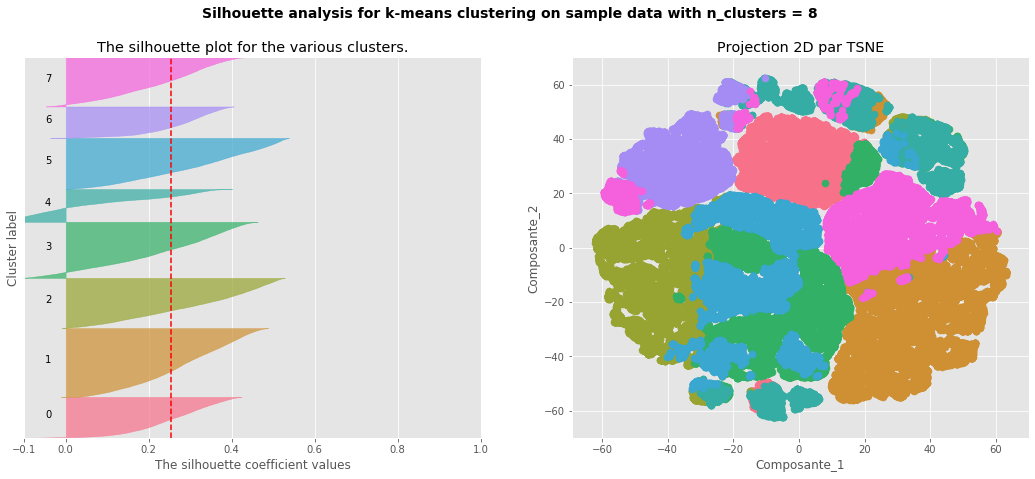

Pour n_clusters = 8 
 Le silhouette score moyen est de : 0.25 
 Le temps d'entrainement du modèle est de : 3.51 (s) 
 Le score de Gini est de : 0.47


In [252]:
wcss,
silhouette_score_avg,
ginis,
fit_predict_time = clustering_rfm_plus(rfm_pca, range_n_clusters)

In [253]:
# Conservation des résultats sous forme de dictionnarie
results_plus = {"silhouette_score_avg": silhouette_score_avg,
                "ginis": ginis,
                "wcss": wcss}

##### Silhouette graph, Elbow Graph et Homogéneité des clusters

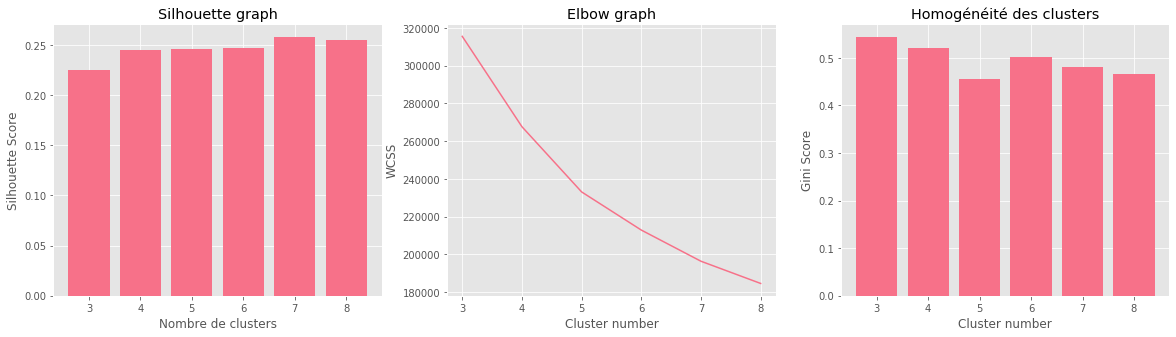

In [254]:
# Affichage graphique des résultats :
# - silhouette_score_avg
# - ginis
# - wcss
display_results_1(results_plus, range_n_clusters)

La méthode Elbow ne présente pas de coude pour indiquer un nombre de cluster optimal.

Le score de silhouette est le plus élevé pour un nombre de clusters égale à 8.

Quand à l'homogénéité, elle est relativement bonne pour tous.

##### Temps de calcul et stabilité à l'initialisation

In [255]:
# Calcul de la stabilité à l'initialisation
ARI_mean, ARI_std = stability_init(rfm_pca, range_n_clusters)
results["ARI_mean"] = ARI_mean
results["ARI_std"] = ARI_std
results["fit_predict_time"] = fit_predict_time

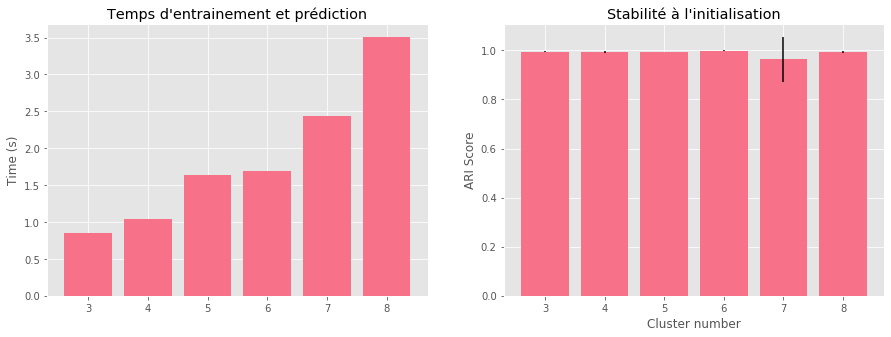

In [257]:
# Affichage graphique des résultats :
# - ARI Score
# - fit and predict time
display_results_2(results, range_n_clusters)

Les temps de prédictions sont relativement faibles. Quant à la stabilité à l'initialisation, elle est excellente pour n_clusters = {3, 4, 8}.

A la vue de tous les résultats, un nombre de clusters égale à 8 est choisie !

Le nombre de clusters n'est pas poussé au delà car il est difficile d'étiquetter un plus grand nombre de clusters

In [285]:
# Initilisation d'un KMeans
kmeans_plus = KMeans(n_clusters=5, init='k-means++', random_state=42)
# Clustering sur les données pour la période 1
clusters = kmeans_plus.fit_predict(rfm_pca)
rfm_plus_1['clusters_plus'] = clusters

#### Résultats détaillés pour n_clusters=8

In [286]:
# Liste des fonctions d'aggrégation
func = ['mean']
# Regroupement des données
qtd_preco = rfm_plus_1.drop(columns='customer_id').groupby(['clusters_plus'])
# Aggrégation des données par différentes fonctions
summery_table = qtd_preco.agg(func)
# Affichage de la table de résumé
summery_table

Recency Frequency Credit_card_percent SP_state_percent  \
                     mean      mean                mean             mean   
clusters_plus                                                              
0              164.963958  1.040216            0.993591         1.000000   
1              175.856802  1.027745            0.995604         0.000000   
2              191.807329  1.028800            0.894017         0.355969   
3              182.671126  2.664710            0.713345         0.413652   
4              176.742688  1.048241            0.005332         0.434751   

              Product_weight_mean Product_volume_mean    Monetary  
                             mean                mean        mean  
clusters_plus                                                      
0                      646.208540         6269.345738  101.068472  
1                      536.653992         5086.324945  122.437501  
2                     6087.516654        38901.081173  267.872231  
3                     1850.509055        13944.006575  745.878115  
4                      898.001847         7992.674310  101.974549

Les résultats ci-dessus permettent de définir les étiquettes de chaque cluster obtenu

In [287]:
# Etiquette des catégories pour le clustering RFM ++
categories_plus = [
                    'Petits locaux 100% credit card',
                    'Touristes',
                    'Très gros volumes',
                    'Top Clients ++',
                    'Petits Clients 100% cash',
                ]

In [288]:
# Renommage des différents clusters RFM ++
rfm_plus_1.loc[rfm_plus_1["clusters_plus"] ==
               0, "clusters_plus"] = 'Petits locaux 100% credit card'

rfm_plus_1.loc[rfm_plus_1["clusters_plus"] ==
               1, "clusters_plus"] = 'Touristes'

rfm_plus_1.loc[rfm_plus_1["clusters_plus"] ==
               2, "clusters_plus"] = 'Très gros volumes'

rfm_plus_1.loc[rfm_plus_1["clusters_plus"] ==
               3, "clusters_plus"] = 'Top Clients ++'

rfm_plus_1.loc[rfm_plus_1["clusters_plus"] ==
               4, "clusters_plus"] = 'Petits Clients 100% cash'

In [289]:
# Liste des couleurs pour chaque segment
palette_plus = sns.color_palette("husl", rfm_plus_1['clusters_plus'].nunique())
colors_plus = {label: color for label, color in zip(categories_plus,
               palette_plus.as_hex())}

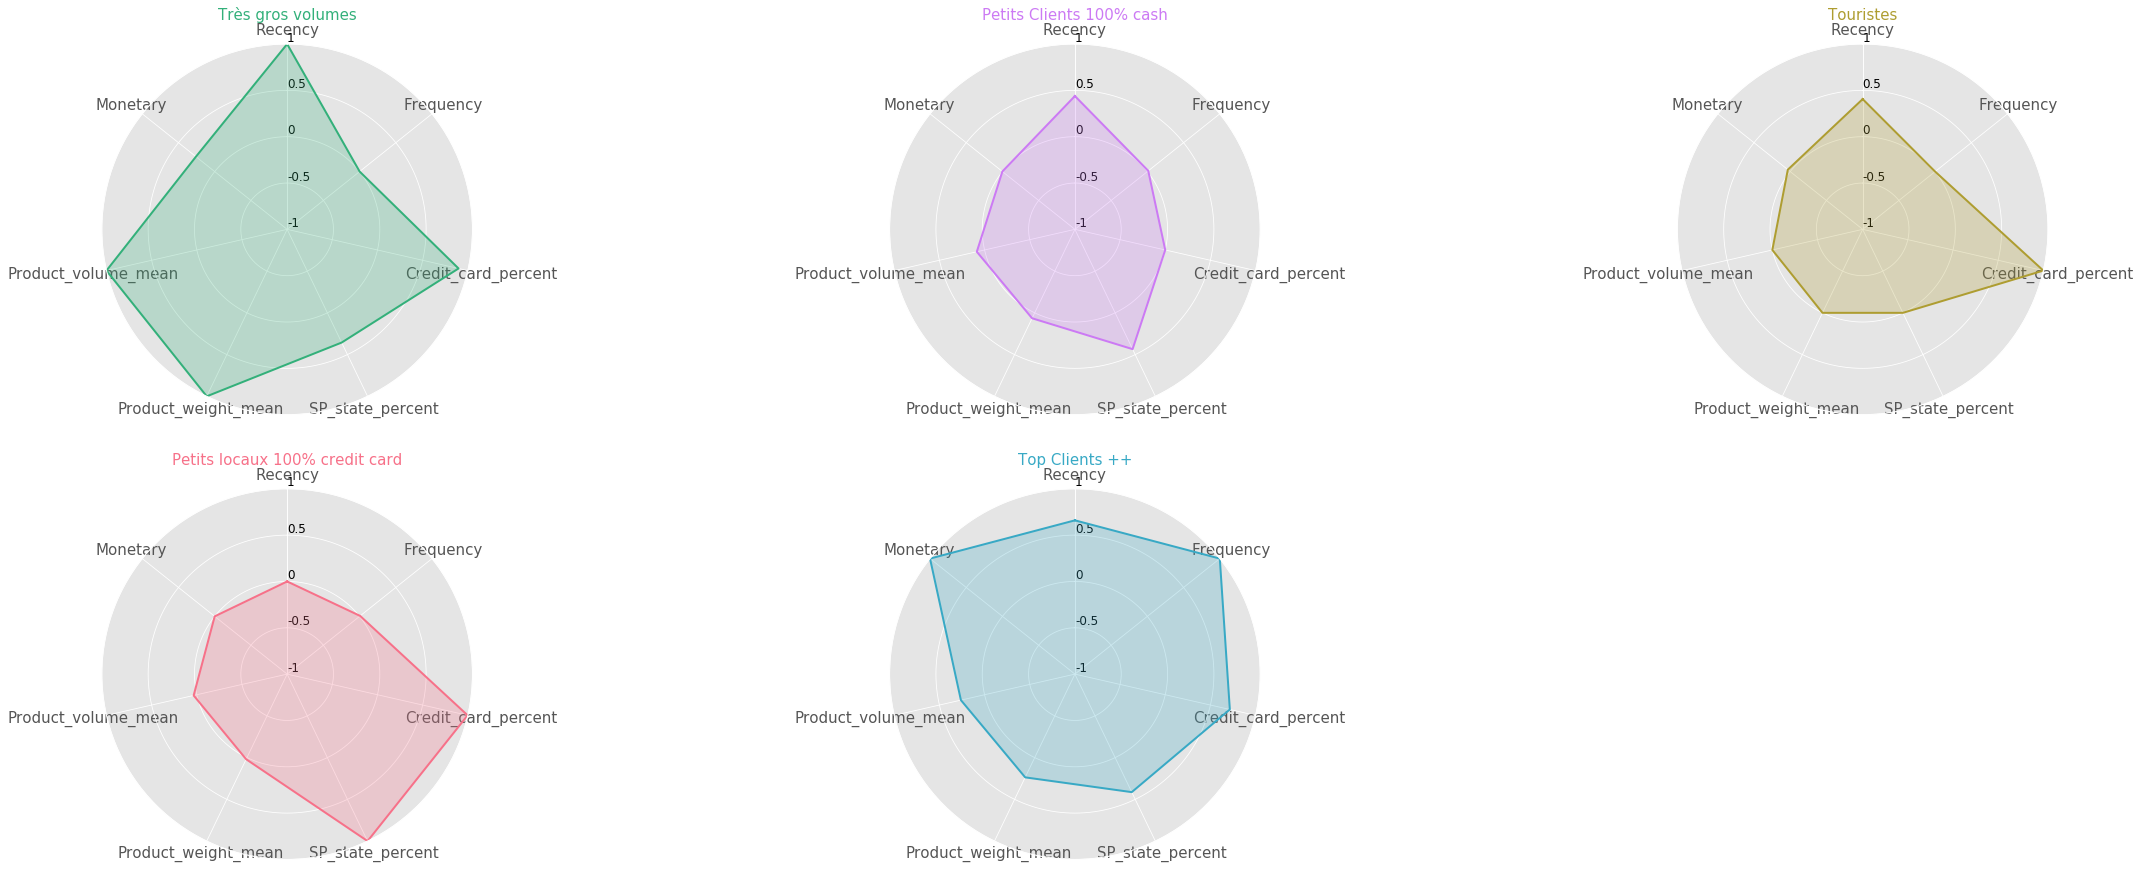

In [290]:
# Radar plot des clients moyens pour chaque cluster RFM ++
radar_plot(rfm_plus_1,
           'clusters_plus',
           colors_plus,
           sub_plot=[2, 3],
           figsize=(40, 15))

In [276]:
# Sauvegarde des outils utilisés
pickle.dump(kmeans_plus, open('kmeans_++.md', 'wb'))
pickle.dump(pca, open('pca_++.md', 'wb'))
pickle.dump(encoder_plus, open('std_encoder_++.md', 'wb'))

## 4. Stabilité des segmentations

Pour analyser la stabilité des segments au cours du temps, nous allons simplement réitéré les étapes précédentes sur des périodes décalés dans l'année de 30 jours, 60 jours et 90 jours. Il s'agira ensuite de déterminer la stabilité par l'indice de Rand.

### 4.1 Calcul RFM pour les 3 périodes étudiées 

In [277]:
def calculate_rfm_table_plus(data, period, end_period):

    """
    Calcul des valeurs R, F et M et assigne pour chaque client
    un score selon la méthodologie 1 et un cluster selon la méthodologie 2

    Paramètres:
    data(pd.DataFrame): DataFrame avec 3 colonnes
    Recency, Frequency et Monetary
    period(int) : Nombre de jours
    end_period(dt.datetime): Date de fin de période

    Return:
    rfmTable(pd.DataFrame): DataFrame data avec 2 nouvelles colonnes
    correspondant
    aux scores et clusters des différents clients pour les méthodologies 1 et 2

    """

    # Calcul des variables :
    # Recency, Frequency, Monetary,
    # Credit_card_percent Product_volume_mean,
    # Product_weight_mean, SP_state_percent
    rfm_plus = calculate_rfm_plus(data, period, end_period)

    # Applique du logarithme sur certaines variables
    rfm_log_plus = rfm_plus.copy()
    rfm_log_plus[["Frequency",
                  "Monetary",
                  "Product_volume_mean",
                  "Product_weight_mean"]] = \
    rfm_log_plus[["Frequency",
                  "Monetary",
                  "Product_volume_mean",
                  "Product_weight_mean"]].apply(lambda x: np.log(1 + x))

    # Normalisation des données
    x_transformed_plus = encoder_plus.transform(
                        rfm_log_plus[['Recency',
                                      'Frequency',
                                      'Monetary',
                                      'Credit_card_percent',
                                      'SP_state_percent',
                                      'Product_volume_mean',
                                      'Product_weight_mean']]
    )

    # Réduction dimmensionnelle avec 'Principal Component Analysis'
    rfm_pca = pca.transform(x_transformed_plus)

    # Mise sous forme de DataFrame
    rfm_pca = pd.DataFrame(rfm_pca,
                           columns=["Composante_" + str(i)
                                    for i in range(rfm_pca.shape[1])])

    # Clustering pour chacun des clients
    clusters = kmeans_plus.predict(rfm_pca)
    rfm_plus["clusters_plus"] = clusters

    # Renommage des différents clusters et regroupement
    rfm_plus.loc[rfm_plus["clusters_plus"] ==
                 0, "clusters_plus"] = 'Petits clients locaux'

    rfm_plus.loc[rfm_plus["clusters_plus"] ==
                 1, "clusters_plus"] = 'Touristes'

    rfm_plus.loc[rfm_plus["clusters_plus"] ==
                 2, "clusters_plus"] = 'Très gros volumes'

    rfm_plus.loc[rfm_plus["clusters_plus"] ==
                 3, "clusters_plus"] = 'Petis clients extérieurs en cash'

    rfm_plus.loc[rfm_plus["clusters_plus"] ==
                 4, "clusters_plus"] = "Petits joueurs extérieurs" \
                                       "en credit card"

    rfm_plus.loc[rfm_plus["clusters_plus"] ==
                 5, "clusters_plus"] = 'Gros volumes ponctuels'

    rfm_plus.loc[rfm_plus["clusters_plus"] ==
                 6, "clusters_plus"] = 'Top Clients ++'

    rfm_plus.loc[rfm_plus["clusters_plus"] ==
                 7, "clusters_plus"] = 'Locaux 100% credit card'

    return rfm_plus

In [278]:
# Calcul RFM avec la même méthode,
# mais pour une période décalé de 30 jours en arrière
rfm_table_2 = calculate_rfm_table(data, period, today - timedelta(days=30))

# Calcul RFM avec la même méthode,
# mais pour une période décalé de 90 jours en arrière
rfm_table_3 = calculate_rfm_table(data, period, today - timedelta(days=60))

# Calcul RFM avec la même méthode,
# mais pour une période décalé de 180 jours en arrière
rfm_table_4 = calculate_rfm_table(data, period, today - timedelta(days=90))

C:\Users\maleg\Anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\maleg\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\maleg\Anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

In [293]:
def calculate_rfm_table_plus(data, period, end_period):

    """
    Calcul des valeurs R, F et M et assigne pour chaque client
    un score selon la méthodologie 1 et un cluster selon la méthodologie 2

    Paramètres:
    data(pd.DataFrame): DataFrame avec 3 colonnes
    Recency, Frequency et Monetary
    period(int) : Nombre de jours
    end_period(dt.datetime): Date de fin de période

    Return:
    rfmTable(pd.DataFrame): DataFrame data avec 2 nouvelles colonnes
    correspondant
    aux scores et clusters des différents clients pour les méthodologies 1 et 2

    """

    # Calcul des variables :
    # Recency, Frequency, Monetary,
    # Credit_card_percent Product_volume_mean, Product_weight_mean, SP_state_percent
    rfm_plus = calculate_rfm_plus(data, period, end_period)

    # Applique du logarithme sur certaines variables
    rfm_log_plus = rfm_plus.copy()
    rfm_log_plus[["Frequency",
                  "Monetary",
                  "Product_volume_mean",
                  "Product_weight_mean"]] = rfm_log_plus[["Frequency",
                                                          "Monetary",
                                                          "Product_volume_mean",
                                                          "Product_weight_mean"]] \
                                            .apply(lambda x: np.log(1 + x))

    # Normalisation des données
    x_transformed_plus = encoder_plus.transform(
                         rfm_log_plus[['Recency',
                                       'Frequency',
                                       'Monetary',
                                       'Credit_card_percent',
                                       'SP_state_percent',
                                       'Product_volume_mean',
                                       'Product_weight_mean']])

    # Réduction dimmensionnelle avec 'Principal Component Analysis'
    rfm_pca = pca.transform(x_transformed_plus)

    # Mise sous forme de DataFrame
    rfm_pca = pd.DataFrame(rfm_pca,
                           columns=["Composante_" + str(i)
                                    for i in range(rfm_pca.shape[1])])

    # Clustering pour chacun des clients
    clusters = kmeans_plus.predict(rfm_pca)
    rfm_plus["clusters_plus"] = clusters

    # Renommage des différents clusters RFM ++
    rfm_plus.loc[rfm_plus["clusters_plus"] ==
                   0, "clusters_plus"] = 'Petits locaux 100% credit card'

    rfm_plus.loc[rfm_plus["clusters_plus"] ==
                   1, "clusters_plus"] = 'Touristes'

    rfm_plus.loc[rfm_plus["clusters_plus"] ==
                   2, "clusters_plus"] = 'Très gros volumes'

    rfm_plus.loc[rfm_plus["clusters_plus"] ==
                   3, "clusters_plus"] = 'Top Clients ++'

    rfm_plus.loc[rfm_plus["clusters_plus"] ==
                   4, "clusters_plus"] = 'Petits Clients 100% cash'

    return rfm_plus

In [294]:
# Calcul RFM avec la même méthode,
# mais pour une période décalé de 30 jours en arrière
rfm_plus_2 = calculate_rfm_table_plus(data_plus,
                                      period,
                                      today - timedelta(days=30))

# Calcul RFM avec la même méthode,
# mais pour une période décalé de 90 jours en arrière
rfm_plus_3 = calculate_rfm_table_plus(data_plus,
                                      period,
                                      today - timedelta(days=60))

# Calcul RFM avec la même méthode,
# mais pour une période décalé de 180 jours en arrière
rfm_plus_4 = calculate_rfm_table_plus(data_plus,
                                      period,
                                      today - timedelta(days=90))

C:\Users\maleg\Anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\maleg\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\maleg\Anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

### 4.2 Calcul de la stabilité ARI : Adjusted Rand Index

In [296]:
def stability_segments(rfm_table_ref, *rfm_table_):

    """
    Détermine la stabilité des segments suivant les 2 méthodologies
    vu précédemment
    La stabilité est défini comme le pourcentage d'individus restant
    dans le même segment d'une période à l'autre

    Paramètres:
    rfm_ref(pd.DataFrame): Segmentation pendant la période de référence
    *rfm_(pd.DataFrame) :  Différentes segmentations correspondant
    à différentes périodes

    Return:
    df_results(pd.DataFrame): DataFrame de résultats de stabilité
    """

    stability_clusters = []
    stability_segments = []

    # Pour chaque segmentation
    for rfm_table in rfm_table_:

        id_c = list(set(rfm_table["customer_id"])
                    .intersection(rfm_table_ref["customer_id"]))

        # Calcul de la stabilité pour la segmentation par quantile
        stability_segments.append(
            round(100 * adjusted_rand_score(
                rfm_table_ref.loc[rfm_table_ref["customer_id"].isin(id_c),
                                  "RFM Score"],
                rfm_table.loc[rfm_table["customer_id"].isin(id_c),
                              "RFM Score"]), 2))

        # Calcul de la stabilité pour la segmentation par clustering
        stability_clusters.append(
            round(100 * adjusted_rand_score(
                rfm_table_ref.loc[rfm_table_ref["customer_id"].isin(id_c),
                                  "clusters"],
                rfm_table.loc[rfm_table["customer_id"].isin(id_c),
                              "clusters"]), 2))

    # Concaténation des résultats des 2 méthodologies
    results = np.c_[stability_segments, stability_clusters]

    # Converti les données en DataFrame
    df_results = pd.DataFrame(results,
                              columns=["RFM Score", "Clusters"]
                              ).rename_axis("ARI (%)", axis=1)

    return df_results

In [297]:
def stability_clusters_plus(rfm_plus_ref, *rfm_plus_):

    """
    Détermine la stabilité des segments suivant les 2 méthodologies
    vu précédemment
    La stabilité est défini comme le pourcentage d'individus restant
    dans le même segment d'une période à l'autre

    Paramètres:
    rfm_ref(pd.DataFrame): Segmentation pendant la période de référence
    *rfm_(pd.DataFrame) :  Différentes segmentations correspondant
    à différentes périodes

    Return:
    df_results(pd.DataFrame): DataFrame de résultats de stabilité
    """

    stability_clusters = []

    # Pour chaque segmentation
    for rfm_plus in rfm_plus_:

        id_c = list(set(rfm_plus["customer_id"])
                    .intersection(rfm_plus_ref["customer_id"]))

        # Calcul de la stabilité pour le clustering RFM ++
        stability_clusters.append(
            round(100 * adjusted_rand_score(
                rfm_plus_ref.loc[rfm_plus_ref["customer_id"].isin(id_c),
                                 "clusters_plus"],
                rfm_plus.loc[rfm_plus["customer_id"].isin(id_c),
                             "clusters_plus"]), 2))

    # Converti les données en DataFrame
    df_results = pd.DataFrame(stability_clusters,
                              columns=["Clusters ++"],
                              ).rename_axis("ARI (%)", axis=1)

    return df_results

In [298]:
# Calcul de la stabilité des segments et des clusters
stability_rfm = stability_segments(rfm_table_1,
                                   rfm_table_2,
                                   rfm_table_3,
                                   rfm_table_4)

In [299]:
# Calcul de la stabilité des segments et des clusters
stability_rfm_plus = stability_clusters_plus(rfm_plus_1,
                                             rfm_plus_2,
                                             rfm_plus_3,
                                             rfm_plus_4)

stability_rfm_plus.index
# Ajout de la stabilité du clustering RFM ++
stability_rfm["Clusters ++"] = stability_rfm_plus

# L'index est étiquetté selon les différentes périodes
stability_rfm.index = ['30 jours', '60 jours', '90 jours']

# Affichage des résultats
stability_rfm

ARI (%)   RFM Score  Clusters  Clusters ++
30 jours      91.82     79.11        98.95
60 jours      84.33     64.03        97.70
90 jours      79.43     56.73        96.51

La stabilité des trois méthodes étant bien différente, la fréquence à laquelle il est souhaitable de faire une maintenance dépend de la méthodologie choisie. 

Pour la segmentation par quantiles, une maintenance tous les 90 jours suffit, alors que pour la méthode du clustering, une mise à jour tous les 30 jours est nécesssaire. Quant à la segmentation RFM ++, une mise à jour tous les trois mois suffit.

### 4.3 Sankey diagrammes

Un diagramme de Sankey est un type de diagramme de flux dans lequel la largeur des flèches est proportionelle au flux représenté. Il permet de représenter les flux d'individus qui passent d'un segment à l'autre pour les périodes étudiés. Les diagrammes de Sankey permettent donc dans ce cas de figure, de représenter la stabilité temporelle des segmentations.

Plus d'informations sur la construction des diagrammes de Sankey : https://plot.ly/python/sankey-diagram/

In [300]:
def sankey_data(method, *rfm):

    """
    La fonction sankey_data retourne un dictionnaire adapté au tracé
    d'un diagramme de Sankey
    Plus d'informations : https://plot.ly/python/sankey-diagram/

    Paramètres :
    method: Nom de la colonne dont les informations sont à récupérer
    *rfm: Au moins 2 DataFrame correspondant à des segmentations
    temporellement différentes

    Return :

    dict: Dictionnaire de résultats

    """

    sources = []
    targets = []
    values = []
    sankey_data = {}

    list_segments = []
    list_segments_0 = []
    list_segments_1 = []

    sankey_data["label"] = sorted(list(rfm[0][method].unique()))
    source = 0
    target = 0
    i = 0

    while i < len(rfm)-1:

        list_segments_0 = sorted(list(rfm[i][method].unique()))
        list_segments_1 = sorted(list(rfm[i + 1][method].unique()))

        list_segments.append(list_segments_1)

        sankey_data["label"] += list_segments_1

        target += len(list_segments_0)
        for segment_0 in list_segments_0:
            for segment_1 in list_segments_1:

                sources.append(list_segments_0.index(segment_0) + source)
                targets.append(list_segments_1.index(segment_1) + target)

                flow = sum(rfm[i + 1].iloc[rfm[i][rfm[i][method] ==
                           segment_0].index][method] == segment_1)

                values.append(flow)

        source += len(list_segments_0)
        i += 1

    sankey_data["source"] = sources
    sankey_data["target"] = targets
    sankey_data["value"] = values

    return sankey_data

#### 4.3.1 Méthodologie 1 : Segmentation RFM par quantile

In [301]:
# Calcul les données pour le diagramme de Sankey pour la segmentation
id_clients = list(set(rfm_table_1["customer_id"]).intersection(rfm_table_2["customer_id"])\
                                                 .intersection(rfm_table_3["customer_id"])\
                                                 .intersection(rfm_table_4["customer_id"]))

sankey_data_1 = sankey_data('RFM Score',
                            rfm_table_1.loc[rfm_table_1["customer_id"].isin(id_clients)].reset_index(),
                            rfm_table_2.loc[rfm_table_2["customer_id"].isin(id_clients)].reset_index(),
                            rfm_table_3.loc[rfm_table_3["customer_id"].isin(id_clients)].reset_index(),
                            rfm_table_4.loc[rfm_table_4["customer_id"].isin(id_clients)].reset_index(),
                            )

# Associe les couleurs correspondantes aux segments
sankey_data_1["colors"] = [colors_1[label] for label in sankey_data_1["label"]]

In [302]:
# Affiche le diagramme de Sankey
fig = go.Figure(data=[go.Sankey(
    node=dict(
              pad=15,
              thickness=20,
              line=dict(color="black", width=0.1),
              label=sankey_data_1["label"],
              color=sankey_data_1["colors"]  # colors for each label
    ),
    link=dict(
              source=sankey_data_1["source"],  # indices correspond to labels
              target=sankey_data_1["target"],
              value=sankey_data_1["value"]
    ),
)])

fig.update_layout(title_text="Evolution temporelle des clients"
                             " dans chaque segment RFM",
                  font_size=10)
fig.show()

La colonne de gauche correspond à une photo des clients à la date t0. La deuxième, troisème et quatrième colonne correspondent respectivement aux dates t0 + 30 jours, t0 + 60 jours, t0 + 90 jours 

#### 4.3.2 Méthodologie 2 : Clustering RFM

In [303]:
# Calcul les données pour le diagramme de Sankey pour le clustering
sankey_data_2 = sankey_data('clusters',
                            rfm_table_1.loc[rfm_table_1["customer_id"].isin(id_clients)].reset_index(),
                            rfm_table_2.loc[rfm_table_2["customer_id"].isin(id_clients)].reset_index(),
                            rfm_table_3.loc[rfm_table_3["customer_id"].isin(id_clients)].reset_index(),
                            rfm_table_4.loc[rfm_table_4["customer_id"].isin(id_clients)].reset_index())

# Ajout des couleurs correspondantes aux labels clusters
sankey_data_2["colors"] = [colors_2[label] for label in sankey_data_2["label"]]

In [304]:
# Affiche le diagramme de Sankey
fig = go.Figure(data=[go.Sankey(
    node=dict(
              pad=15,
              thickness=20,
              line=dict(color="black", width=0.1),
              label=sankey_data_2["label"],
              color=sankey_data_2["colors"]
    ),
    link=dict(
              source=sankey_data_2["source"],  # indices correspond to labels
              target=sankey_data_2["target"],
              value=sankey_data_2["value"]
    ),
)])

fig.update_layout(title_text="Evolution temporelle des clients"
                             "dans chaque cluster RFM",
                  font_size=10)
fig.show()

De la même manière que pour la segmentation par le score RFM, la colonne de gauche correspond à une photo des clients à la date t0. La deuxième, troisème et quatrième colonne correspondent respectivement aux dates t0 + 30 jours, t0 + 60 jours, t0 + 90 jours 

#### 4.3.3 Méthodologie 3 : Clustering RFM ++

In [317]:
# Calcul les données pour le diagramme de Sankey pour la segmentation
id_clients = list(set(rfm_plus_1["customer_id"]).intersection(rfm_plus_2["customer_id"])\
                                                .intersection(rfm_plus_3["customer_id"])\
                                                .intersection(rfm_plus_4["customer_id"]))

sankey_data_3 = sankey_data('clusters_plus',
                            rfm_plus_1.loc[rfm_plus_1["customer_id"].isin(id_clients)].reset_index(),
                            rfm_plus_2.loc[rfm_plus_2["customer_id"].isin(id_clients)].reset_index(),
                            rfm_plus_3.loc[rfm_plus_3["customer_id"].isin(id_clients)].reset_index(),
                            rfm_plus_4.loc[rfm_plus_4["customer_id"].isin(id_clients)].reset_index(),
                            )

# Associe les couleurs correspondantes aux segments
sankey_data_3["colors"] = [colors_plus[label] for label in sankey_data_3["label"]]

In [329]:
# Affiche le diagramme de Sankey
fig = go.Figure(data=[go.Sankey(
    node=dict(
              pad=15,
              thickness=20,
              line=dict(color="black", width=0.1),
              label=sankey_data_3["label"],
              color=sankey_data_3["colors"]
    ),
    link=dict(
              source=sankey_data_3["source"],  # indices correspond to labels
              target=sankey_data_3["target"],
              value=sankey_data_3["value"]
    ),
)])

fig.update_layout(title_text="Evolution temporelle des clients "
                             "dans chaque cluster RFM ++",
                  font_size=10,
                  width=1400,
                  height=600)
fig.show()

De la même manière que pour la segmentation par le score RFM, la colonne de gauche correspond à une photo des clients à la date t0. La deuxième, troisème et quatrième colonne correspondent respectivement aux dates t0 + 30 jours, t0 + 60 jours, t0 + 90 jours 